## ANALISIS EXPLORATORIO DE DATOS

#### Módulos para el análisis y librerías gráficas.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re  
import unicodedata

### Carga de Tablas
Se cargan los datos descargados de https://www.kaggle.com/datasets/bhanupratapbiswas/inventory-analysis-case-study

In [9]:
# Cargar datos 
purchasePrices = pd.read_csv('Datos crudos\\2017PurchasePricesDec.csv')
begInv = pd.read_csv('Datos crudos\\BegInvFINAL12312016.csv')
endInv = pd.read_csv('Datos crudos\\EndInvFINAL12312016.csv')
invoicePurchases = pd.read_csv('Datos crudos\\InvoicePurchases12312016.csv')
purchases = pd.read_csv('Datos crudos\\PurchasesFINAL12312016.csv')
sales = pd.read_csv('Datos crudos\\SalesFINAL12312016.csv')


#### Funciones

Para unificar strings 

In [21]:
def clean_string_columns(data):
    """
    Limpia las columnas de tipo string en un DataFrame:
    - Convierte valores a string.
    - Convierte todo a minúsculas.
    - Elimina espacios al inicio y al final.
    - Elimina espacios adicionales entre palabras.
    - Normaliza caracteres eliminando acentos y caracteres especiales.

    Parámetros:
        data (pd.DataFrame): El DataFrame a procesar.

    Retorna:
        pd.DataFrame: El DataFrame con las columnas de texto limpias.
    """
    # Identificar columnas tipo string
    string_columns = data.select_dtypes(include=['object', 'string']).columns

    # Función para limpiar cada string
    def clean_string(value):
        if pd.isnull(value):  # Si es nulo, retornar tal cual
            return value
        # Normalizar (eliminar acentos y caracteres especiales)
        value = unicodedata.normalize('NFKD', value).encode('ascii', 'ignore').decode('utf-8')
        # Convertir a minúsculas, quitar espacios extras y normalizar
        return ' '.join(value.strip().lower().split())
    
    # Aplicar limpieza a cada columna de texto
    for col in string_columns:
        data[col] = data[col].apply(clean_string)

    return data


Funcion para manejar / separar columna Size

In [26]:
def process_size_column(data, size_column='Size'):
    """
    Procesa la columna 'Size' en un DataFrame y crea dos nuevas columnas:
    - 'size_ml': tamaño en mililitros.
    - 'pack_count': cantidad de unidades en un paquete.

    Parámetros:
        data (pd.DataFrame): El DataFrame que contiene la columna 'Size'.
        size_column (str): El nombre de la columna a procesar.

    Retorna:
        pd.DataFrame: El DataFrame con dos nuevas columnas 'size_ml' y 'pack_count'.
    """
    def parse_size(size):
        if pd.isnull(size):
            return {"size_ml": np.nan, "pack_count": np.nan}
        size = size.strip().lower()

        # Manejar paquetes como "100mL 4 Pk"
        match = re.match(r"(\d+(?:\.\d+)?)(ml|l) (\d+) pk", size)
        if match:
            unit_size = float(match.group(1))
            if match.group(2) == 'l':
                unit_size *= 1000
            pack_count = int(match.group(3))
            return {"size_ml": unit_size, "pack_count": pack_count}

        # Manejar tamaños como "750mL + 3/"
        match = re.match(r"(\d+(?:\.\d+)?)(ml|l)(?: \+ (\d+)/)?", size)
        if match:
            unit_size = float(match.group(1))
            if match.group(2) == 'l':
                unit_size *= 1000
            additional_count = int(match.group(3)) if match.group(3) else 0
            return {"size_ml": unit_size, "pack_count": 1 + additional_count}

        # Manejar tamaños con número adicional como "750mL  3"
        match = re.match(r"(\d+(?:\.\d+)?)(ml|l)\s+(\d+)", size)
        if match:
            unit_size = float(match.group(1))
            if match.group(2) == 'l':
                unit_size *= 1000
            pack_count = int(match.group(3))
            return {"size_ml": unit_size, "pack_count": pack_count}

        # Manejar tamaños individuales como "750mL"
        match = re.match(r"(\d+(?:\.\d+)?)(ml|l)", size)
        if match:
            unit_size = float(match.group(1))
            if match.group(2) == 'l':
                unit_size *= 1000
            return {"size_ml": unit_size, "pack_count": 1}

        return {"size_ml": np.nan, "pack_count": np.nan}

    # Aplicar la función parse_size a la columna de tamaño
    size_data = data[size_column].apply(parse_size)

    # Crear nuevas columnas en el DataFrame
    data['size_ml'] = size_data.apply(lambda x: x['size_ml'])
    data['pack_count'] = size_data.apply(lambda x: x['pack_count'])
    return data


In [39]:
def generate_descriptive_statistics(data, columns):
    """
    Calcula estadísticas descriptivas para las columnas seleccionadas
    y genera conclusiones basadas en los resultados.

    Parámetros:
        data (pd.DataFrame): El DataFrame con los datos.
        columns (list): Lista de nombres de columnas para calcular estadísticas.

    Retorna:
        dict: Un diccionario con estadísticas descriptivas.
        str: Un texto con conclusiones.
    """
    stats = {}
    conclusions = []

    # Calcular estadísticas descriptivas para las columnas seleccionadas
    for col in columns:
        if col in data.columns:
            desc = data[col].describe()
            stats[col] = desc
            # Generar conclusiones basadas en estadísticas descriptivas
            conclusions.append(f"**Columna '{col}':**")
            conclusions.append(f"- Promedio: {desc['mean']:.2f}")
            conclusions.append(f"- Mediana: {desc['50%']:.2f}")
            conclusions.append(f"- Mínimo: {desc['min']:.2f}")
            conclusions.append(f"- Máximo: {desc['max']:.2f}")
            conclusions.append(f"- Rango intercuartil (IQR): {desc['75%'] - desc['25%']:.2f}")
            conclusions.append("")

    conclusion_text = "\n".join(conclusions)

    return stats, conclusion_text



#### Analisis de purchasePrices

In [22]:
purchasePrices.head()

,Brand,Description,Price,Size,Volume,Classification,PurchasePrice,VendorNumber,VendorName
0,58,gekkeikan black & gold sake,12.99,750ml,750,1,9.28,8320,shaw ross int l imp ltd
1,62,herradura silver tequila,36.99,750ml,750,1,28.67,1128,brown-forman corp
2,63,herradura reposado tequila,38.99,750ml,750,1,30.46,1128,brown-forman corp
3,72,no. 3 london dry gin,34.99,750ml,750,1,26.11,9165,ultra beverage company llp
4,75,three olives tomato vodka,14.99,750ml,750,1,10.94,7245,proximo spirits inc.


Revisar tipo de dato

In [13]:
purchasePrices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12261 entries, 0 to 12260
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Brand           12261 non-null  int64  
 1   Description     12260 non-null  object 
 2   Price           12261 non-null  float64
 3   Size            12260 non-null  object 
 4   Volume          12260 non-null  object 
 5   Classification  12261 non-null  int64  
 6   PurchasePrice   12261 non-null  float64
 7   VendorNumber    12261 non-null  int64  
 8   VendorName      12261 non-null  object 
dtypes: float64(2), int64(3), object(4)
memory usage: 862.2+ KB


Modificar tipo de datos

In [23]:
# Convertir columnas object a string
object_columns = purchasePrices.select_dtypes(include=['object']).columns
purchasePrices[object_columns] = purchasePrices[object_columns].astype('string')

# Convertir Classification a categoría
if 'Classification' in purchasePrices.columns:
    purchasePrices['Classification'] = purchasePrices['Classification'].astype('category')

# Convertir Volume a float
if 'Volume' in purchasePrices.columns:
    purchasePrices['Volume'] = purchasePrices['Volume'].str.replace(r'[^\d.]+', '', regex=True)  # Eliminar caracteres no numéricos
    purchasePrices['Volume'] = pd.to_numeric(purchasePrices['Volume'], errors='coerce')  # Convertir a float

# Verificar los cambios realizados
print(purchasePrices.dtypes)



Brand                      int64
Description       string[python]
Price                    float64
Size              string[python]
Volume                   Float64
Classification          category
PurchasePrice            float64
VendorNumber               int64
VendorName        string[python]
dtype: object


Unificar strings

In [24]:
# Aplicar la limpieza a columnas de texto
purchasePrices = clean_string_columns(purchasePrices)
purchasePrices.head()

,Brand,Description,Price,Size,Volume,Classification,PurchasePrice,VendorNumber,VendorName
0,58,gekkeikan black & gold sake,12.99,750ml,750.0,1,9.28,8320,shaw ross int l imp ltd
1,62,herradura silver tequila,36.99,750ml,750.0,1,28.67,1128,brown-forman corp
2,63,herradura reposado tequila,38.99,750ml,750.0,1,30.46,1128,brown-forman corp
3,72,no. 3 london dry gin,34.99,750ml,750.0,1,26.11,9165,ultra beverage company llp
4,75,three olives tomato vodka,14.99,750ml,750.0,1,10.94,7245,proximo spirits inc.


Analisis de columna Size

In [25]:
# Verificar valores únicos en Size
print(purchasePrices['Size'].unique())

['750ml' '1000ml' '1750ml' '50ml' '375ml' '100ml 4 pk' '50ml 5 pk' '100ml'
 '200ml' '50ml 4 pk' '50ml 3 pk' '300ml' '200ml 4 pk' 'unknown'
 '750ml 2 pk' '250ml 4 pk' '1500ml' '3000ml' '5000ml' '4000ml'
 '187ml 4 pk' '150ml' '187ml' '500ml' '720ml' '650ml' '200ml 3 pk'
 '187ml 3 pk' '330ml' '250ml' '750ml + 3/' '18000ml' '180ml' '750ml + 4/'
 '6000ml' '1000ml 2 pk' '750ml 12 p' '750ml 6 pk' '20ml 5 pk' <NA>
 '375ml 2 pk' '20000ml' '50ml 12 pk' '750ml 3 pk' '375ml 3 pk'
 '750ml + 1/' '200ml 5 pk' '162.5ml' '400ml' '1100ml' '600ml' '19500ml'
 '560ml' '3750ml' '750ml 3' '9000ml']


La mayoría de los valores están en mililitros (ml).
Algunos tienen sufijos como pk para indicar paquetes.
Otros incluyen valores desconocidos (Unknown) o formatos adicionales (+ 3/)

In [32]:
purchasePrices = process_size_column(purchasePrices)
print(purchasePrices)

       Brand                   Description  Price    Size  Volume  \
0         58   gekkeikan black & gold sake  12.99   750ml   750.0   
1         62      herradura silver tequila  36.99   750ml   750.0   
2         63    herradura reposado tequila  38.99   750ml   750.0   
3         72          no. 3 london dry gin  34.99   750ml   750.0   
4         75     three olives tomato vodka  14.99   750ml   750.0   
...      ...                           ...    ...     ...     ...   
12256  44917     ferreira 10-yr tawny port  24.99   750ml   750.0   
12257  44944     sanford santa rita pnt nr  22.99   750ml   750.0   
12258  45016  neal one lane bridg cab svgn  93.99   750ml   750.0   
12259  46011       folonari pnt nr venezie  12.99  1500ml  1500.0   
12260  46964     calera viognier mt harlan  35.99   750ml   750.0   

      Classification  PurchasePrice  VendorNumber                  VendorName  \
0                  1           9.28          8320     shaw ross int l imp ltd   
1        

In [33]:
# Mostrar los valores únicos para 'Size', 'size_ml', y 'pack_count'
for column in ['Size', 'size_ml', 'pack_count']:
    print(f"Valores únicos en la columna '{column}':")
    print(purchasePrices[column].unique())
    print()  

Valores únicos en la columna 'Size':
['750ml' '1000ml' '1750ml' '50ml' '375ml' '100ml 4 pk' '50ml 5 pk' '100ml'
 '200ml' '50ml 4 pk' '50ml 3 pk' '300ml' '200ml 4 pk' 'unknown'
 '750ml 2 pk' '250ml 4 pk' '1500ml' '3000ml' '5000ml' '4000ml'
 '187ml 4 pk' '150ml' '187ml' '500ml' '720ml' '650ml' '200ml 3 pk'
 '187ml 3 pk' '330ml' '250ml' '750ml + 3/' '18000ml' '180ml' '750ml + 4/'
 '6000ml' '1000ml 2 pk' '750ml 12 p' '750ml 6 pk' '20ml 5 pk' <NA>
 '375ml 2 pk' '20000ml' '50ml 12 pk' '750ml 3 pk' '375ml 3 pk'
 '750ml + 1/' '200ml 5 pk' '162.5ml' '400ml' '1100ml' '600ml' '19500ml'
 '560ml' '3750ml' '750ml 3' '9000ml']

Valores únicos en la columna 'size_ml':
[  750.   1000.   1750.     50.    375.    100.    200.    300.      nan
   250.   1500.   3000.   5000.   4000.    187.    150.    500.    720.
   650.    330.  18000.    180.   6000.     20.  20000.    162.5   400.
  1100.    600.  19500.    560.   3750.   9000. ]

Valores únicos en la columna 'pack_count':
[ 1.  4.  5.  3. nan  2.  6.

Elimino la columna Volume porque ya fue reemplazada por size_ml (primero me fijo si tienen los mismos valores)

In [34]:
# Reemplazar valores "Unknown" por NaN 
purchasePrices['Volume'] = purchasePrices['Volume'].replace("Unknown", np.nan)

# Verificar si size_ml es igual a Volume (considerando valores nulos)
comparison = purchasePrices['size_ml'] == purchasePrices['Volume']

# Contar cuántos valores son iguales y diferentes
print("Comparación entre size_ml y Volume:")
print(f"Iguales: {comparison.sum()}")
print(f"Diferentes o NaN: {len(comparison) - comparison.sum()}")

# Identificar diferencias reales (excluyendo NaN)
different_rows = purchasePrices[~comparison & ~(purchasePrices['size_ml'].isnull() & purchasePrices['Volume'].isnull())]

# Verificar si los valores diferentes son únicamente NaN
nan_differences = purchasePrices[(purchasePrices['size_ml'].isnull()) & (purchasePrices['Volume'].isnull())]

# Si todos los valores diferentes son NaN o no hay diferencias, eliminar la columna
if len(different_rows) == 0:
    purchasePrices.drop(columns=['Volume'], inplace=True)
    print("La columna 'Volume' fue eliminada porque es igual a 'size_ml', considerando NaN como iguales.")
else:
    print("La columna 'Volume' no fue eliminada porque contiene valores diferentes a 'size_ml' que no son NaN.")

# Verificar el resultado final
print(purchasePrices.info())


Comparación entre size_ml y Volume:
Iguales: 12256
Diferentes o NaN: 5
La columna 'Volume' fue eliminada porque es igual a 'size_ml', considerando NaN como iguales.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12261 entries, 0 to 12260
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Brand           12261 non-null  int64   
 1   Description     12260 non-null  object  
 2   Price           12261 non-null  float64 
 3   Size            12260 non-null  object  
 4   Classification  12261 non-null  category
 5   PurchasePrice   12261 non-null  float64 
 6   VendorNumber    12261 non-null  int64   
 7   VendorName      12261 non-null  object  
 8   size_ml         12256 non-null  float64 
 9   pack_count      12256 non-null  float64 
dtypes: category(1), float64(4), int64(2), object(3)
memory usage: 874.3+ KB
None


Analisis de Nulos

In [35]:
# Filtrar las filas con valores NaN o nulos en cualquier columna
nan_rows = purchasePrices[purchasePrices.isnull().any(axis=1)]

# Mostrar las filas con valores NaN o nulos
print("Filas con valores NaN o nulos:")
print(nan_rows)


Filas con valores NaN o nulos:
       Brand                   Description  Price     Size Classification  \
542     2993             angostura bitters   7.49  unknown              1   
5921    9908      tito's copper mug 2 pack  21.01  unknown              1   
7915    4202                          <NA>   0.00     <NA>              1   
8795    8992                      group 92   1.99  unknown              1   
10009  90590  overture champagne 2glass pk  19.95  unknown              2   

       PurchasePrice  VendorNumber             VendorName  size_ml  pack_count  
542             5.39          5895  mizkan americas, inc.      NaN         NaN  
5921           16.15          4425  martignetti companies      NaN         NaN  
7915           11.19           480        bacardi usa inc      NaN         NaN  
8795            1.43          1703   alisa carr beverages      NaN         NaN  
10009          13.12          4425  martignetti companies      NaN         NaN  


Solo hay 5 filas con valores nulos asique los elimino

In [37]:
# Eliminar las filas con valores NaN o nulos
purchasePrices = purchasePrices.dropna()

# Verificar el resultado
print("DataFrame después de eliminar filas con valores NaN o nulos:")
print(purchasePrices)


DataFrame después de eliminar filas con valores NaN o nulos:
       Brand                   Description  Price    Size Classification  \
0         58   gekkeikan black & gold sake  12.99   750ml              1   
1         62      herradura silver tequila  36.99   750ml              1   
2         63    herradura reposado tequila  38.99   750ml              1   
3         72          no. 3 london dry gin  34.99   750ml              1   
4         75     three olives tomato vodka  14.99   750ml              1   
...      ...                           ...    ...     ...            ...   
12256  44917     ferreira 10-yr tawny port  24.99   750ml              2   
12257  44944     sanford santa rita pnt nr  22.99   750ml              2   
12258  45016  neal one lane bridg cab svgn  93.99   750ml              2   
12259  46011       folonari pnt nr venezie  12.99  1500ml              2   
12260  46964     calera viognier mt harlan  35.99   750ml              2   

       PurchasePrice  Vend

Analisis de duplicados

In [38]:
# Verificar si hay duplicados
print("\n¿Hay duplicados en los datos?")
print(purchasePrices.duplicated().any())

# Mostrar filas duplicadas, si existen
if purchasePrices.duplicated().any():
    print("\nFilas duplicadas detectadas:")
    display(purchasePrices[purchasePrices.duplicated()])

# Eliminar duplicados
data = purchasePrices.drop_duplicates()

# Verificar nuevamente
print("\nDatos después de eliminar duplicados:")
display(purchasePrices.head())


¿Hay duplicados en los datos?
False

Datos después de eliminar duplicados:


,Brand,Description,Price,Size,Classification,PurchasePrice,VendorNumber,VendorName,size_ml,pack_count
0,58,gekkeikan black & gold sake,12.99,750ml,1,9.28,8320,shaw ross int l imp ltd,750.0,1.0
1,62,herradura silver tequila,36.99,750ml,1,28.67,1128,brown-forman corp,750.0,1.0
2,63,herradura reposado tequila,38.99,750ml,1,30.46,1128,brown-forman corp,750.0,1.0
3,72,no. 3 london dry gin,34.99,750ml,1,26.11,9165,ultra beverage company llp,750.0,1.0
4,75,three olives tomato vodka,14.99,750ml,1,10.94,7245,proximo spirits inc.,750.0,1.0


Estadisticas descriptivas

In [41]:
columns_to_analyze = ['Price', 'PurchasePrice', 'size_ml', 'pack_count']  # Columnas a analizar
stats, conclusion_text = generate_descriptive_statistics(purchasePrices, columns_to_analyze)

# Mostrar estadísticas descriptivas
print("Estadísticas Descriptivas:")
for col, desc in stats.items():
    print(f"\nColumna: {col}")
    print(desc)

# Mostrar conclusiones
print("\nConclusiones:")
print(conclusion_text)

# Opcional: Guardar conclusiones en un archivo de texto
with open("conclusiones_purchasePrices.txt", "w") as f:
    f.write(conclusion_text)


Estadísticas Descriptivas:

Columna: Price
count    12256.000000
mean        38.651888
std        206.192338
min          0.000000
25%         10.990000
50%         15.990000
75%         29.990000
max      13999.900000
Name: Price, dtype: float64

Columna: PurchasePrice
count    12256.000000
mean        26.495168
std        156.214390
min          0.000000
25%          6.890000
50%         10.645000
75%         20.130000
max      11111.030000
Name: PurchasePrice, dtype: float64

Columna: size_ml
count    12256.000000
mean       842.921467
std        679.529628
min         20.000000
25%        750.000000
50%        750.000000
75%        750.000000
max      20000.000000
Name: size_ml, dtype: float64

Columna: pack_count
count    12256.000000
mean         1.024233
std          0.280147
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         12.000000
Name: pack_count, dtype: float64

Conclusiones:
**Columna 'Price':**
- Promedio: 38.65
- Mediana

!!! Las columnas asociadas a precios tienen un minimo de cero

In [43]:
# Filtrar registros donde Price o PurchasePrice sean igual a 0
prices_zero = purchasePrices[(purchasePrices['Price'] == 0) | (purchasePrices['PurchasePrice'] == 0)]

# Verificar si existen precios igual a 0
if not prices_zero.empty:
    print("Registros con Price o PurchasePrice igual a 0:")
    print(prices_zero)
else:
    print("No hay registros con Price o PurchasePrice igual a 0.")


Registros con Price o PurchasePrice igual a 0:
       Brand                  Description  Price   Size Classification  \
10803   2166  the macallan double cask 12    0.0  750ml              1   

       PurchasePrice  VendorNumber          VendorName  size_ml  pack_count  
10803            0.0          2561  edrington americas    750.0         1.0  


In [45]:
# Verificar si existen registros con Price == 0
if not purchasePrices[purchasePrices['Price'] == 0].empty:
    # Filtrar el registro con Price == 0
    price_zero_record = purchasePrices[purchasePrices['Price'] == 0].iloc[0]

    # Mostrar información del registro que será eliminado
    print(f"Registro con Price == 0 que será eliminado:")
    print(price_zero_record)

    # Buscar registros con la misma Description
    same_description = purchasePrices[
        (purchasePrices['Description'] == price_zero_record['Description']) & 
        (purchasePrices['Price'] != 0)
    ]

    # Buscar registros con la misma Brand
    same_brand = purchasePrices[
        (purchasePrices['Brand'] == price_zero_record['Brand']) & 
        (purchasePrices['Price'] != 0)
    ]

    # Mostrar información relacionada
    if not same_description.empty:
        print(f"\nRegistros con la misma Description ({price_zero_record['Description']}):")
        print(same_description)
    else:
        print(f"\nNo se encontraron registros con la misma Description ({price_zero_record['Description']}).")

    if not same_brand.empty:
        print(f"\nRegistros con la misma Brand ({price_zero_record['Brand']}):")
        print(same_brand)
    else:
        print(f"\nNo se encontraron registros con la misma Brand ({price_zero_record['Brand']}).")

    # Eliminar el registro con Price == 0
    purchasePrices = purchasePrices[purchasePrices.index != price_zero_record.name]

    # Confirmar que el registro fue eliminado
    print("\nRegistro eliminado. Primeras filas del DataFrame actualizado:")
    print(purchasePrices.head())
else:
    print("No se encontraron registros con Price == 0.")


Registro con Price == 0 que será eliminado:
Brand                                    2166
Description       the macallan double cask 12
Price                                     0.0
Size                                    750ml
Classification                              1
PurchasePrice                             0.0
VendorNumber                             2561
VendorName                 edrington americas
size_ml                                 750.0
pack_count                                1.0
Name: 10803, dtype: object

No se encontraron registros con la misma Description (the macallan double cask 12).

No se encontraron registros con la misma Brand (2166).

Registro eliminado. Primeras filas del DataFrame actualizado:
   Brand                  Description  Price   Size Classification  \
0     58  gekkeikan black & gold sake  12.99  750ml              1   
1     62     herradura silver tequila  36.99  750ml              1   
2     63   herradura reposado tequila  38.99  750ml    

In [46]:
# Información general del DataFrame
print("Información general del DataFrame:")
print(purchasePrices.info())

# Número de registros (filas) y columnas
rows, columns = purchasePrices.shape
print(f"El DataFrame tiene {rows} registros y {columns} columnas.")


Información general del DataFrame:
<class 'pandas.core.frame.DataFrame'>
Index: 12255 entries, 0 to 12260
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Brand           12255 non-null  int64   
 1   Description     12255 non-null  object  
 2   Price           12255 non-null  float64 
 3   Size            12255 non-null  object  
 4   Classification  12255 non-null  category
 5   PurchasePrice   12255 non-null  float64 
 6   VendorNumber    12255 non-null  int64   
 7   VendorName      12255 non-null  object  
 8   size_ml         12255 non-null  float64 
 9   pack_count      12255 non-null  float64 
dtypes: category(1), float64(4), int64(2), object(3)
memory usage: 969.5+ KB
None
El DataFrame tiene 12255 registros y 10 columnas.


C:\Users\anagabrielagonzalezp\AppData\Local\Temp\ipykernel_1260\2907643469.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=brand_counts.index[:10], y=brand_counts.values[:10], palette="viridis", ax=axes[1, 0])
C:\Users\anagabrielagonzalezp\AppData\Local\Temp\ipykernel_1260\2907643469.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classification_counts.index, y=classification_counts.values, palette="muted", ax=axes[1, 1])
C:\Users\anagabrielagonzalezp\AppData\Local\Temp\ipykernel_1260\2907643469.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same ef

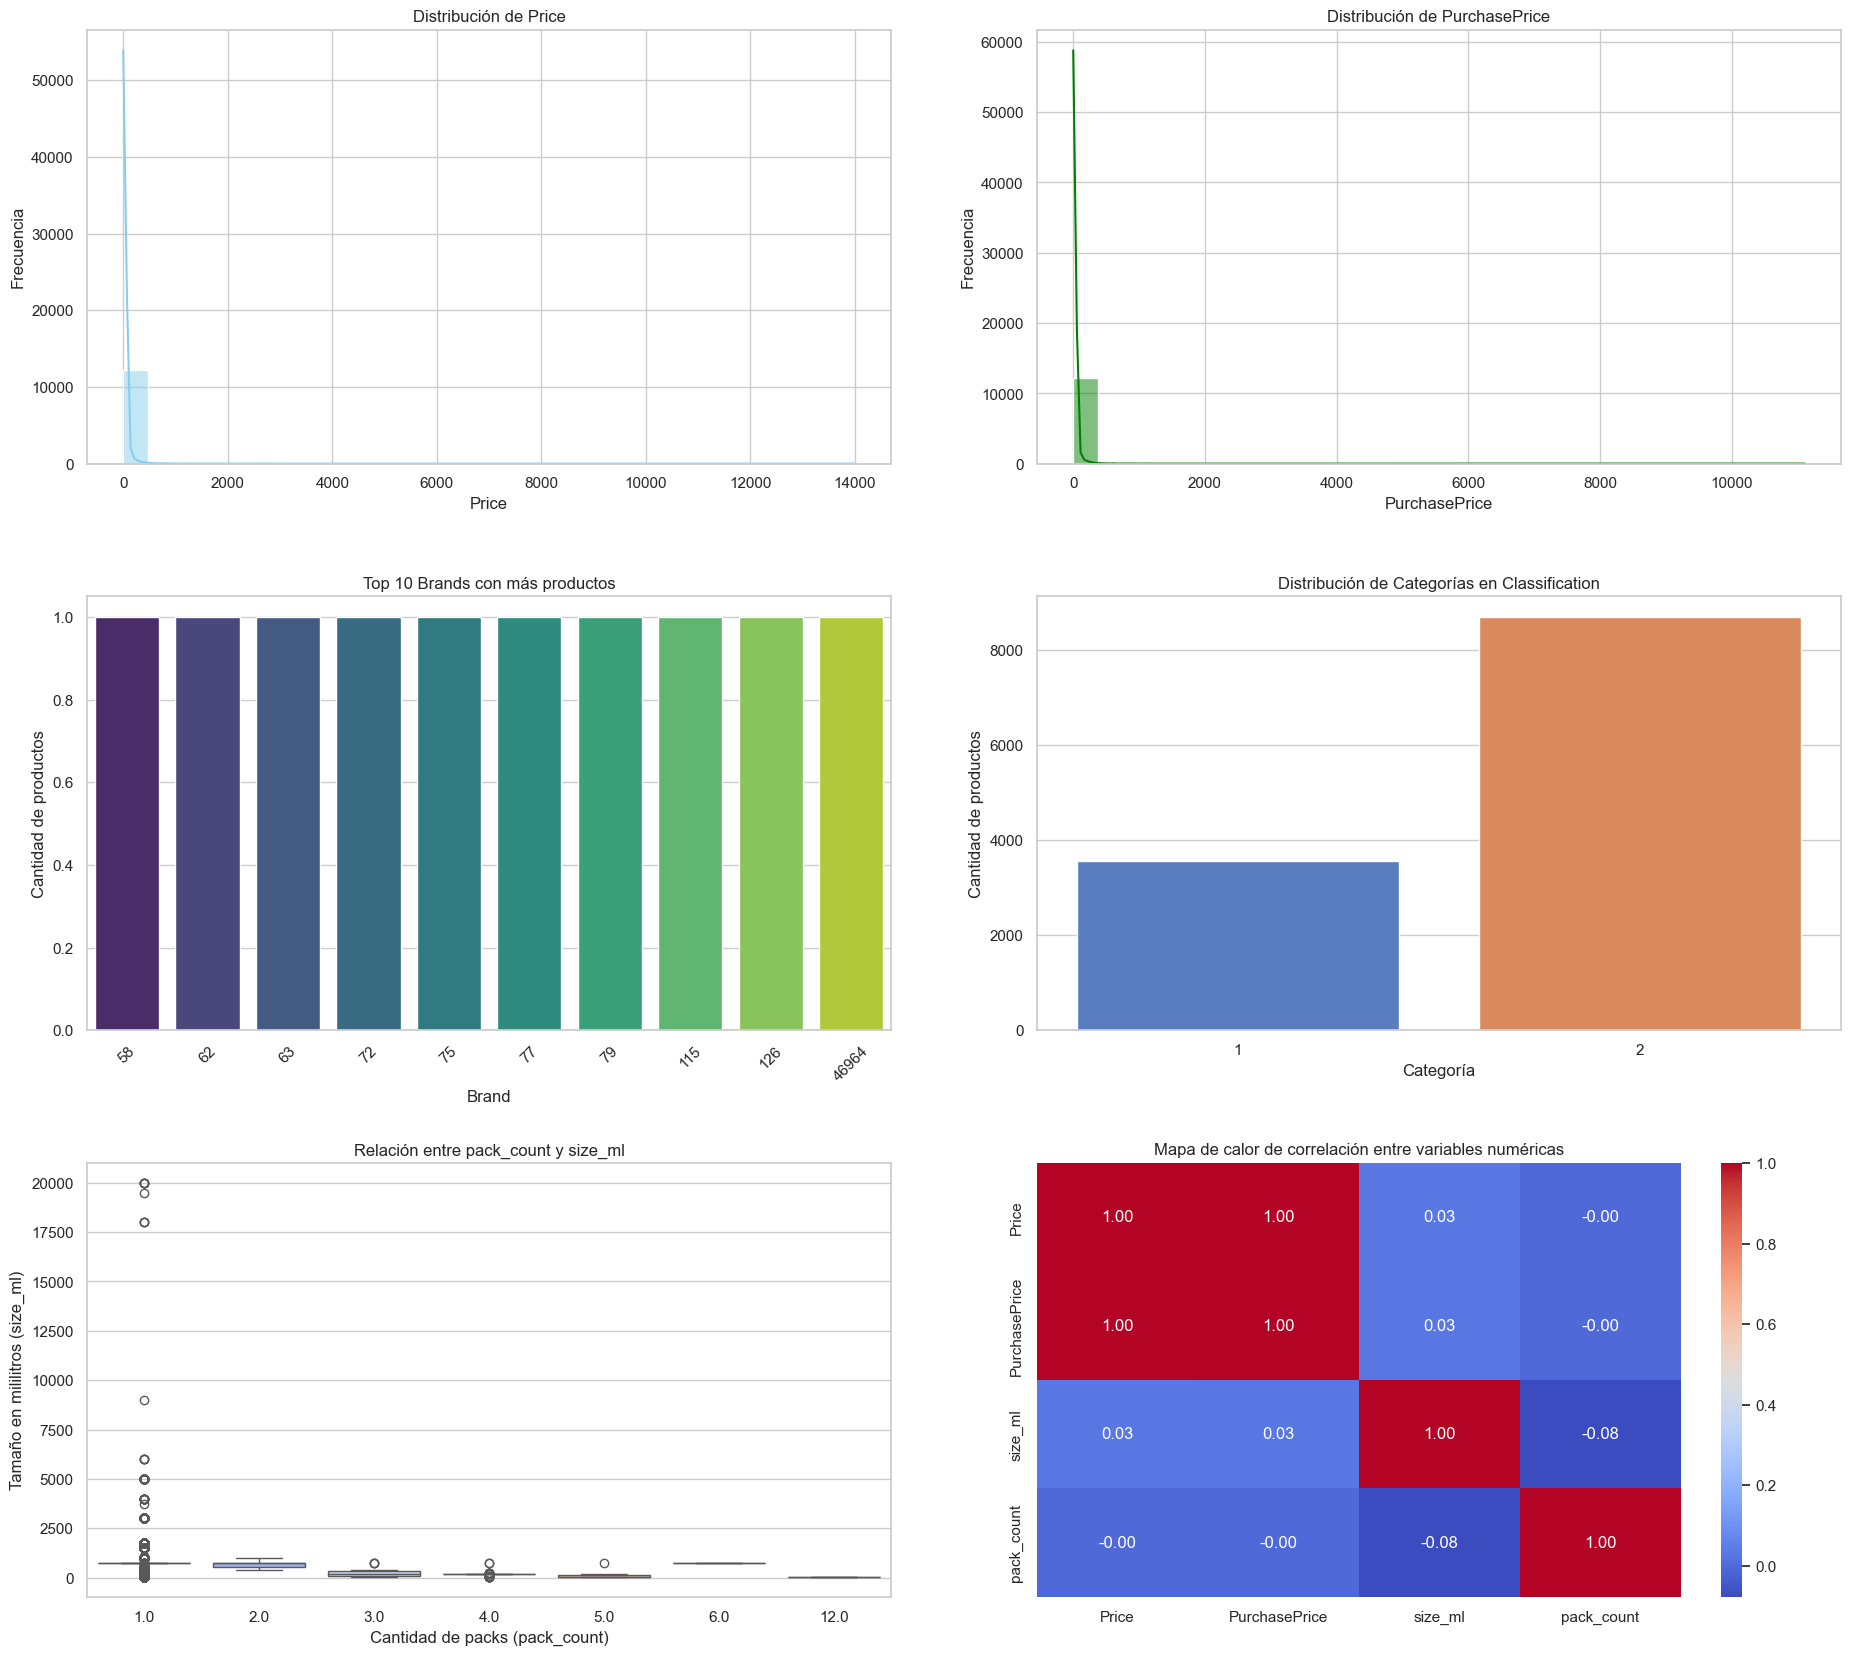

In [48]:
# Configuración de estilo
sns.set(style="whitegrid", palette="pastel")

# Crear un lienzo grande para múltiples gráficos
fig, axes = plt.subplots(3, 2, figsize=(20, 18))
fig.tight_layout(pad=6.0)

# 1. Distribución de Price
sns.histplot(purchasePrices['Price'], kde=True, bins=30, color='skyblue', ax=axes[0, 0])
axes[0, 0].set_title('Distribución de Price')
axes[0, 0].set_xlabel('Price')
axes[0, 0].set_ylabel('Frecuencia')

# 2. Distribución de PurchasePrice
sns.histplot(purchasePrices['PurchasePrice'], kde=True, bins=30, color='green', ax=axes[0, 1])
axes[0, 1].set_title('Distribución de PurchasePrice')
axes[0, 1].set_xlabel('PurchasePrice')
axes[0, 1].set_ylabel('Frecuencia')

# 3. Cantidad de Brands únicos (Top 10)
brand_counts = purchasePrices['Brand'].value_counts()
sns.barplot(x=brand_counts.index[:10], y=brand_counts.values[:10], palette="viridis", ax=axes[1, 0])
axes[1, 0].set_title('Top 10 Brands con más productos')
axes[1, 0].set_xlabel('Brand')
axes[1, 0].set_ylabel('Cantidad de productos')
axes[1, 0].tick_params(axis='x', rotation=45)

# 4. Categorías en Classification
classification_counts = purchasePrices['Classification'].value_counts()
sns.barplot(x=classification_counts.index, y=classification_counts.values, palette="muted", ax=axes[1, 1])
axes[1, 1].set_title('Distribución de Categorías en Classification')
axes[1, 1].set_xlabel('Categoría')
axes[1, 1].set_ylabel('Cantidad de productos')

# 5. Relación entre size_ml y pack_count
sns.boxplot(x=purchasePrices['pack_count'], y=purchasePrices['size_ml'], palette="coolwarm", ax=axes[2, 0])
axes[2, 0].set_title('Relación entre pack_count y size_ml')
axes[2, 0].set_xlabel('Cantidad de packs (pack_count)')
axes[2, 0].set_ylabel('Tamaño en mililitros (size_ml)')

# 6. Correlación entre variables numéricas
numeric_columns = ['Price', 'PurchasePrice', 'size_ml', 'pack_count']
sns.heatmap(purchasePrices[numeric_columns].corr(), annot=True, cmap='coolwarm', fmt=".2f", ax=axes[2, 1])
axes[2, 1].set_title('Mapa de calor de correlación entre variables numéricas')

# Mostrar el gráfico consolidado
plt.show()


C:\Users\anagabrielagonzalezp\AppData\Local\Temp\ipykernel_1260\3956376010.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  purchasePrices['ProfitMargin'] = purchasePrices['Price'] - purchasePrices['PurchasePrice']


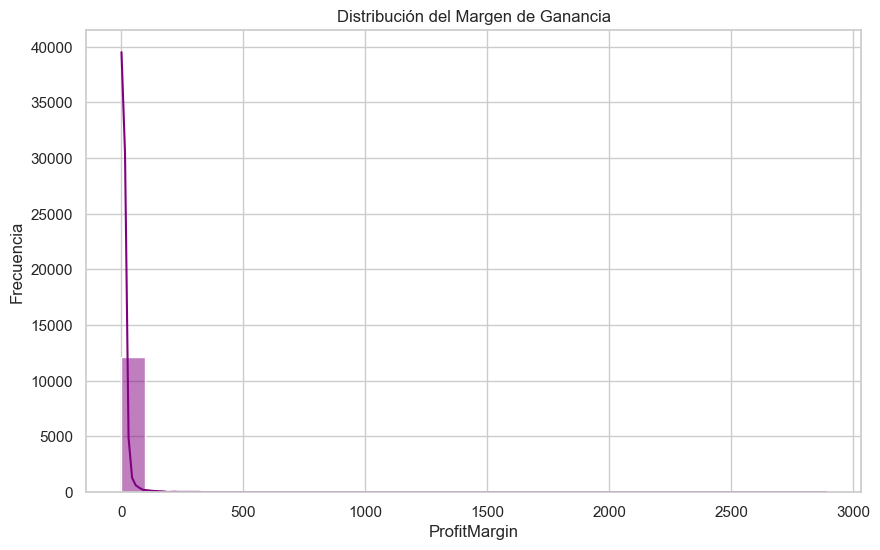

In [50]:
# Calcular margen de ganancia
purchasePrices['ProfitMargin'] = purchasePrices['Price'] - purchasePrices['PurchasePrice']

# Distribución del margen de ganancia
plt.figure(figsize=(10, 6))
sns.histplot(purchasePrices['ProfitMargin'], kde=True, bins=30, color='purple')
plt.title('Distribución del Margen de Ganancia')
plt.xlabel('ProfitMargin')
plt.ylabel('Frecuencia')
plt.show()


Sesgo a la izquierda (valores concentrados cerca de 0):
La mayoría de los productos tienen un margen de ganancia pequeño. Es decir, los precios de venta están muy cerca de los precios de compra, lo cual puede indicar:
-Estrategias de bajo margen para competir en precios.
-Productos con poca rentabilidad.

Pocos valores extremos (outliers):
Hay unos pocos productos con márgenes de ganancia muy altos (derecha del gráfico). Esto podría deberse a productos premium.

La forma del gráfico muestra una distribución sesgada, con la mayoría de los valores concentrados en el rango bajo y un largo "tail" hacia valores altos. Esto es típico en escenarios donde solo unos pocos productos son excepcionalmente rentables.


C:\Users\anagabrielagonzalezp\AppData\Local\Temp\ipykernel_1260\2745295758.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=brand_avg_price.index, y=brand_avg_price.values, palette="magma")


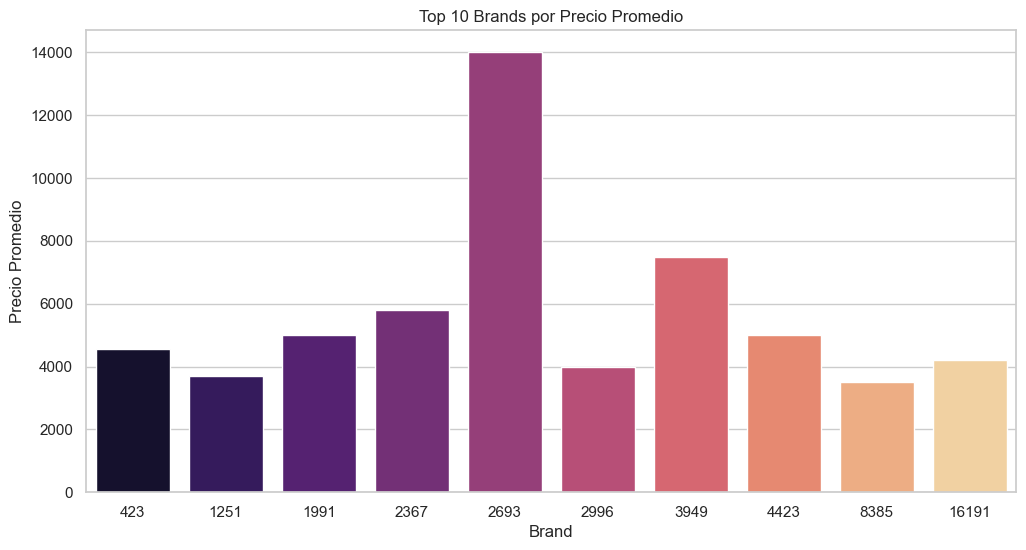

In [51]:
# Top 10 Brands por precio promedio
brand_avg_price = purchasePrices.groupby('Brand')['Price'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=brand_avg_price.index, y=brand_avg_price.values, palette="magma")
plt.title('Top 10 Brands por Precio Promedio')
plt.xlabel('Brand')
plt.ylabel('Precio Promedio')
plt.show()


Se ven unos valores extremos muy grandes en precios pero es un error? quizas es porque es un producto premium o la cantidad tambien es mayor asique analizo el total de ml

C:\Users\anagabrielagonzalezp\AppData\Local\Temp\ipykernel_1260\2144989164.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  purchasePrices['total_ml'] = purchasePrices['size_ml'] * purchasePrices['pack_count']


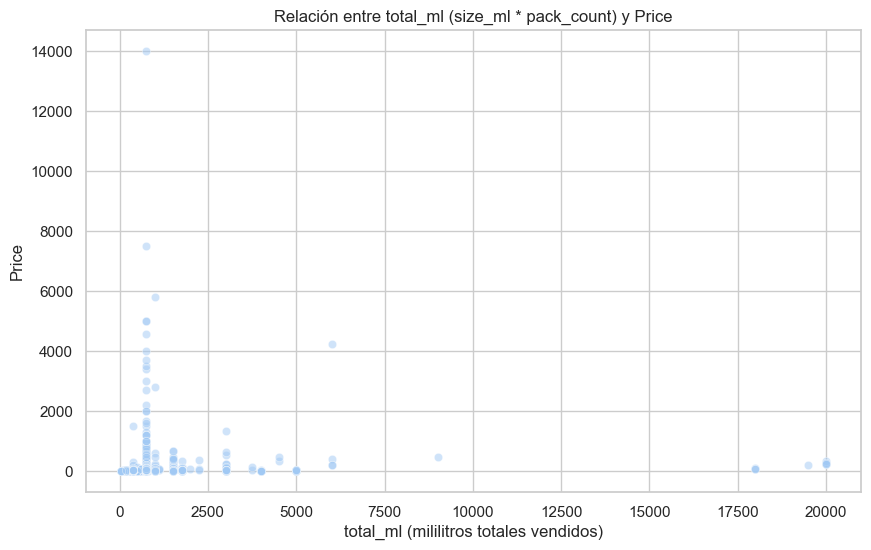

In [53]:
# Calcular el total de mililitros vendidos
purchasePrices['total_ml'] = purchasePrices['size_ml'] * purchasePrices['pack_count']

# Graficar la relación entre total_ml y Price
plt.figure(figsize=(10, 6))
sns.scatterplot(data=purchasePrices, x='total_ml', y='Price', alpha=0.5)
plt.title('Relación entre total_ml (size_ml * pack_count) y Price')
plt.xlabel('total_ml (mililitros totales vendidos)')
plt.ylabel('Price')
plt.show()


Puede ser un producto premium asique no borro los outliers

In [55]:
purchasePrices.to_csv('cleaned_purchasePrices.csv')

### Analisis de InvoicePurchase

In [57]:
invoicePurchases.head()

,VendorNumber,VendorName,InvoiceDate,PONumber,PODate,PayDate,Quantity,Dollars,Freight,Approval
0,105,ALTAMAR BRANDS LLC,2016-01-04,8124,2015-12-21,2016-02-16,6,214.26,3.47,NaN
1,4466,AMERICAN VINTAGE BEVERAGE,2016-01-07,8137,2015-12-22,2016-02-21,15,140.55,8.57,NaN
2,388,ATLANTIC IMPORTING COMPANY,2016-01-09,8169,2015-12-24,2016-02-16,5,106.60,4.61,NaN
3,480,BACARDI USA INC,2016-01-12,8106,2015-12-20,2016-02-05,10100,137483.78,2935.20,NaN
4,516,BANFI PRODUCTS CORP,2016-01-07,8170,2015-12-24,2016-02-12,1935,15527.25,429.20,NaN


In [59]:
invoicePurchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5543 entries, 0 to 5542
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   VendorNumber  5543 non-null   int64  
 1   VendorName    5543 non-null   object 
 2   InvoiceDate   5543 non-null   object 
 3   PONumber      5543 non-null   int64  
 4   PODate        5543 non-null   object 
 5   PayDate       5543 non-null   object 
 6   Quantity      5543 non-null   int64  
 7   Dollars       5543 non-null   float64
 8   Freight       5543 non-null   float64
 9   Approval      374 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 433.2+ KB


Hay muchos nulos en Approval, que tiene?

In [61]:
invoicePurchases['Approval'].unique()

array([nan, 'Frank Delahunt'], dtype=object)

Contiene solo un nombre, la elimino

In [63]:
invoicePurchases = invoicePurchases.drop(columns=['Approval'])

In [64]:
# Convertir columnas de tipo object a string
for column in invoicePurchases.select_dtypes(include=['object']).columns:
    invoicePurchases[column] = invoicePurchases[column].astype('string')

# Convertir columnas a tipos de datos apropiados
invoicePurchases['VendorNumber'] = invoicePurchases['VendorNumber'].astype('int64')
invoicePurchases['PONumber'] = invoicePurchases['PONumber'].astype('int64')
invoicePurchases['Quantity'] = invoicePurchases['Quantity'].astype('int64')
invoicePurchases['Dollars'] = invoicePurchases['Dollars'].astype('float64')
invoicePurchases['Freight'] = invoicePurchases['Freight'].astype('float64')

# Convertir columnas de fecha a datetime
invoicePurchases['InvoiceDate'] = pd.to_datetime(invoicePurchases['InvoiceDate'], errors='coerce')
invoicePurchases['PODate'] = pd.to_datetime(invoicePurchases['PODate'], errors='coerce')
invoicePurchases['PayDate'] = pd.to_datetime(invoicePurchases['PayDate'], errors='coerce')

# Verificar cambios
print(invoicePurchases.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5543 entries, 0 to 5542
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   VendorNumber  5543 non-null   int64         
 1   VendorName    5543 non-null   string        
 2   InvoiceDate   5543 non-null   datetime64[ns]
 3   PONumber      5543 non-null   int64         
 4   PODate        5543 non-null   datetime64[ns]
 5   PayDate       5543 non-null   datetime64[ns]
 6   Quantity      5543 non-null   int64         
 7   Dollars       5543 non-null   float64       
 8   Freight       5543 non-null   float64       
dtypes: datetime64[ns](3), float64(2), int64(3), string(1)
memory usage: 389.9 KB
None


Limpio los strings

In [65]:
invoicePurchases=clean_string_columns(invoicePurchases)

Analisis de nulos

In [66]:
invoicePurchases.isnull().sum()

VendorNumber    0
VendorName      0
InvoiceDate     0
PONumber        0
PODate          0
PayDate         0
Quantity        0
Dollars         0
Freight         0
dtype: int64

Duplicados

In [ ]:
duplicates = invoicePurchases.duplicated()
print(duplicates.sum())

0


Busqueda de valores invalidos o fuera de rando

In [70]:
print(invoicePurchases[invoicePurchases['Quantity'] < 0])  # Valores negativos
print(invoicePurchases[(invoicePurchases['PODate'] > invoicePurchases['InvoiceDate']) | (invoicePurchases['InvoiceDate'] > invoicePurchases['PayDate'])])

Empty DataFrame
Columns: [VendorNumber, VendorName, InvoiceDate, PONumber, PODate, PayDate, Quantity, Dollars, Freight]
Index: []
Empty DataFrame
Columns: [VendorNumber, VendorName, InvoiceDate, PONumber, PODate, PayDate, Quantity, Dollars, Freight]
Index: []


In [76]:
columns_to_analyze = ['Quantity', 'Dollars', 'Freight']  # Columnas a analizar
stats, conclusion_text = generate_descriptive_statistics(invoicePurchases, columns_to_analyze)

# Mostrar estadísticas descriptivas
print("Estadísticas Descriptivas:")
for col, desc in stats.items():
    print(f"\nColumna: {col}")
    print(desc)

# Mostrar conclusiones
print("\nConclusiones:")
print(conclusion_text)

# Opcional: Guardar conclusiones en un archivo de texto
with open("invoicePurchases.txt", "w") as f:
    f.write(conclusion_text)


Estadísticas Descriptivas:

Columna: Quantity
count      5543.000000
mean       6058.880931
std       14453.338164
min           1.000000
25%          83.000000
50%         423.000000
75%        5100.500000
max      141660.000000
Name: Quantity, dtype: float64

Columna: Dollars
count    5.543000e+03
mean     5.807338e+04
std      1.402340e+05
min      4.140000e+00
25%      9.678100e+02
50%      4.765450e+03
75%      4.458718e+04
max      1.660436e+06
Name: Dollars, dtype: float64

Columna: Freight
count    5543.000000
mean      295.954301
std       713.585093
min         0.020000
25%         5.020000
50%        24.730000
75%       229.660000
max      8468.220000
Name: Freight, dtype: float64

Conclusiones:
**Columna 'Quantity':**
- Promedio: 6058.88
- Mediana: 423.00
- Mínimo: 1.00
- Máximo: 141660.00
- Rango intercuartil (IQR): 5017.50

**Columna 'Dollars':**
- Promedio: 58073.38
- Mediana: 4765.45
- Mínimo: 4.14
- Máximo: 1660435.88
- Rango intercuartil (IQR): 43619.37

**Columna 'Fr

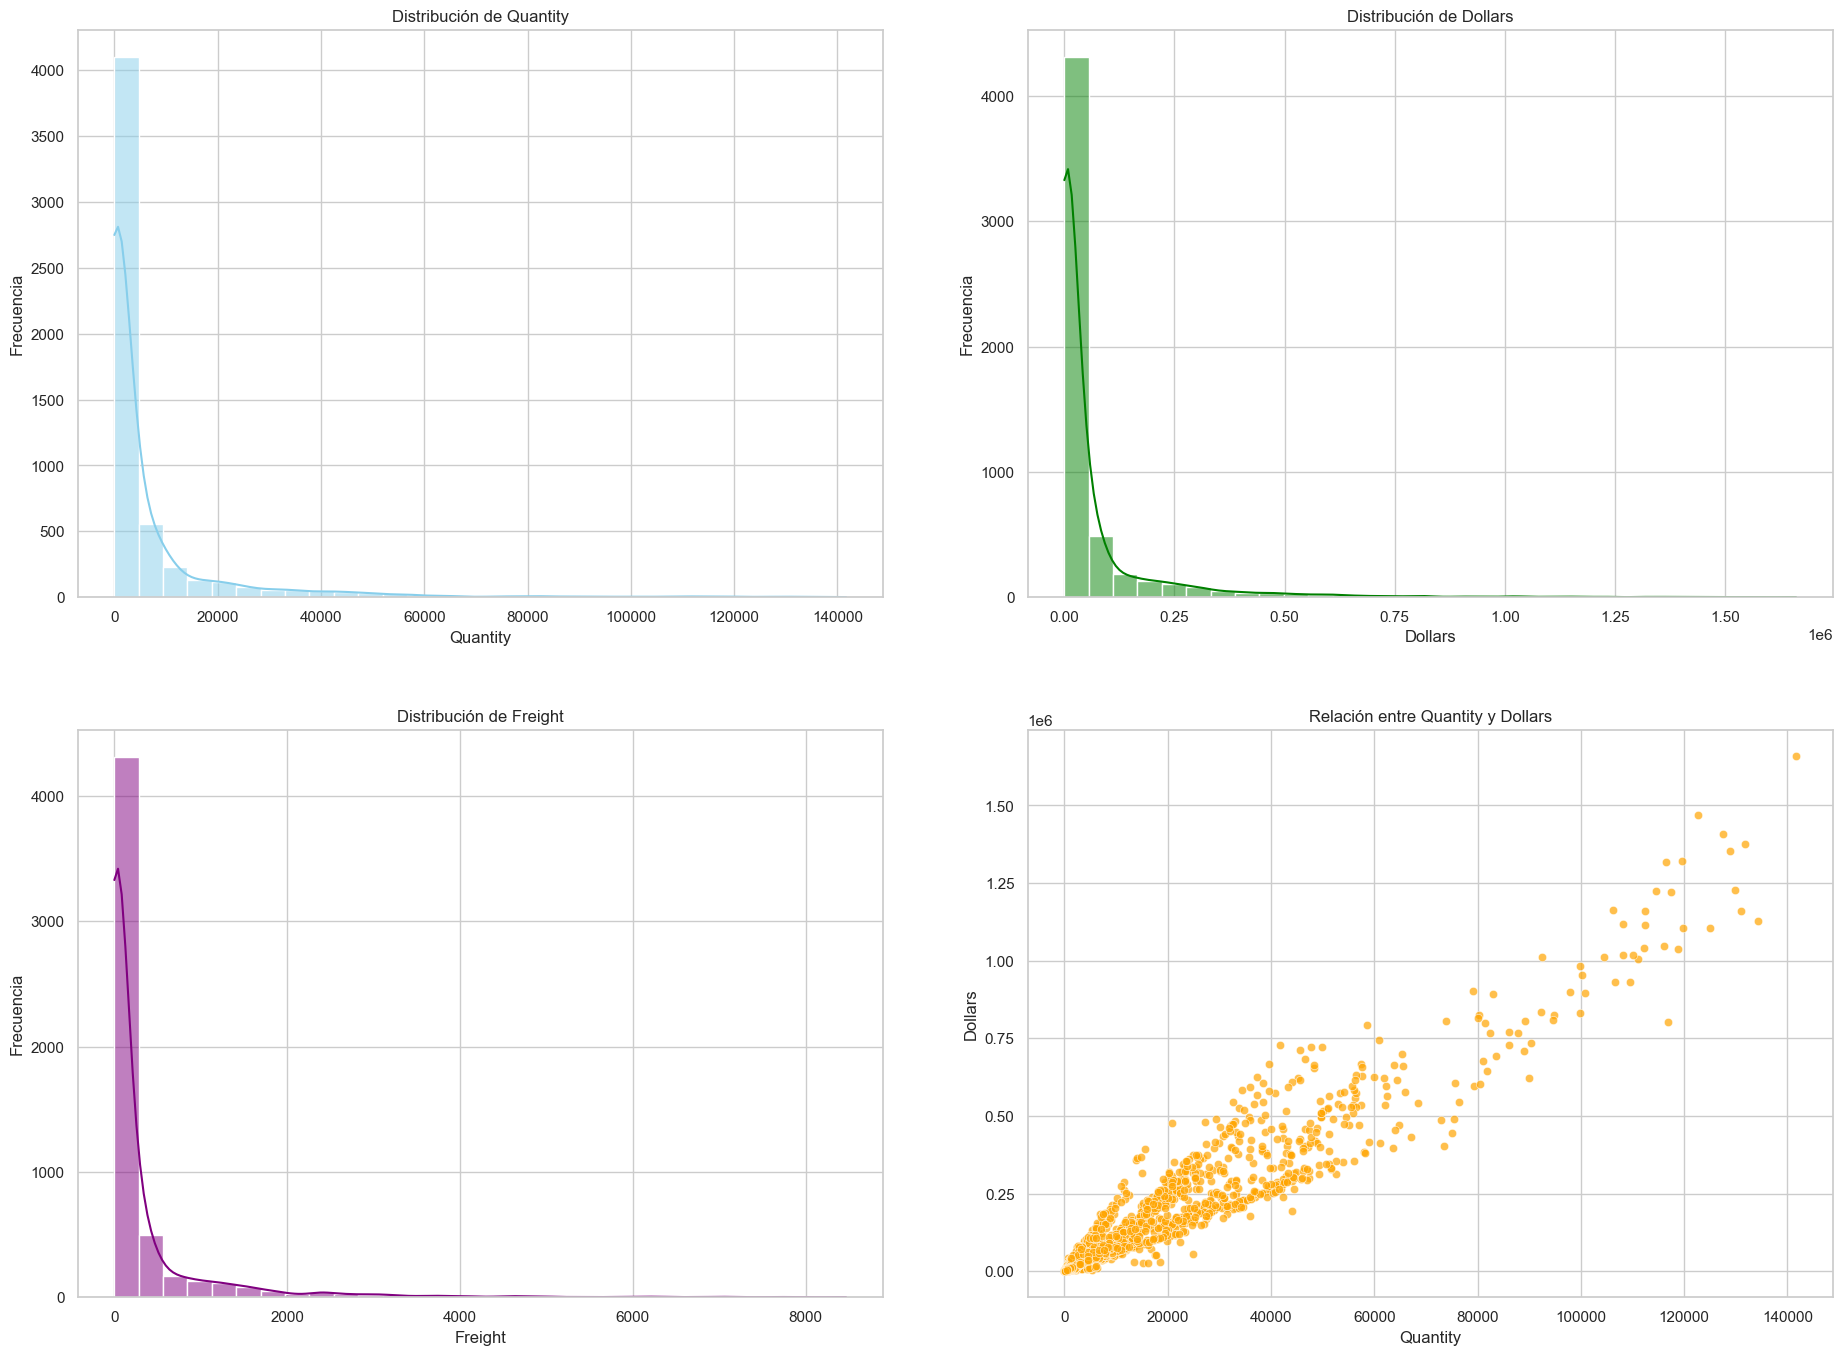

In [77]:
# Configuración de estilo
sns.set(style="whitegrid", palette="pastel")

# Crear un lienzo grande para múltiples gráficos
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
fig.tight_layout(pad=6.0)

# 1. Distribución de Quantity
sns.histplot(invoicePurchases['Quantity'], kde=True, bins=30, color='skyblue', ax=axes[0, 0])
axes[0, 0].set_title('Distribución de Quantity')
axes[0, 0].set_xlabel('Quantity')
axes[0, 0].set_ylabel('Frecuencia')

# 2. Distribución de Dollars
sns.histplot(invoicePurchases['Dollars'], kde=True, bins=30, color='green', ax=axes[0, 1])
axes[0, 1].set_title('Distribución de Dollars')
axes[0, 1].set_xlabel('Dollars')
axes[0, 1].set_ylabel('Frecuencia')

# 3. Distribución de Freight
sns.histplot(invoicePurchases['Freight'], kde=True, bins=30, color='purple', ax=axes[1, 0])
axes[1, 0].set_title('Distribución de Freight')
axes[1, 0].set_xlabel('Freight')
axes[1, 0].set_ylabel('Frecuencia')

# 4. Relación entre Quantity y Dollars
sns.scatterplot(data=invoicePurchases, x='Quantity', y='Dollars', alpha=0.7, ax=axes[1, 1], color='orange')
axes[1, 1].set_title('Relación entre Quantity y Dollars')
axes[1, 1].set_xlabel('Quantity')
axes[1, 1].set_ylabel('Dollars')

# Mostrar el visual
plt.show()


Distribución de Quantity (Cantidad)
Observaciones:
La mayoría de las órdenes tienen cantidades pequeñas (concentración cerca de 0).
Existen valores extremos con cantidades muy grandes, que podrían ser casos de órdenes de gran volumen.

Distribución de Dollars (Monto total)
Observaciones:
La distribución también está sesgada hacia la izquierda, lo que indica que la mayoría de las órdenes tienen un valor monetario bajo.
Existen órdenes con valores significativamente altos, lo que podría estar relacionado con las grandes cantidades observadas en el gráfico de Quantity.

Distribución de Freight (Costo de Envío)
Observaciones:
La mayoría de los costos de envío son bajos, pero hay algunos pedidos con costos de envío elevados.
Los costos de envío más altos podrían corresponder a pedidos con cantidades o montos más altos.

Relación entre Quantity y Dollars
Observaciones:
Existe una relación positiva entre Quantity y Dollars, lo que es esperable: a mayor cantidad pedida, mayor es el monto total del pedido.
Algunos puntos no siguen esta tendencia, lo que podría deberse a:
Diferencias de precio por unidad.
Productos con precios significativamente más altos o bajos.

Analisis temporales

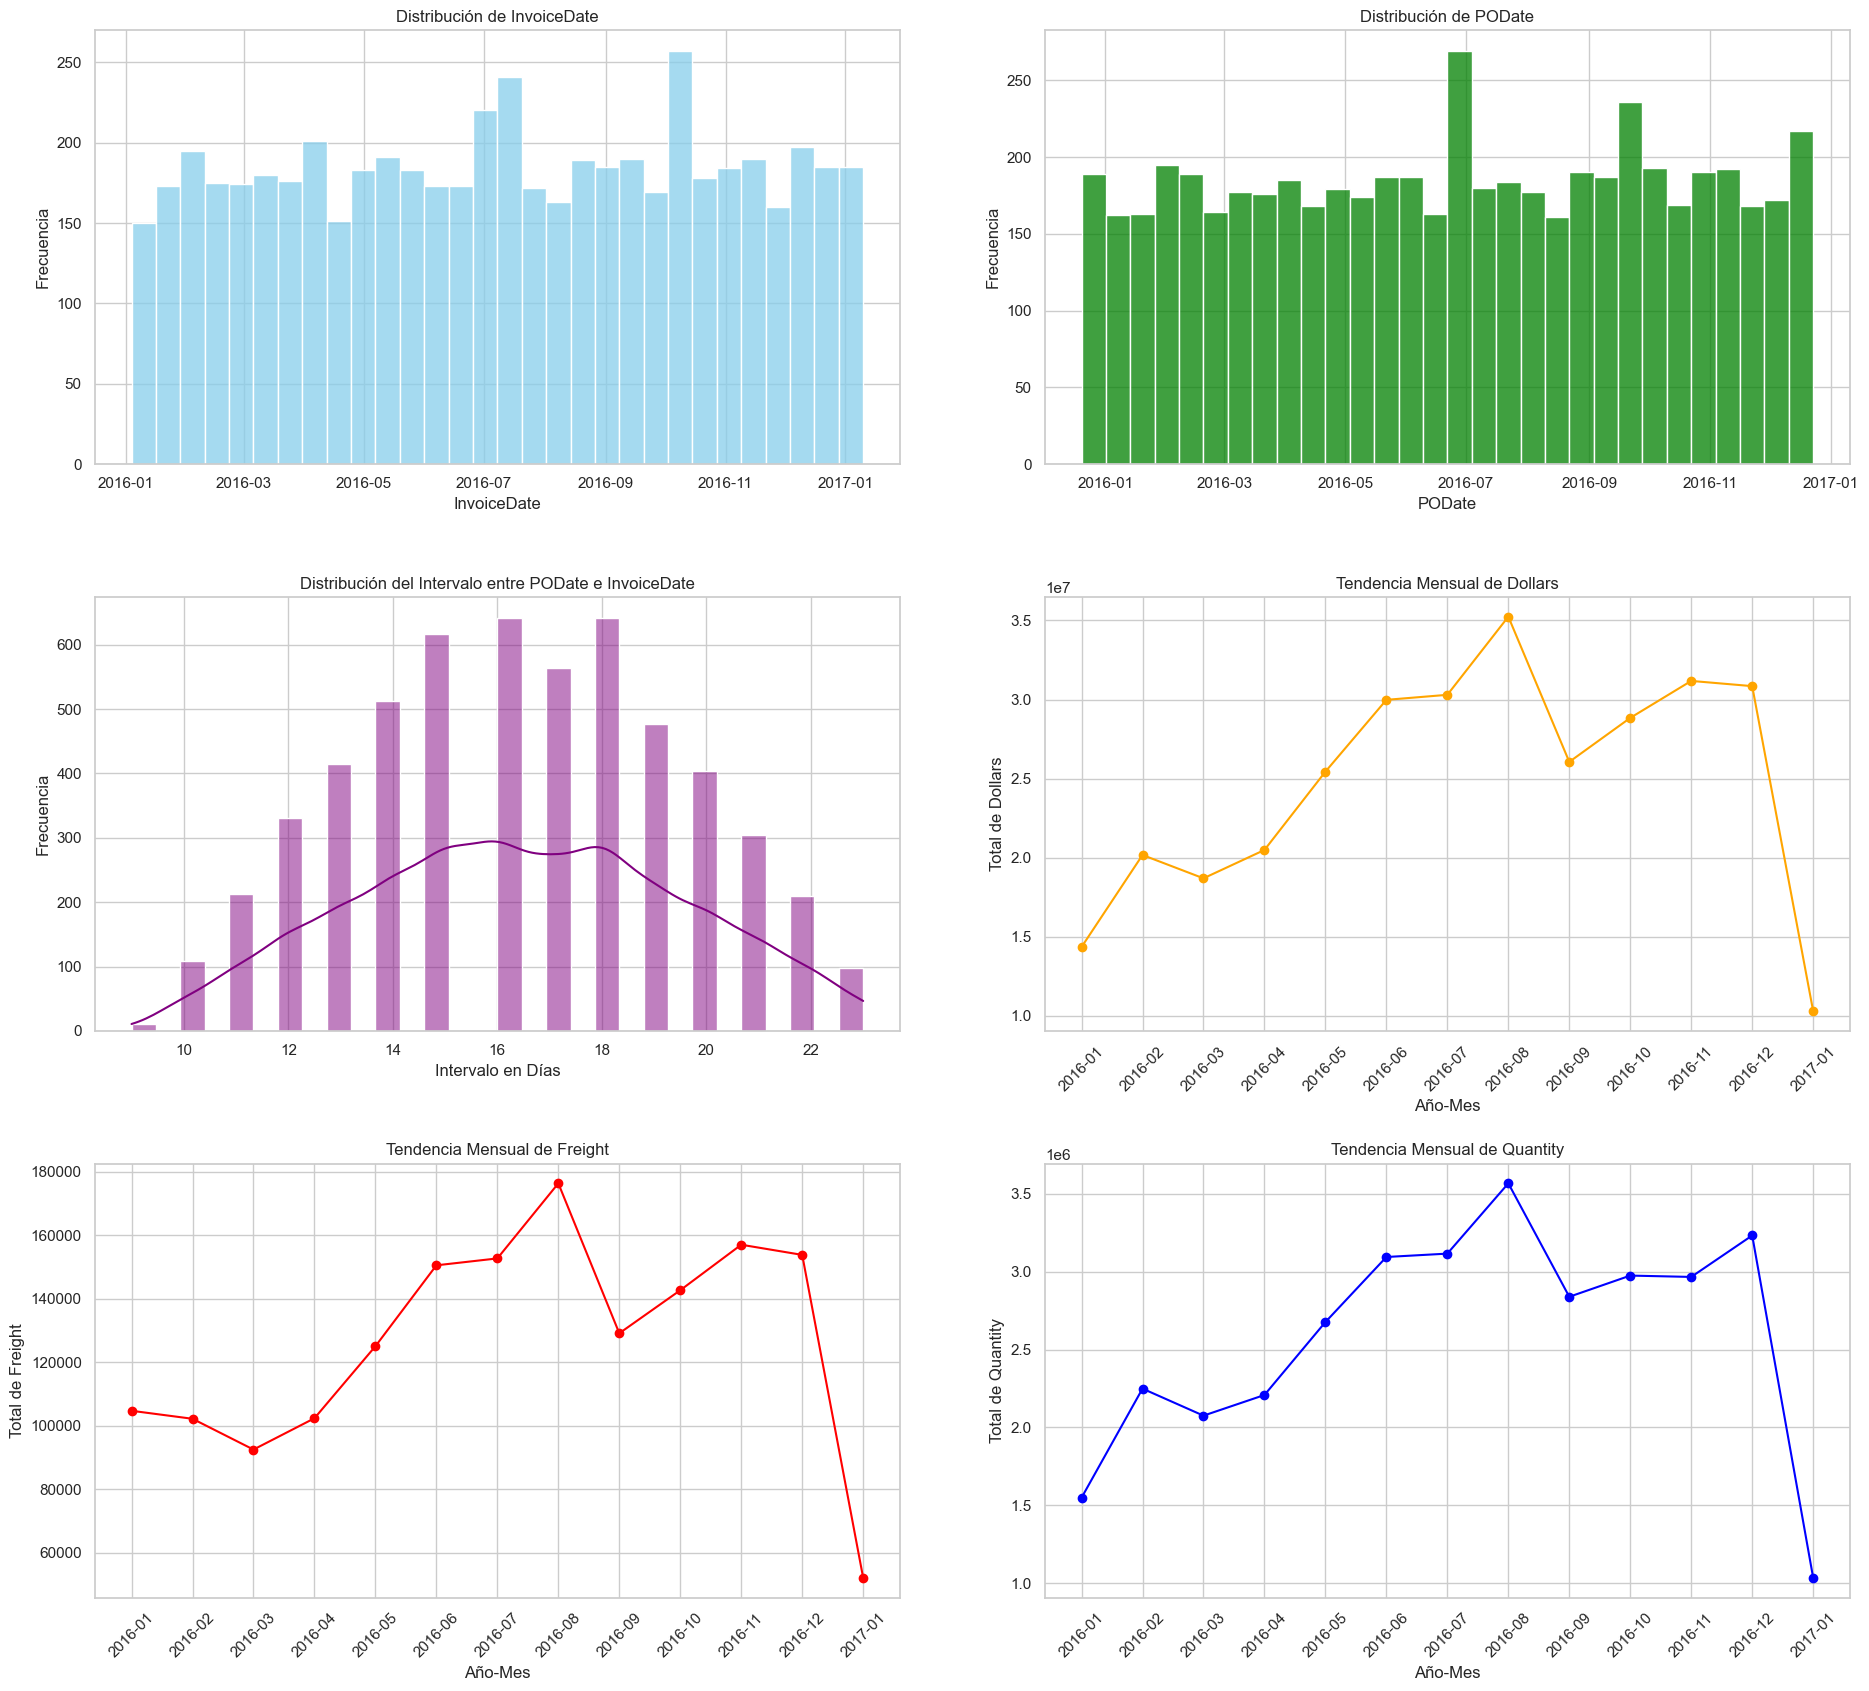

In [79]:
# Configuración de estilo
sns.set(style="whitegrid", palette="pastel")

# Crear una nueva columna para los años y meses
invoicePurchases['YearMonth'] = invoicePurchases['InvoiceDate'].dt.to_period('M')

# Crear el lienzo para múltiples gráficos
fig, axes = plt.subplots(3, 2, figsize=(20, 18))
fig.tight_layout(pad=6.0)

# 1. Distribución de fechas de facturación (InvoiceDate)
sns.histplot(invoicePurchases['InvoiceDate'], kde=False, bins=30, color='skyblue', ax=axes[0, 0])
axes[0, 0].set_title('Distribución de InvoiceDate')
axes[0, 0].set_xlabel('InvoiceDate')
axes[0, 0].set_ylabel('Frecuencia')

# 2. Distribución de fechas de órdenes de compra (PODate)
sns.histplot(invoicePurchases['PODate'], kde=False, bins=30, color='green', ax=axes[0, 1])
axes[0, 1].set_title('Distribución de PODate')
axes[0, 1].set_xlabel('PODate')
axes[0, 1].set_ylabel('Frecuencia')

# 3. Intervalo entre PODate e InvoiceDate
invoicePurchases['Interval_Days'] = (invoicePurchases['InvoiceDate'] - invoicePurchases['PODate']).dt.days
sns.histplot(invoicePurchases['Interval_Days'], kde=True, bins=30, color='purple', ax=axes[1, 0])
axes[1, 0].set_title('Distribución del Intervalo entre PODate e InvoiceDate')
axes[1, 0].set_xlabel('Intervalo en Días')
axes[1, 0].set_ylabel('Frecuencia')

# 4. Tendencia temporal de Dollars por mes
dollars_trend = invoicePurchases.groupby('YearMonth')['Dollars'].sum()
axes[1, 1].plot(dollars_trend.index.astype(str), dollars_trend.values, marker='o', color='orange')
axes[1, 1].set_title('Tendencia Mensual de Dollars')
axes[1, 1].set_xlabel('Año-Mes')
axes[1, 1].set_ylabel('Total de Dollars')
axes[1, 1].tick_params(axis='x', rotation=45)

# 5. Tendencia temporal de Freight por mes
freight_trend = invoicePurchases.groupby('YearMonth')['Freight'].sum()
axes[2, 0].plot(freight_trend.index.astype(str), freight_trend.values, marker='o', color='red')
axes[2, 0].set_title('Tendencia Mensual de Freight')
axes[2, 0].set_xlabel('Año-Mes')
axes[2, 0].set_ylabel('Total de Freight')
axes[2, 0].tick_params(axis='x', rotation=45)

# 6. Relación entre fechas y cantidad (Quantity) por mes
quantity_trend = invoicePurchases.groupby('YearMonth')['Quantity'].sum()
axes[2, 1].plot(quantity_trend.index.astype(str), quantity_trend.values, marker='o', color='blue')
axes[2, 1].set_title('Tendencia Mensual de Quantity')
axes[2, 1].set_xlabel('Año-Mes')
axes[2, 1].set_ylabel('Total de Quantity')
axes[2, 1].tick_params(axis='x', rotation=45)

# Mostrar los gráficos
plt.show()


Distribución de InvoiceDate (Fechas de facturación)
-Las transacciones están distribuidas de manera uniforme a lo largo del tiempo, sin evidencia de estacionalidad clara en las fechas de facturación.

Distribución de PODate (Fechas de órdenes de compra)
-Las órdenes de compra también están distribuidas de manera uniforme, sin fluctuaciones significativas en las fechas de emisión.

Intervalo entre PODate e InvoiceDate
-La mayoría de las órdenes tienen un intervalo entre 14 y 18 días.
-El intervalo presenta un patrón simétrico, lo que sugiere consistencia en los tiempos de procesamiento.

Tendencia mensual de Dollars (Ingresos)
-Los ingresos mensuales muestran un aumento constante desde principios de 2016 hasta julio de 2016, donde alcanzan su punto máximo.
-Después de julio, los ingresos se estabilizan y comienzan a disminuir hacia el final del año.

Tendencia mensual de Freight (Costos de envío)
-Los costos de envío aumentan junto con los ingresos, alcanzando un máximo en julio de 2016.
-Posteriormente, los costos se estabilizan y disminuyen hacia finales de año.

Tendencia mensual de Quantity (Cantidad)
-La cantidad total de productos pedidos sigue una tendencia similar a los ingresos, con un máximo en julio de 2016.
-Hay una ligera disminución hacia finales del año.


In [80]:
invoicePurchases['FreightPercentage'] = (invoicePurchases['Freight'] / invoicePurchases['Dollars']) * 100
print(invoicePurchases[['Dollars', 'Freight', 'FreightPercentage']].describe())


            Dollars      Freight  FreightPercentage
count  5.543000e+03  5543.000000        5543.000000
mean   5.807338e+04   295.954301           0.550504
std    1.402340e+05   713.585093           0.480129
min    4.140000e+00     0.020000           0.441628
25%    9.678100e+02     5.020000           0.470298
50%    4.765450e+03    24.730000           0.500003
75%    4.458718e+04   229.660000           0.529997
max    1.660436e+06  8468.220000          11.522531


Columna ID

In [ ]:

invoicePurchases['InvoicePurchaseID'] = invoicePurchases.index + 1

# Verificar que la clave primaria sea única
print("¿Es 'InvoicePurchaseID' única?", invoicePurchases['InvoicePurchaseID'].is_unique)

# Establecer 'InvoicePurchaseID' como índice (clave primaria)
invoicePurchases.set_index('InvoicePurchaseID', inplace=True)

print("Primeras filas")
print(invoicePurchases.head())

# Guardar el DataFrame con la clave primaria
invoicePurchases.to_csv('InvoicePurchases.csv')



¿Es 'InvoicePurchaseID' única? True
Primeras filas
                   VendorNumber                  VendorName InvoiceDate  \
InvoicePurchaseID                                                         
1                           105          altamar brands llc  2016-01-04   
2                          4466   american vintage beverage  2016-01-07   
3                           388  atlantic importing company  2016-01-09   
4                           480             bacardi usa inc  2016-01-12   
5                           516         banfi products corp  2016-01-07   

                   PONumber     PODate    PayDate  Quantity    Dollars  \
InvoicePurchaseID                                                        
1                      8124 2015-12-21 2016-02-16         6     214.26   
2                      8137 2015-12-22 2016-02-21        15     140.55   
3                      8169 2015-12-24 2016-02-16         5     106.60   
4                      8106 2015-12-20 2016-02-05    

### Analisis de BegInventory

In [110]:
begInv.head()

,InventoryId,Store,City,Brand,Description,Size,onHand,Price,startDate
0,1_HARDERSFIELD_58,1,HARDERSFIELD,58,Gekkeikan Black & Gold Sake,750mL,8,12.99,2016-01-01
1,1_HARDERSFIELD_60,1,HARDERSFIELD,60,Canadian Club 1858 VAP,750mL,7,10.99,2016-01-01
2,1_HARDERSFIELD_62,1,HARDERSFIELD,62,Herradura Silver Tequila,750mL,6,36.99,2016-01-01
3,1_HARDERSFIELD_63,1,HARDERSFIELD,63,Herradura Reposado Tequila,750mL,3,38.99,2016-01-01
4,1_HARDERSFIELD_72,1,HARDERSFIELD,72,No. 3 London Dry Gin,750mL,6,34.99,2016-01-01


In [111]:
begInv.dtypes

InventoryId     object
Store            int64
City            object
Brand            int64
Description     object
Size            object
onHand           int64
Price          float64
startDate       object
dtype: object

In [112]:
# Convertir columnas de tipo object a string excepto startDate
columns_to_convert = [col for col in begInv.columns if begInv[col].dtype == 'object' and col != 'startDate']
begInv[columns_to_convert] = begInv[columns_to_convert].astype('string')

# Convertir startDate a formato de fecha
begInv['startDate'] = pd.to_datetime(begInv['startDate'], errors='coerce')

# Verificar los cambios
print(begInv.dtypes)

InventoryId    string[python]
Store                   int64
City           string[python]
Brand                   int64
Description    string[python]
Size           string[python]
onHand                  int64
Price                 float64
startDate      datetime64[ns]
dtype: object


In [113]:
begInv=clean_string_columns(begInv)

Analisis de nulos

In [114]:
# Identificar las filas con valores nulos
nulos = begInv[begInv.isnull().any(axis=1)]

# Mostrar solo los valores nulos (indicando las columnas afectadas)
print("\nFilas con valores nulos:")
print(nulos)


Filas con valores nulos:
Empty DataFrame
Columns: [InventoryId, Store, City, Brand, Description, Size, onHand, Price, startDate]
Index: []


In [115]:
columns_to_analyze = begInv.columns  

# Mostrar los valores únicos en cada columna
print("\nValores únicos por columna:")
for column in columns_to_analyze:
    unique_values = begInv[column].unique()
    print(f"{column}: {len(unique_values)} valores únicos")
    print(unique_values[:10])  # Mostrar solo los primeros 10 valores para evitar salidas muy largas
    print("-" * 50)



Valores únicos por columna:
InventoryId: 206529 valores únicos
['1_hardersfield_58' '1_hardersfield_60' '1_hardersfield_62'
 '1_hardersfield_63' '1_hardersfield_72' '1_hardersfield_75'
 '1_hardersfield_77' '1_hardersfield_79' '1_hardersfield_115'
 '1_hardersfield_120']
--------------------------------------------------
Store: 79 valores únicos
[ 1  2  3  4  5  6  7  8  9 10]
--------------------------------------------------
City: 67 valores únicos
['hardersfield' 'ashborne' 'hornsey' 'eanverness' 'sutton' 'goulcrest'
 'stanmore' 'alnerwick' 'blackpool' 'cardend']
--------------------------------------------------
Brand: 8094 valores únicos
[ 58  60  62  63  72  75  77  79 115 120]
--------------------------------------------------
Description: 7287 valores únicos
['gekkeikan black & gold sake' 'canadian club 1858 vap'
 'herradura silver tequila' 'herradura reposado tequila'
 'no. 3 london dry gin' 'three olives tomato vodka'
 'three olives espresso vodka' 'three olives loopy vodka'
 

HAY SOLO UNA FECHA, es el inicio del inventario

In [116]:
# Verificar valores nulos explícitos
print("\nVerificación de valores nulos (NaN):")
print(begInv.isnull().sum())

# Verificar cadenas vacías o espacios en blanco en columnas tipo string
print("\nVerificación de cadenas vacías o espacios en blanco:")
for column in begInv.select_dtypes(include=['object']).columns:
    empty_values = begInv[begInv[column].str.strip() == ""]
    print(f"{column}: {len(empty_values)} filas con cadenas vacías o espacios.")
    if not empty_values.empty:
        print(empty_values)

# Verificar valores específicos que podrían representar datos faltantes
print("\nVerificación de valores sospechosos como -1, 0, 'none':")
suspicious_values = [-1, 0, 'none', 'na', 'n/a', 'null', '']
for column in begInv.columns:
    if begInv[column].dtype == 'object':
        invalid = begInv[begInv[column].str.lower().isin(suspicious_values)]
    else:
        invalid = begInv[begInv[column].isin([-1, 0])]
    print(f"{column}: {len(invalid)} filas con valores sospechosos.")
    if not invalid.empty:
        print(invalid.head())



Verificación de valores nulos (NaN):
InventoryId    0
Store          0
City           0
Brand          0
Description    0
Size           0
onHand         0
Price          0
startDate      0
dtype: int64

Verificación de cadenas vacías o espacios en blanco:
InventoryId: 0 filas con cadenas vacías o espacios.
City: 0 filas con cadenas vacías o espacios.
Description: 0 filas con cadenas vacías o espacios.
Size: 0 filas con cadenas vacías o espacios.

Verificación de valores sospechosos como -1, 0, 'none':
InventoryId: 0 filas con valores sospechosos.
Store: 0 filas con valores sospechosos.
City: 0 filas con valores sospechosos.
Brand: 0 filas con valores sospechosos.
Description: 0 filas con valores sospechosos.
Size: 0 filas con valores sospechosos.
onHand: 6044 filas con valores sospechosos.
           InventoryId  Store          City  Brand  \
11  1_hardersfield_165      1  hardersfield    165   
26  1_hardersfield_305      1  hardersfield    305   
30  1_hardersfield_356      1  hard

esos valores de price con valor 0?

Revision de duplicados

In [117]:
# Revisar duplicados
print("\nAnálisis de duplicados:")
duplicated_rows = begInv[begInv.duplicated()]
print(f"Duplicados encontrados: {len(duplicated_rows)}")
if len(duplicated_rows) > 0:
    print(duplicated_rows)


Análisis de duplicados:
Duplicados encontrados: 0


In [118]:
# Analizar valores inconsistentes o anómalos
print("\nAnálisis de inconsistencias:")
# Verificar rangos y valores atípicos
print("Rango de valores en columnas numéricas:")
print(begInv[['Store', 'Brand', 'onHand', 'Price']].describe())



Análisis de inconsistencias:
Rango de valores en columnas numéricas:
               Store          Brand         onHand          Price
count  206529.000000  206529.000000  206529.000000  206529.000000
mean       42.122457   13761.482320      20.429455      22.253910
std        23.191393   13059.429355      31.467342      70.178964
min         1.000000      58.000000       0.000000       0.000000
25%        22.000000    3746.000000       7.000000       9.990000
50%        42.000000    8010.000000      12.000000      14.990000
75%        64.000000   22143.000000      21.000000      21.990000
max        79.000000   90090.000000    1251.000000   13999.900000


In [119]:
# Validar valores numéricos (ejemplo: precios negativos)
invalid_prices = begInv[begInv['Price'] <= 0]
print("\nRegistros con precios inválidos:")
print(invalid_prices)
# Identificar y eliminar registros con precios inválidos (menor o igual a 0)
begInv = begInv[begInv['Price'] > 0].reset_index(drop=True)


Registros con precios inválidos:
               InventoryId  Store       City  Brand  \
36829    15_wanborne_19138     15   wanborne  19138   
175458  69_mountmend_19138     69  mountmend  19138   

                         Description   Size  onHand  Price  startDate  
36829   gerard bertrand organic rose  750ml       0    0.0 2016-01-01  
175458  gerard bertrand organic rose  750ml       2    0.0 2016-01-01  


In [120]:
invalid_prices = begInv[begInv['Price'] <= 0]
print("\nRegistros con precios inválidos:")
print(invalid_prices)


Registros con precios inválidos:
Empty DataFrame
Columns: [InventoryId, Store, City, Brand, Description, Size, onHand, Price, startDate]
Index: []


La funcion para parsear Size me genero muchos nulos, asique la modifico

In [121]:
# Función para procesar la columna 'Size', incluyendo casos específicos problemáticos, la modifico
def parse_size(size):
    if pd.isnull(size):  # Verificar si el valor es nulo
        return {"size_ml": np.nan, "pack_count": np.nan}  # Retorna valores nulos si el campo es vacío

    size = size.strip().lower()  # Elimina espacios al principio/final y convierte a minúsculas

    # Manejar paquetes, como "100mL 4 Pk"
    match = re.match(r"(\d+(?:\.\d+)?)(ml|l) (\d+) pk", size)
    if match:
        unit_size = float(match.group(1))  # Tamaño individual
        if match.group(2) == 'l':  # Convertir litros a mililitros
            unit_size *= 1000
        pack_count = int(match.group(3))  # Número de botellas en el paquete
        return {"size_ml": unit_size, "pack_count": pack_count}

    # Manejar tamaños con adicionales, como "750mL + 3/"
    match = re.match(r"(\d+(?:\.\d+)?)(ml|l)(?: \+ (\d+)/)?", size)
    if match:
        unit_size = float(match.group(1))  # Tamaño individual
        if match.group(2) == 'l':  # Convertir litros a mililitros
            unit_size *= 1000
        additional_count = int(match.group(3)) if match.group(3) else 0  # Ítems adicionales
        return {"size_ml": unit_size, "pack_count": 1 + additional_count}

    # Manejar tamaños con número adicional separado por espacios, como "750mL  3"
    match = re.match(r"(\d+(?:\.\d+)?)(ml|l)\s+(\d+)", size)
    if match:
        unit_size = float(match.group(1))  # Tamaño individual
        if match.group(2) == 'l':  # Convertir litros a mililitros
            unit_size *= 1000
        pack_count = int(match.group(3))  # Número adicional
        return {"size_ml": unit_size, "pack_count": pack_count}

    # Manejar tamaños individuales, como "750mL" o "162.5mL"
    match = re.match(r"(\d+(?:\.\d+)?)(ml|l)", size)
    if match:
        unit_size = float(match.group(1))  # Tamaño individual
        if match.group(2) == 'l':  # Convertir litros a mililitros
            unit_size *= 1000
        return {"size_ml": unit_size, "pack_count": 1}

    # Manejar otros formatos como onzas u otros
    match = re.match(r"(\d+(?:\.\d+)?)\s?(oz|gal)", size)
    if match:
        unit_size = float(match.group(1))
        if match.group(2) == 'oz':  # Convertir onzas a mililitros
            unit_size *= 29.5735
        elif match.group(2) == 'gal':  # Convertir galones a mililitros
            unit_size *= 3785.41
        return {"size_ml": unit_size, "pack_count": 1}

    # Casos específicos problemáticos
    if size == 'liter':
        return {"size_ml": 1000.0, "pack_count": 1}  # Interpretar un litro como 1000ml
    if size == '3/100ml':
        return {"size_ml": 100.0, "pack_count": 3}  # Interpretar "3/100ml" como tres paquetes de 100ml

    # Retornar valores nulos si el tamaño no coincide con ningún patrón conocido
    return {"size_ml": np.nan, "pack_count": np.nan}

# Aplicar la función parse_size a la columna 'Size'
size_data = begInv['Size'].apply(parse_size)

# Crear nuevas columnas en el DataFrame
begInv['size_ml'] = size_data.apply(lambda x: x['size_ml'])
begInv['pack_count'] = size_data.apply(lambda x: x['pack_count'])

# Verificar las primeras filas para confirmar resultados
print("Primeras filas del DataFrame después de procesar la columna 'Size':")
print(begInv[['Size', 'size_ml', 'pack_count']].head(10))

# Contar valores nulos para evaluar el éxito del procesamiento
print("Valores nulos en las columnas derivadas:")
print(begInv[['size_ml', 'pack_count']].isnull().sum())

# Identificar valores problemáticos restantes
problematic_rows = begInv[begInv['size_ml'].isnull()]
print("Valores problemáticos restantes en la columna 'Size':")
print(problematic_rows['Size'].unique())


Primeras filas del DataFrame después de procesar la columna 'Size':
    Size  size_ml  pack_count
0  750ml    750.0           1
1  750ml    750.0           1
2  750ml    750.0           1
3  750ml    750.0           1
4  750ml    750.0           1
5  750ml    750.0           1
6  750ml    750.0           1
7  750ml    750.0           1
8  liter   1000.0           1
9  750ml    750.0           1
Valores nulos en las columnas derivadas:
size_ml       0
pack_count    0
dtype: int64
Valores problemáticos restantes en la columna 'Size':
[]


In [123]:
columns_to_analyze = ['Store', 'onHand', 'Price', 'size_ml','pack_count']  # Columnas a analizar
stats, conclusion_text = generate_descriptive_statistics(begInv, columns_to_analyze)

# Mostrar estadísticas descriptivas
print("Estadísticas Descriptivas:")
for col, desc in stats.items():
    print(f"\nColumna: {col}")
    print(desc)

# Mostrar conclusiones
print("\nConclusiones:")
print(conclusion_text)

# Opcional: Guardar conclusiones en un archivo de texto
with open("beginv.txt", "w") as f:
    f.write(conclusion_text)



Estadísticas Descriptivas:

Columna: Store
count    206527.000000
mean         42.122459
std          23.191353
min           1.000000
25%          22.000000
50%          42.000000
75%          64.000000
max          79.000000
Name: Store, dtype: float64

Columna: onHand
count    206527.000000
mean         20.429644
std          31.467436
min           0.000000
25%           7.000000
50%          12.000000
75%          21.000000
max        1251.000000
Name: onHand, dtype: float64

Columna: Price
count    206527.000000
mean         22.254126
std          70.179269
min           0.490000
25%           9.990000
50%          14.990000
75%          21.990000
max       13999.900000
Name: Price, dtype: float64

Columna: size_ml
count    206527.000000
mean        914.756826
std         603.840766
min          50.000000
25%         750.000000
50%         750.000000
75%         750.000000
max       20000.000000
Name: size_ml, dtype: float64

Columna: pack_count
count    206527.000000
mean       

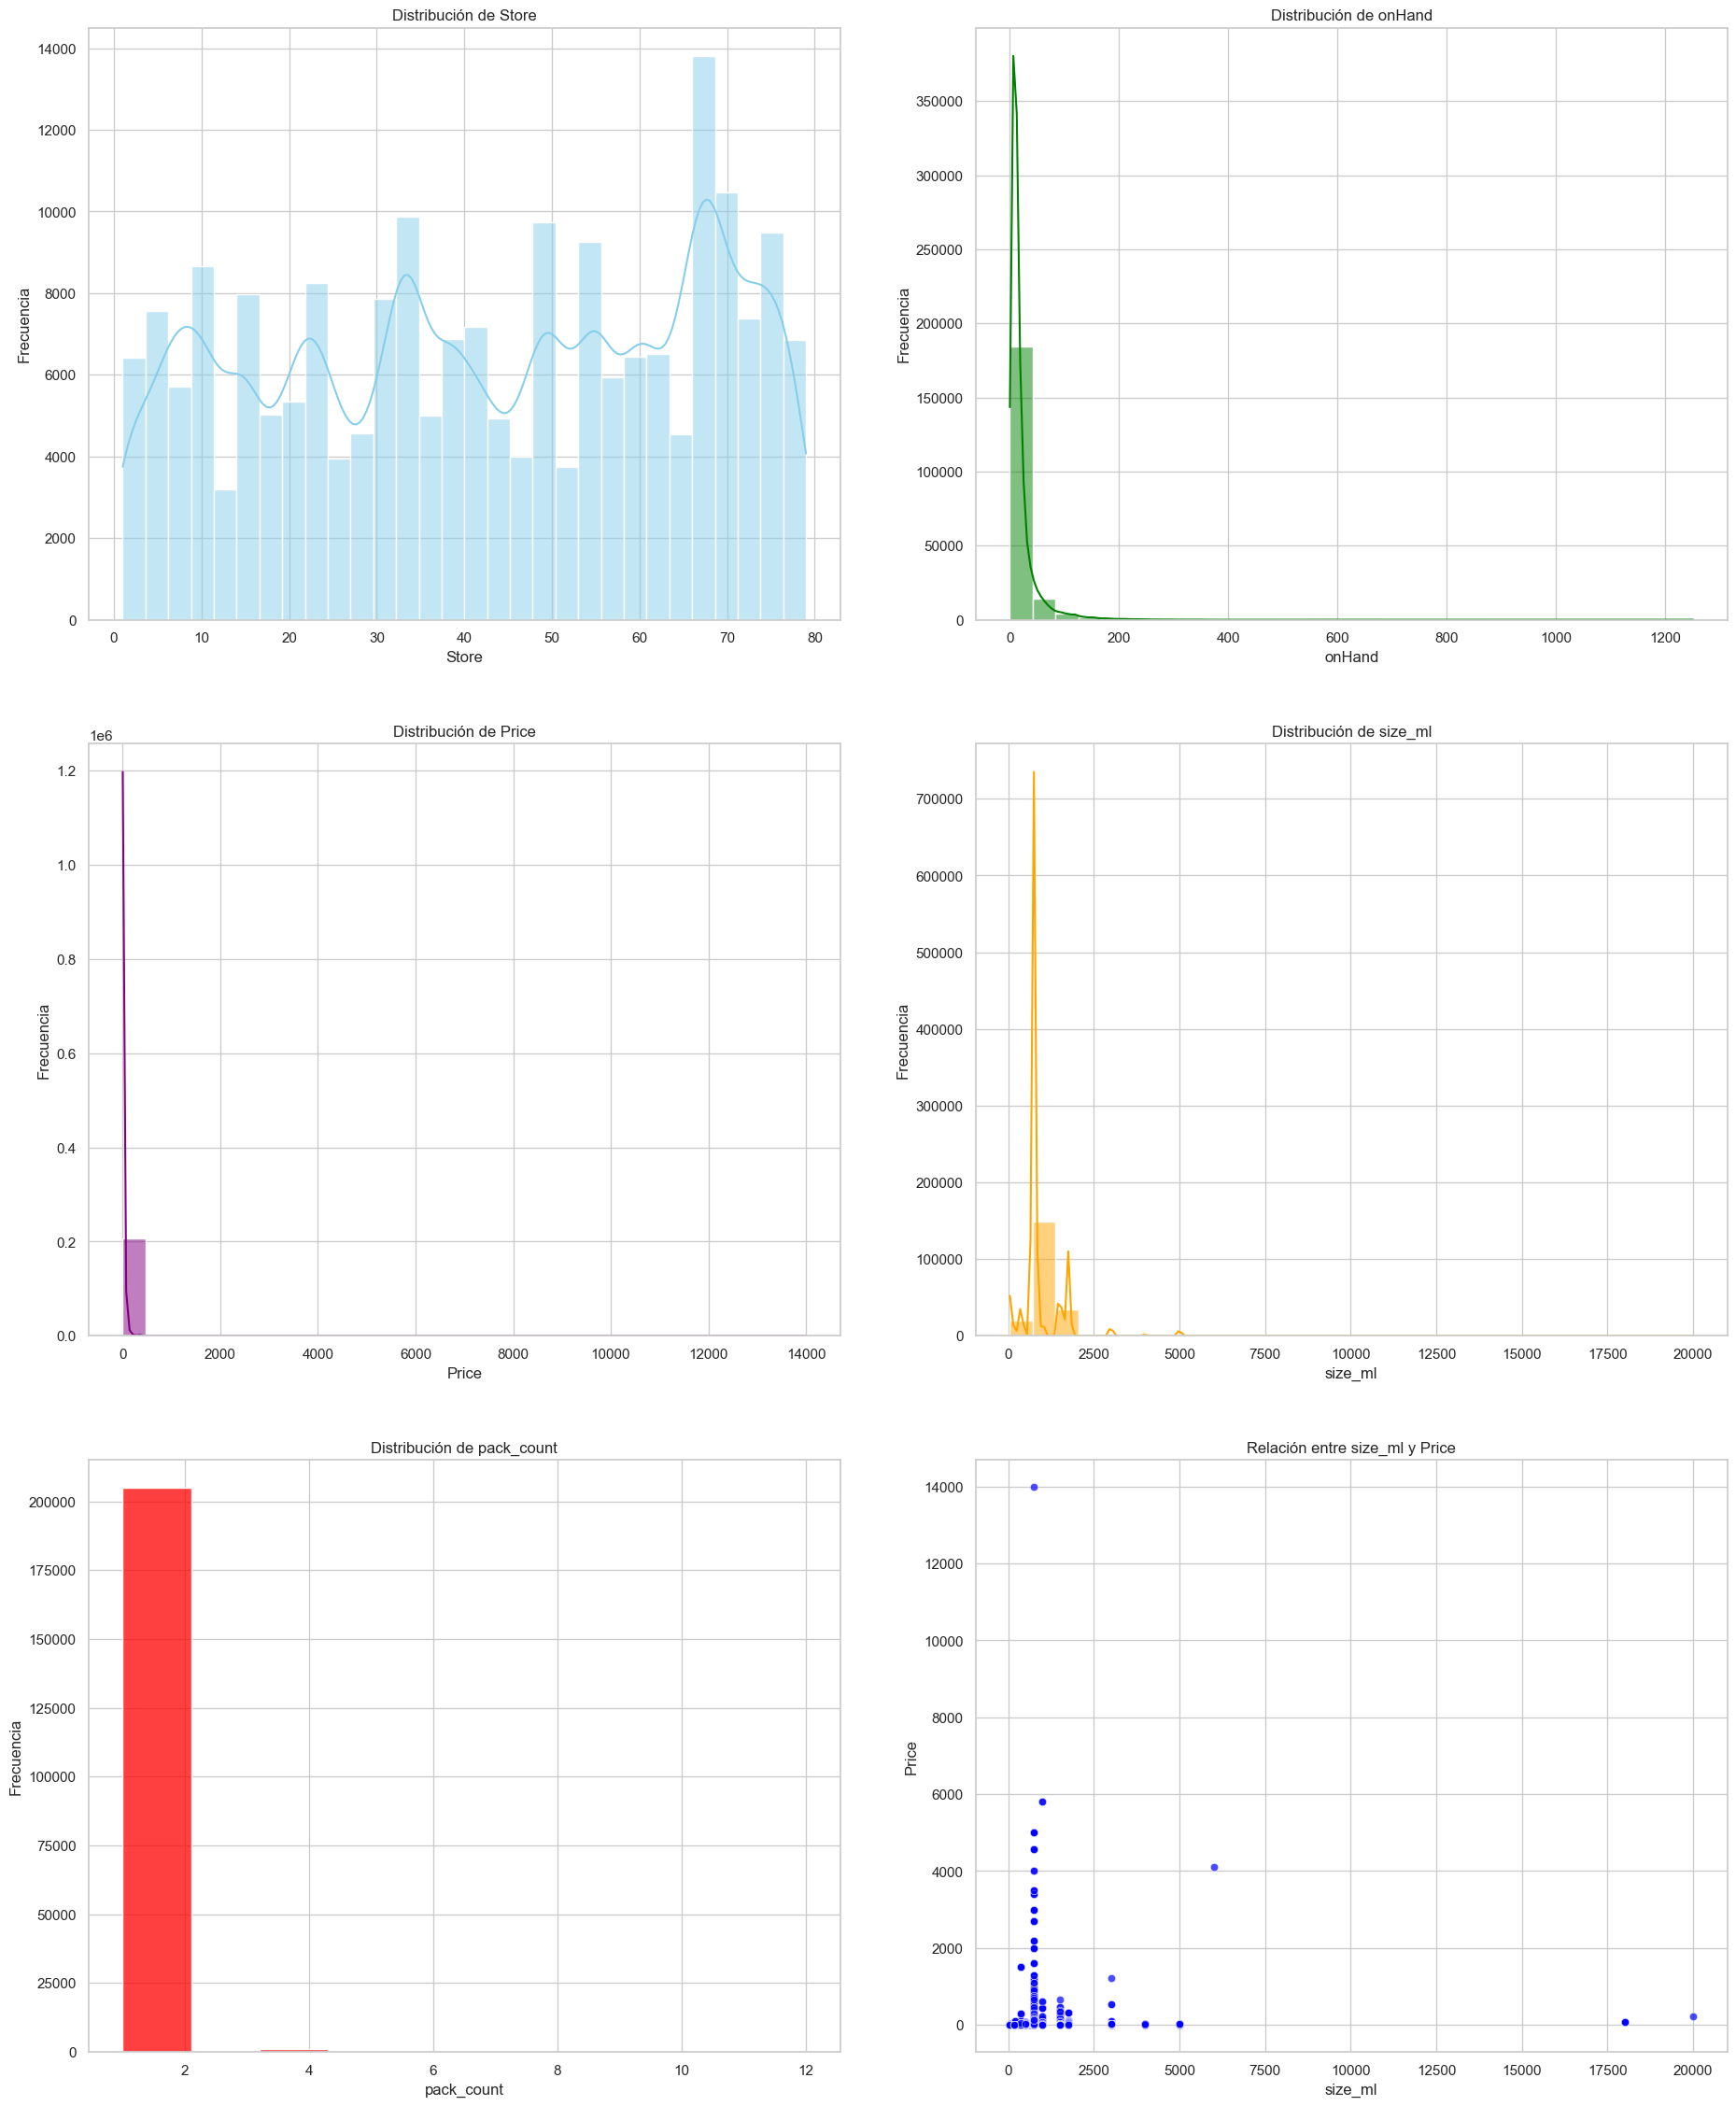

In [126]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de estilo para los gráficos
sns.set(style="whitegrid", palette="pastel")

# Crear un lienzo para múltiples gráficos
fig, axes = plt.subplots(3, 2, figsize=(20, 24))
fig.tight_layout(pad=6.0)

# 1. Distribución de Store
sns.histplot(begInv['Store'], kde=True, bins=30, color='skyblue', ax=axes[0, 0])
axes[0, 0].set_title('Distribución de Store')
axes[0, 0].set_xlabel('Store')
axes[0, 0].set_ylabel('Frecuencia')

# 2. Distribución de onHand
sns.histplot(begInv['onHand'], kde=True, bins=30, color='green', ax=axes[0, 1])
axes[0, 1].set_title('Distribución de onHand')
axes[0, 1].set_xlabel('onHand')
axes[0, 1].set_ylabel('Frecuencia')

# 3. Distribución de Price
sns.histplot(begInv['Price'], kde=True, bins=30, color='purple', ax=axes[1, 0])
axes[1, 0].set_title('Distribución de Price')
axes[1, 0].set_xlabel('Price')
axes[1, 0].set_ylabel('Frecuencia')

# 4. Distribución de size_ml
sns.histplot(begInv['size_ml'], kde=True, bins=30, color='orange', ax=axes[1, 1])
axes[1, 1].set_title('Distribución de size_ml')
axes[1, 1].set_xlabel('size_ml')
axes[1, 1].set_ylabel('Frecuencia')

# 5. Distribución de pack_count
sns.histplot(begInv['pack_count'], kde=False, bins=10, color='red', ax=axes[2, 0])
axes[2, 0].set_title('Distribución de pack_count')
axes[2, 0].set_xlabel('pack_count')
axes[2, 0].set_ylabel('Frecuencia')

# 6. Relación entre Price y size_ml
sns.scatterplot(data=begInv, x='size_ml', y='Price', alpha=0.7, ax=axes[2, 1], color='blue')
axes[2, 1].set_title('Relación entre size_ml y Price')
axes[2, 1].set_xlabel('size_ml')
axes[2, 1].set_ylabel('Price')



# Mostrar el visual
plt.show()


**Columna 'Store':** La distribución muestra una cantidad uniforme de registros para diferentes valores de Store, con ligeras fluctuaciones.

**Columna 'onHand':** La mayoría de los valores están concentrados cerca de 0, con algunos registros alcanzando valores significativamente altos, mostrando una distribución sesgada hacia la izquierda.

**Columna 'Price':** Los precios están mayoritariamente concentrados en valores bajos, con pocos registros con precios muy elevados, lo que genera una distribución sesgada hacia la derecha.

**Columna 'size_ml':** Los tamaños están altamente concentrados en valores bajos, con algunos registros de tamaños significativamente grandes, lo que crea una distribución similar a la de los precios.

**Columna 'pack_count':** La mayoría de los registros tienen un conteo de paquetes igual a 1, con muy pocos valores en los niveles más altos.

**Relación entre 'size_ml' y 'Price':** La relación muestra que, aunque el precio aumenta con el tamaño, muchos valores altos de tamaño no tienen un precio proporcionalmente elevado. Hay una gran concentración de puntos en la esquina inferior izquierda del gráfico.

### Tabla vendedores

In [144]:
purchasePrices=pd.read_csv('purchasePrices.csv')
# Crear una tabla con solo las columnas VendorNumber y VendorName, eliminando duplicados
vendors = purchasePrices[['VendorNumber', 'VendorName']].drop_duplicates(subset=['VendorNumber', 'VendorName']).set_index('VendorNumber')
# Guardar la tabla en un archivo CSV con VendorNumber como índice
vendors_table.to_csv('vendors.csv')

print("La tabla de vendedores se ha guardado como 'vendors.csv'.")

La tabla de vendedores se ha guardado como 'vendors.csv'.


In [149]:
vendors=pd.read_csv('vendors.csv')

In [152]:
# Identificar duplicados en VendorNumber
duplicates = vendors[vendors.duplicated(subset=['VendorNumber'], keep=False)]
print("Duplicados encontrados:")
print(duplicates)

# Eliminar duplicados conservando el primero
vendors = vendors.drop_duplicates(subset=['VendorNumber'], keep='first')

# Guardar datos limpios
vendors.to_csv('vendors.csv', index=False)
print("Datos limpios guardados en 'cleaned_vendors.csv'.")

Duplicados encontrados:
Empty DataFrame
Columns: [VendorNumber, VendorName]
Index: []
Datos limpios guardados en 'cleaned_vendors.csv'.


### Tabla productos

In [ ]:
# Seleccionar columnas relevantes para la tabla Products
products_table = purchasePrices[['Brand', 'Description', 'Size', 'Classification']].drop_duplicates().reset_index(drop=True)

# Función para procesar la columna 'Size'
def parse_size(size):
    if pd.isnull(size):  # Verificar si el valor es nulo
        return {"size_ml": np.nan, "pack_count": np.nan}  # Retorna valores nulos si el campo es vacío

    size = size.strip().lower()  # Elimina espacios al principio/final y convierte a minúsculas

    # Manejar paquetes, como "100mL 4 Pk"
    match = re.match(r"(\d+(?:\.\d+)?)(ml|l) (\d+) pk", size)
    if match:
        unit_size = float(match.group(1))  # Tamaño individual
        if match.group(2) == 'l':  # Convertir litros a mililitros
            unit_size *= 1000
        pack_count = int(match.group(3))  # Número de botellas en el paquete
        return {"size_ml": unit_size, "pack_count": pack_count}

    # Manejar tamaños con adicionales, como "750mL + 3/"
    match = re.match(r"(\d+(?:\.\d+)?)(ml|l)(?: \+ (\d+)/)?", size)
    if match:
        unit_size = float(match.group(1))  # Tamaño individual
        if match.group(2) == 'l':  # Convertir litros a mililitros
            unit_size *= 1000
        additional_count = int(match.group(3)) if match.group(3) else 0  # Ítems adicionales
        return {"size_ml": unit_size, "pack_count": 1 + additional_count}

    # Manejar tamaños con número adicional separado por espacios, como "750mL  3"
    match = re.match(r"(\d+(?:\.\d+)?)(ml|l)\s+(\d+)", size)
    if match:
        unit_size = float(match.group(1))  # Tamaño individual
        if match.group(2) == 'l':  # Convertir litros a mililitros
            unit_size *= 1000
        pack_count = int(match.group(3))  # Número adicional
        return {"size_ml": unit_size, "pack_count": pack_count}

    # Manejar tamaños individuales, como "750mL" o "162.5mL"
    match = re.match(r"(\d+(?:\.\d+)?)(ml|l)", size)
    if match:
        unit_size = float(match.group(1))  # Tamaño individual
        if match.group(2) == 'l':  # Convertir litros a mililitros
            unit_size *= 1000
        return {"size_ml": unit_size, "pack_count": 1}

    # Manejar otros formatos como onzas u otros
    match = re.match(r"(\d+(?:\.\d+)?)\s?(oz|gal)", size)
    if match:
        unit_size = float(match.group(1))
        if match.group(2) == 'oz':  # Convertir onzas a mililitros
            unit_size *= 29.5735
        elif match.group(2) == 'gal':  # Convertir galones a mililitros
            unit_size *= 3785.41
        return {"size_ml": unit_size, "pack_count": 1}

    # Retornar valores nulos si el tamaño no coincide con ningún patrón conocido
    return {"size_ml": np.nan, "pack_count": np.nan}

# Aplicar la función parse_size a la columna 'Size'
size_data = products_table['Size'].apply(parse_size)

# Crear nuevas columnas en el DataFrame
products_table['size_ml'] = size_data.apply(lambda x: x['size_ml'])
products_table['pack_count'] = size_data.apply(lambda x: x['pack_count'])

# Verificar las primeras filas para confirmar resultados
print("Primeras filas del DataFrame después de procesar la columna 'Size':")
print(products_table[['Size', 'size_ml', 'pack_count']].head(10))

# Contar valores nulos para evaluar el éxito del procesamiento
print("Valores nulos en las columnas derivadas:")
print(products_table[['size_ml', 'pack_count']].isnull().sum())

# Identificar valores problemáticos
problematic_rows = products_table[products_table['size_ml'].isnull()]
print("Valores problemáticos en la columna 'Size':")
print(problematic_rows['Size'].unique())

# Eliminar la columna 'Size' después de procesar
products_table = products_table.drop(columns=['Size'])

# Guardar la tabla Products en un archivo CSV
products_table.to_csv('products.csv', index=False)

print("La tabla 'Products' con Brand como clave primaria se ha creado y guardado como 'products.csv'.")


La tabla 'Products' con Brand como clave primaria se ha creado y guardado como 'products.csv'.


### Analisis de purchases

In [127]:
purchases.head()

,InventoryId,Store,Brand,Description,Size,VendorNumber,VendorName,PONumber,PODate,ReceivingDate,InvoiceDate,PayDate,PurchasePrice,Quantity,Dollars,Classification
0,69_MOUNTMEND_8412,69,8412,Tequila Ocho Plata Fresno,750mL,105,ALTAMAR BRANDS LLC,8124,2015-12-21,2016-01-02,2016-01-04,2016-02-16,35.71,6,214.26,1
1,30_CULCHETH_5255,30,5255,TGI Fridays Ultimte Mudslide,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8137,2015-12-22,2016-01-01,2016-01-07,2016-02-21,9.35,4,37.40,1
2,34_PITMERDEN_5215,34,5215,TGI Fridays Long Island Iced,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8137,2015-12-22,2016-01-02,2016-01-07,2016-02-21,9.41,5,47.05,1
3,1_HARDERSFIELD_5255,1,5255,TGI Fridays Ultimte Mudslide,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8137,2015-12-22,2016-01-01,2016-01-07,2016-02-21,9.35,6,56.10,1
4,76_DONCASTER_2034,76,2034,Glendalough Double Barrel,750mL,388,ATLANTIC IMPORTING COMPANY,8169,2015-12-24,2016-01-02,2016-01-09,2016-02-16,21.32,5,106.60,1


In [128]:
print("Tipos de datos iniciales:")
print(purchases.info())


Tipos de datos iniciales:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2372474 entries, 0 to 2372473
Data columns (total 16 columns):
 #   Column          Dtype  
---  ------          -----  
 0   InventoryId     object 
 1   Store           int64  
 2   Brand           int64  
 3   Description     object 
 4   Size            object 
 5   VendorNumber    int64  
 6   VendorName      object 
 7   PONumber        int64  
 8   PODate          object 
 9   ReceivingDate   object 
 10  InvoiceDate     object 
 11  PayDate         object 
 12  PurchasePrice   float64
 13  Quantity        int64  
 14  Dollars         float64
 15  Classification  int64  
dtypes: float64(2), int64(6), object(8)
memory usage: 289.6+ MB
None


In [129]:
# Convertir columnas de tipo object a string
object_columns = purchases.select_dtypes(include=['object']).columns
purchases[object_columns] = purchases[object_columns].astype('string')

# Convertir las columnas de fechas a datetime
date_columns = ['PODate', 'ReceivingDate', 'InvoiceDate', 'PayDate']
for col in date_columns:
    purchases[col] = pd.to_datetime(purchases[col], errors='coerce')  # Manejar errores con 'coerce'

# Verificar los cambios
print("Tipos de datos después de la conversión:")
print(purchases.dtypes)

Tipos de datos después de la conversión:
InventoryId       string[python]
Store                      int64
Brand                      int64
Description       string[python]
Size              string[python]
VendorNumber               int64
VendorName        string[python]
PONumber                   int64
PODate            datetime64[ns]
ReceivingDate     datetime64[ns]
InvoiceDate       datetime64[ns]
PayDate           datetime64[ns]
PurchasePrice            float64
Quantity                   int64
Dollars                  float64
Classification             int64
dtype: object


In [130]:
purchases=clean_string_columns(purchases)

Analisis de nulos

In [131]:
print("Valores nulos por columna:")
print(purchases.isnull().sum())


Valores nulos por columna:
InventoryId       0
Store             0
Brand             0
Description       0
Size              3
VendorNumber      0
VendorName        0
PONumber          0
PODate            0
ReceivingDate     0
InvoiceDate       0
PayDate           0
PurchasePrice     0
Quantity          0
Dollars           0
Classification    0
dtype: int64


Analisis de valores duplicados

In [132]:
print("Duplicados detectados:")
print(purchases.duplicated().sum())


Duplicados detectados:
0


In [133]:
# Revisar si las fechas tienen inconsistencias lógicas
inconsistent_dates = purchases[(purchases['PODate'] > purchases['InvoiceDate']) | 
                                (purchases['InvoiceDate'] > purchases['PayDate'])]
print("Fechas inconsistentes detectadas:")
print(inconsistent_dates)

Fechas inconsistentes detectadas:
Empty DataFrame
Columns: [InventoryId, Store, Brand, Description, Size, VendorNumber, VendorName, PONumber, PODate, ReceivingDate, InvoiceDate, PayDate, PurchasePrice, Quantity, Dollars, Classification]
Index: []


In [135]:
# Buscar valores fuera de rango
print("Filas con valores negativos en Quantity:")
print(purchases[purchases['Quantity'] < 0])
print("Filas con valores negativos en Dollars:")
print(purchases[(purchases['Dollars'] < 0)])


Filas con valores negativos en Quantity:
Empty DataFrame
Columns: [InventoryId, Store, Brand, Description, Size, VendorNumber, VendorName, PONumber, PODate, ReceivingDate, InvoiceDate, PayDate, PurchasePrice, Quantity, Dollars, Classification]
Index: []
Filas con valores negativos en Dollars:
Empty DataFrame
Columns: [InventoryId, Store, Brand, Description, Size, VendorNumber, VendorName, PONumber, PODate, ReceivingDate, InvoiceDate, PayDate, PurchasePrice, Quantity, Dollars, Classification]
Index: []


VendorNumber esta en purchaseprices

In [157]:
valid_vendors = purchases['VendorNumber'].isin(purchasePrices['VendorNumber'])


In [158]:
# Filtrar registros inconsistentes
inconsistent_vendors = purchases[~valid_vendors]
print(f"Registros inconsistentes: {len(inconsistent_vendors)}")
print(inconsistent_vendors)

Registros inconsistentes: 1
                 InventoryId  Store  Brand                   Description  \
1659444  67_eanverness_90609     67  90609  flavor essence variety 5 pak   

           Size  VendorNumber          VendorName  PONumber     PODate  \
1659444  5/2 oz        201359  flavor essence inc     12061 2016-09-12   

        ReceivingDate InvoiceDate    PayDate  PurchasePrice  Quantity  \
1659444    2016-09-25  2016-10-04 2016-11-11           17.0         1   

         Dollars  Classification  size_ml  pack_count  
1659444     17.0               2  295.735         1.0  


In [159]:
# Verificar el registro inconsistente antes de eliminarlo
registro_inconsistente = purchases[purchases['InventoryId'] == '67_eanverness_90609']
print("\nRegistro inconsistente encontrado:")
print(registro_inconsistente)

# Eliminar el registro inconsistente
purchases_cleaned = purchases[purchases['InventoryId'] != '67_eanverness_90609']

# Verificar que el registro fue eliminado
print("\nRegistros restantes después de eliminar el inconsistente:")
print(purchases_cleaned[purchases_cleaned['InventoryId'] == '67_eanverness_90609'])

# Guardar la tabla limpia
purchases_cleaned.to_csv('Purchases', index=False)




Registro inconsistente encontrado:
                 InventoryId  Store  Brand                   Description  \
631124   67_eanverness_90609     67  90609  flavor essence variety 5 pak   
1659444  67_eanverness_90609     67  90609  flavor essence variety 5 pak   

           Size  VendorNumber                     VendorName  PONumber  \
631124   5/2 oz             2  ira goldman and williams, llp      9855   
1659444  5/2 oz        201359             flavor essence inc     12061   

            PODate ReceivingDate InvoiceDate    PayDate  PurchasePrice  \
631124  2016-04-19    2016-04-29  2016-05-09 2016-06-08           17.0   
1659444 2016-09-12    2016-09-25  2016-10-04 2016-11-11           17.0   

         Quantity  Dollars  Classification  size_ml  pack_count  
631124         32    544.0               2  295.735         1.0  
1659444         1     17.0               2  295.735         1.0  

Registros restantes después de eliminar el inconsistente:
Empty DataFrame
Columns: [Invent

In [160]:
# Función actualizada para procesar la columna 'Size'
def parse_size(size):
    if pd.isnull(size):  # Verificar si el valor es nulo
        return {"size_ml": np.nan, "pack_count": np.nan}  # Retorna valores nulos si el campo es vacío

    size = size.strip().lower()  # Elimina espacios al principio/final y convierte a minúsculas

    # Manejar paquetes, como "100mL 4 Pk"
    match = re.match(r"(\d+(?:\.\d+)?)(ml|l) (\d+) pk", size)
    if match:
        unit_size = float(match.group(1))  # Tamaño individual
        if match.group(2) == 'l':  # Convertir litros a mililitros
            unit_size *= 1000
        pack_count = int(match.group(3))  # Número de botellas en el paquete
        return {"size_ml": unit_size, "pack_count": pack_count}

    # Manejar tamaños con adicionales, como "750mL + 3/"
    match = re.match(r"(\d+(?:\.\d+)?)(ml|l)(?: \+ (\d+)/)?", size)
    if match:
        unit_size = float(match.group(1))  # Tamaño individual
        if match.group(2) == 'l':  # Convertir litros a mililitros
            unit_size *= 1000
        additional_count = int(match.group(3)) if match.group(3) else 0  # Ítems adicionales
        return {"size_ml": unit_size, "pack_count": 1 + additional_count}

    # Manejar tamaños con número adicional separado por espacios, como "750mL  3"
    match = re.match(r"(\d+(?:\.\d+)?)(ml|l)\s+(\d+)", size)
    if match:
        unit_size = float(match.group(1))  # Tamaño individual
        if match.group(2) == 'l':  # Convertir litros a mililitros
            unit_size *= 1000
        pack_count = int(match.group(3))  # Número adicional
        return {"size_ml": unit_size, "pack_count": pack_count}

    # Manejar tamaños individuales, como "750mL" o "162.5mL"
    match = re.match(r"(\d+(?:\.\d+)?)(ml|l)", size)
    if match:
        unit_size = float(match.group(1))  # Tamaño individual
        if match.group(2) == 'l':  # Convertir litros a mililitros
            unit_size *= 1000
        return {"size_ml": unit_size, "pack_count": 1}

    # Manejar otros formatos como onzas u otros
    match = re.match(r"(\d+(?:\.\d+)?)\s?(oz|gal)", size)
    if match:
        unit_size = float(match.group(1))
        if match.group(2) == 'oz':  # Convertir onzas a mililitros
            unit_size *= 29.5735
        elif match.group(2) == 'gal':  # Convertir galones a mililitros
            unit_size *= 3785.41
        return {"size_ml": unit_size, "pack_count": 1}

    # Casos específicos problemáticos
    if size == 'liter':
        return {"size_ml": 1000.0, "pack_count": 1}  # Interpretar "liter" como 1000ml
    if size == '3/100ml':
        return {"size_ml": 100.0, "pack_count": 3}  # Interpretar "3/100ml" como 3 paquetes de 100ml
    if size == '5/2 oz':
        return {"size_ml": 59.147 * 5, "pack_count": 1}  # Convertir 5 porciones de 2oz a ml
    if size == '25.0':
        return {"size_ml": 25.0, "pack_count": 1}  # Interpretar "25.0" como 25ml

    # Retornar valores nulos si el tamaño no coincide con ningún patrón conocido
    return {"size_ml": np.nan, "pack_count": np.nan}

# Reaplicar la función parse_size a la columna 'Size'
size_data = purchases['Size'].apply(parse_size)

# Crear nuevas columnas en el DataFrame
purchases['size_ml'] = size_data.apply(lambda x: x['size_ml'])
purchases['pack_count'] = size_data.apply(lambda x: x['pack_count'])

# Verificar las primeras filas para confirmar resultados
print("Primeras filas del DataFrame después de procesar la columna 'Size':")
print(purchases[['Size', 'size_ml', 'pack_count']].head(10))

# Contar valores nulos para evaluar el éxito del procesamiento
print("Valores nulos en las columnas derivadas:")
print(purchases[['size_ml', 'pack_count']].isnull().sum())

# Identificar valores problemáticos restantes
problematic_rows = purchases[purchases['size_ml'].isnull()]
print("Valores problemáticos restantes en la columna 'Size':")
print(problematic_rows['Size'].unique())


Primeras filas del DataFrame después de procesar la columna 'Size':
    Size  size_ml  pack_count
0  750ml    750.0         1.0
1  1.75l   1750.0         1.0
2  1.75l   1750.0         1.0
3  1.75l   1750.0         1.0
4  750ml    750.0         1.0
5  1.75l   1750.0         1.0
6  750ml    750.0         1.0
7  200ml    200.0         1.0
8  750ml    750.0         1.0
9  1.75l   1750.0         1.0
Valores nulos en las columnas derivadas:
size_ml       3
pack_count    3
dtype: int64
Valores problemáticos restantes en la columna 'Size':
[<NA>]


In [161]:
# Eliminar filas donde size_ml es nulo
purchases = purchases[purchases['size_ml'].notnull()].reset_index(drop=True)

# Verificar que las filas problemáticas hayan sido eliminadas
print("Filas restantes después de eliminar valores problemáticos:")
print(len(purchases))

# Confirmar que no haya valores nulos en size_ml
print("Valores nulos en 'size_ml':")
print(purchases['size_ml'].isnull().sum())


Filas restantes después de eliminar valores problemáticos:
2372471
Valores nulos en 'size_ml':
0


In [162]:
# Crear PurchaseID basado en columnas clave
purchases['PurchaseID'] = purchases['InventoryId'] + '_' + purchases['VendorNumber'].astype(str) + '_' + purchases['PONumber'].astype(str)

# Verificar el resultado
print(purchases[['PurchaseID', 'InventoryId', 'VendorNumber', 'PONumber']].head())


                      PurchaseID          InventoryId  VendorNumber  PONumber
0     69_mountmend_8412_105_8124    69_mountmend_8412           105      8124
1     30_culcheth_5255_4466_8137     30_culcheth_5255          4466      8137
2    34_pitmerden_5215_4466_8137    34_pitmerden_5215          4466      8137
3  1_hardersfield_5255_4466_8137  1_hardersfield_5255          4466      8137
4     76_doncaster_2034_388_8169    76_doncaster_2034           388      8169


In [163]:
# Establecer PurchaseID como índice
purchases.set_index('PurchaseID', inplace=True)

# Verificar el índice
print(purchases.head())

                                       InventoryId  Store  Brand  \
PurchaseID                                                         
69_mountmend_8412_105_8124       69_mountmend_8412     69   8412   
30_culcheth_5255_4466_8137        30_culcheth_5255     30   5255   
34_pitmerden_5215_4466_8137      34_pitmerden_5215     34   5215   
1_hardersfield_5255_4466_8137  1_hardersfield_5255      1   5255   
76_doncaster_2034_388_8169       76_doncaster_2034     76   2034   

                                                Description   Size  \
PurchaseID                                                           
69_mountmend_8412_105_8124        tequila ocho plata fresno  750ml   
30_culcheth_5255_4466_8137     tgi fridays ultimte mudslide  1.75l   
34_pitmerden_5215_4466_8137    tgi fridays long island iced  1.75l   
1_hardersfield_5255_4466_8137  tgi fridays ultimte mudslide  1.75l   
76_doncaster_2034_388_8169        glendalough double barrel  750ml   

                               V

Estadisticas descriptivas

In [164]:
columns_to_analyze = [ 'PurchasePrice', 'Quantity', 'Dollars']  # Columnas a analizar
stats, conclusion_text = generate_descriptive_statistics(purchases, columns_to_analyze)

# Mostrar estadísticas descriptivas
print("Estadísticas Descriptivas:")
for col, desc in stats.items():
    print(f"\nColumna: {col}")
    print(desc)

# Mostrar conclusiones
print("\nConclusiones:")
print(conclusion_text)

# Opcional: Guardar conclusiones en un archivo de texto
with open("conclusiones_purchases.txt", "w") as f:
    f.write(conclusion_text)


Estadísticas Descriptivas:

Columna: PurchasePrice
count    2.372471e+06
mean     1.205002e+01
std      1.794504e+01
min      0.000000e+00
25%      6.120000e+00
50%      9.220000e+00
75%      1.449000e+01
max      5.681810e+03
Name: PurchasePrice, dtype: float64

Columna: Quantity
count    2.372471e+06
mean     1.415586e+01
std      2.344617e+01
min      1.000000e+00
25%      6.000000e+00
50%      1.000000e+01
75%      1.200000e+01
max      3.816000e+03
Name: Quantity, dtype: float64

Columna: Dollars
count    2.372471e+06
mean     1.356816e+02
std      2.816651e+02
min      0.000000e+00
25%      4.926000e+01
50%      8.393000e+01
75%      1.405200e+02
max      5.017570e+04
Name: Dollars, dtype: float64

Conclusiones:
**Columna 'PurchasePrice':**
- Promedio: 12.05
- Mediana: 9.22
- Mínimo: 0.00
- Máximo: 5681.81
- Rango intercuartil (IQR): 8.37

**Columna 'Quantity':**
- Promedio: 14.16
- Mediana: 10.00
- Mínimo: 1.00
- Máximo: 3816.00
- Rango intercuartil (IQR): 6.00

**Columna 'Dolla

no pueden haber valores de ceros en precio, cantidad o dolar

In [ ]:
# Identificar las filas con valores mínimos (0) en las columnas especificadas
columns_to_check = ['PurchasePrice', 'Quantity', 'Dollars']
rows_with_zeros = purchases[(purchases['PurchasePrice'] == 0) | 
                             (purchases['Quantity'] == 0) | 
                             (purchases['Dollars'] == 0)]

# Mostrar las filas con valores 0 para verificar
print("Filas con valores mínimos en las columnas especificadas:")
print(rows_with_zeros)

# Eliminar las filas con valores 0
purchases = purchases[(purchases['PurchasePrice'] > 0) & 
                      (purchases['Quantity'] > 0) & 
                      (purchases['Dollars'] > 0)].reset_index(drop=True)

# Confirmar que las filas han sido eliminadas
print(f"Filas restantes después de eliminar valores mínimos: {len(purchases)}")


Filas con valores mínimos en las columnas especificadas:
                               PurchaseID            InventoryId  Store  \
1369006    59_claethorpes_2166_2561_11462    59_claethorpes_2166     59   
1369015      38_goulcrest_2166_2561_11462      38_goulcrest_2166     38   
1369028      34_pitmerden_2166_2561_11462      34_pitmerden_2166     34   
1369029     44_porthcrawl_2166_2561_11462     44_porthcrawl_2166     44   
1369030  56_beggar's hole_2166_2561_11462  56_beggar's hole_2166     56   
...                                   ...                    ...    ...   
2278893     39_easthallow_2166_2561_13506     39_easthallow_2166     39   
2278906      38_goulcrest_2166_2561_13506      38_goulcrest_2166     38   
2278919       9_blackpool_2166_2561_13506       9_blackpool_2166      9   
2278951    20_bredwardine_2166_2561_13506    20_bredwardine_2166     20   
2278955        31_hornsey_2166_2561_13506        31_hornsey_2166     31   

         Brand                  Descriptio

C:\Users\anagabrielagonzalezp\AppData\Local\Temp\ipykernel_6188\722859381.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=purchases, x='VendorNumber', palette='muted', ax=axes[3, 1])


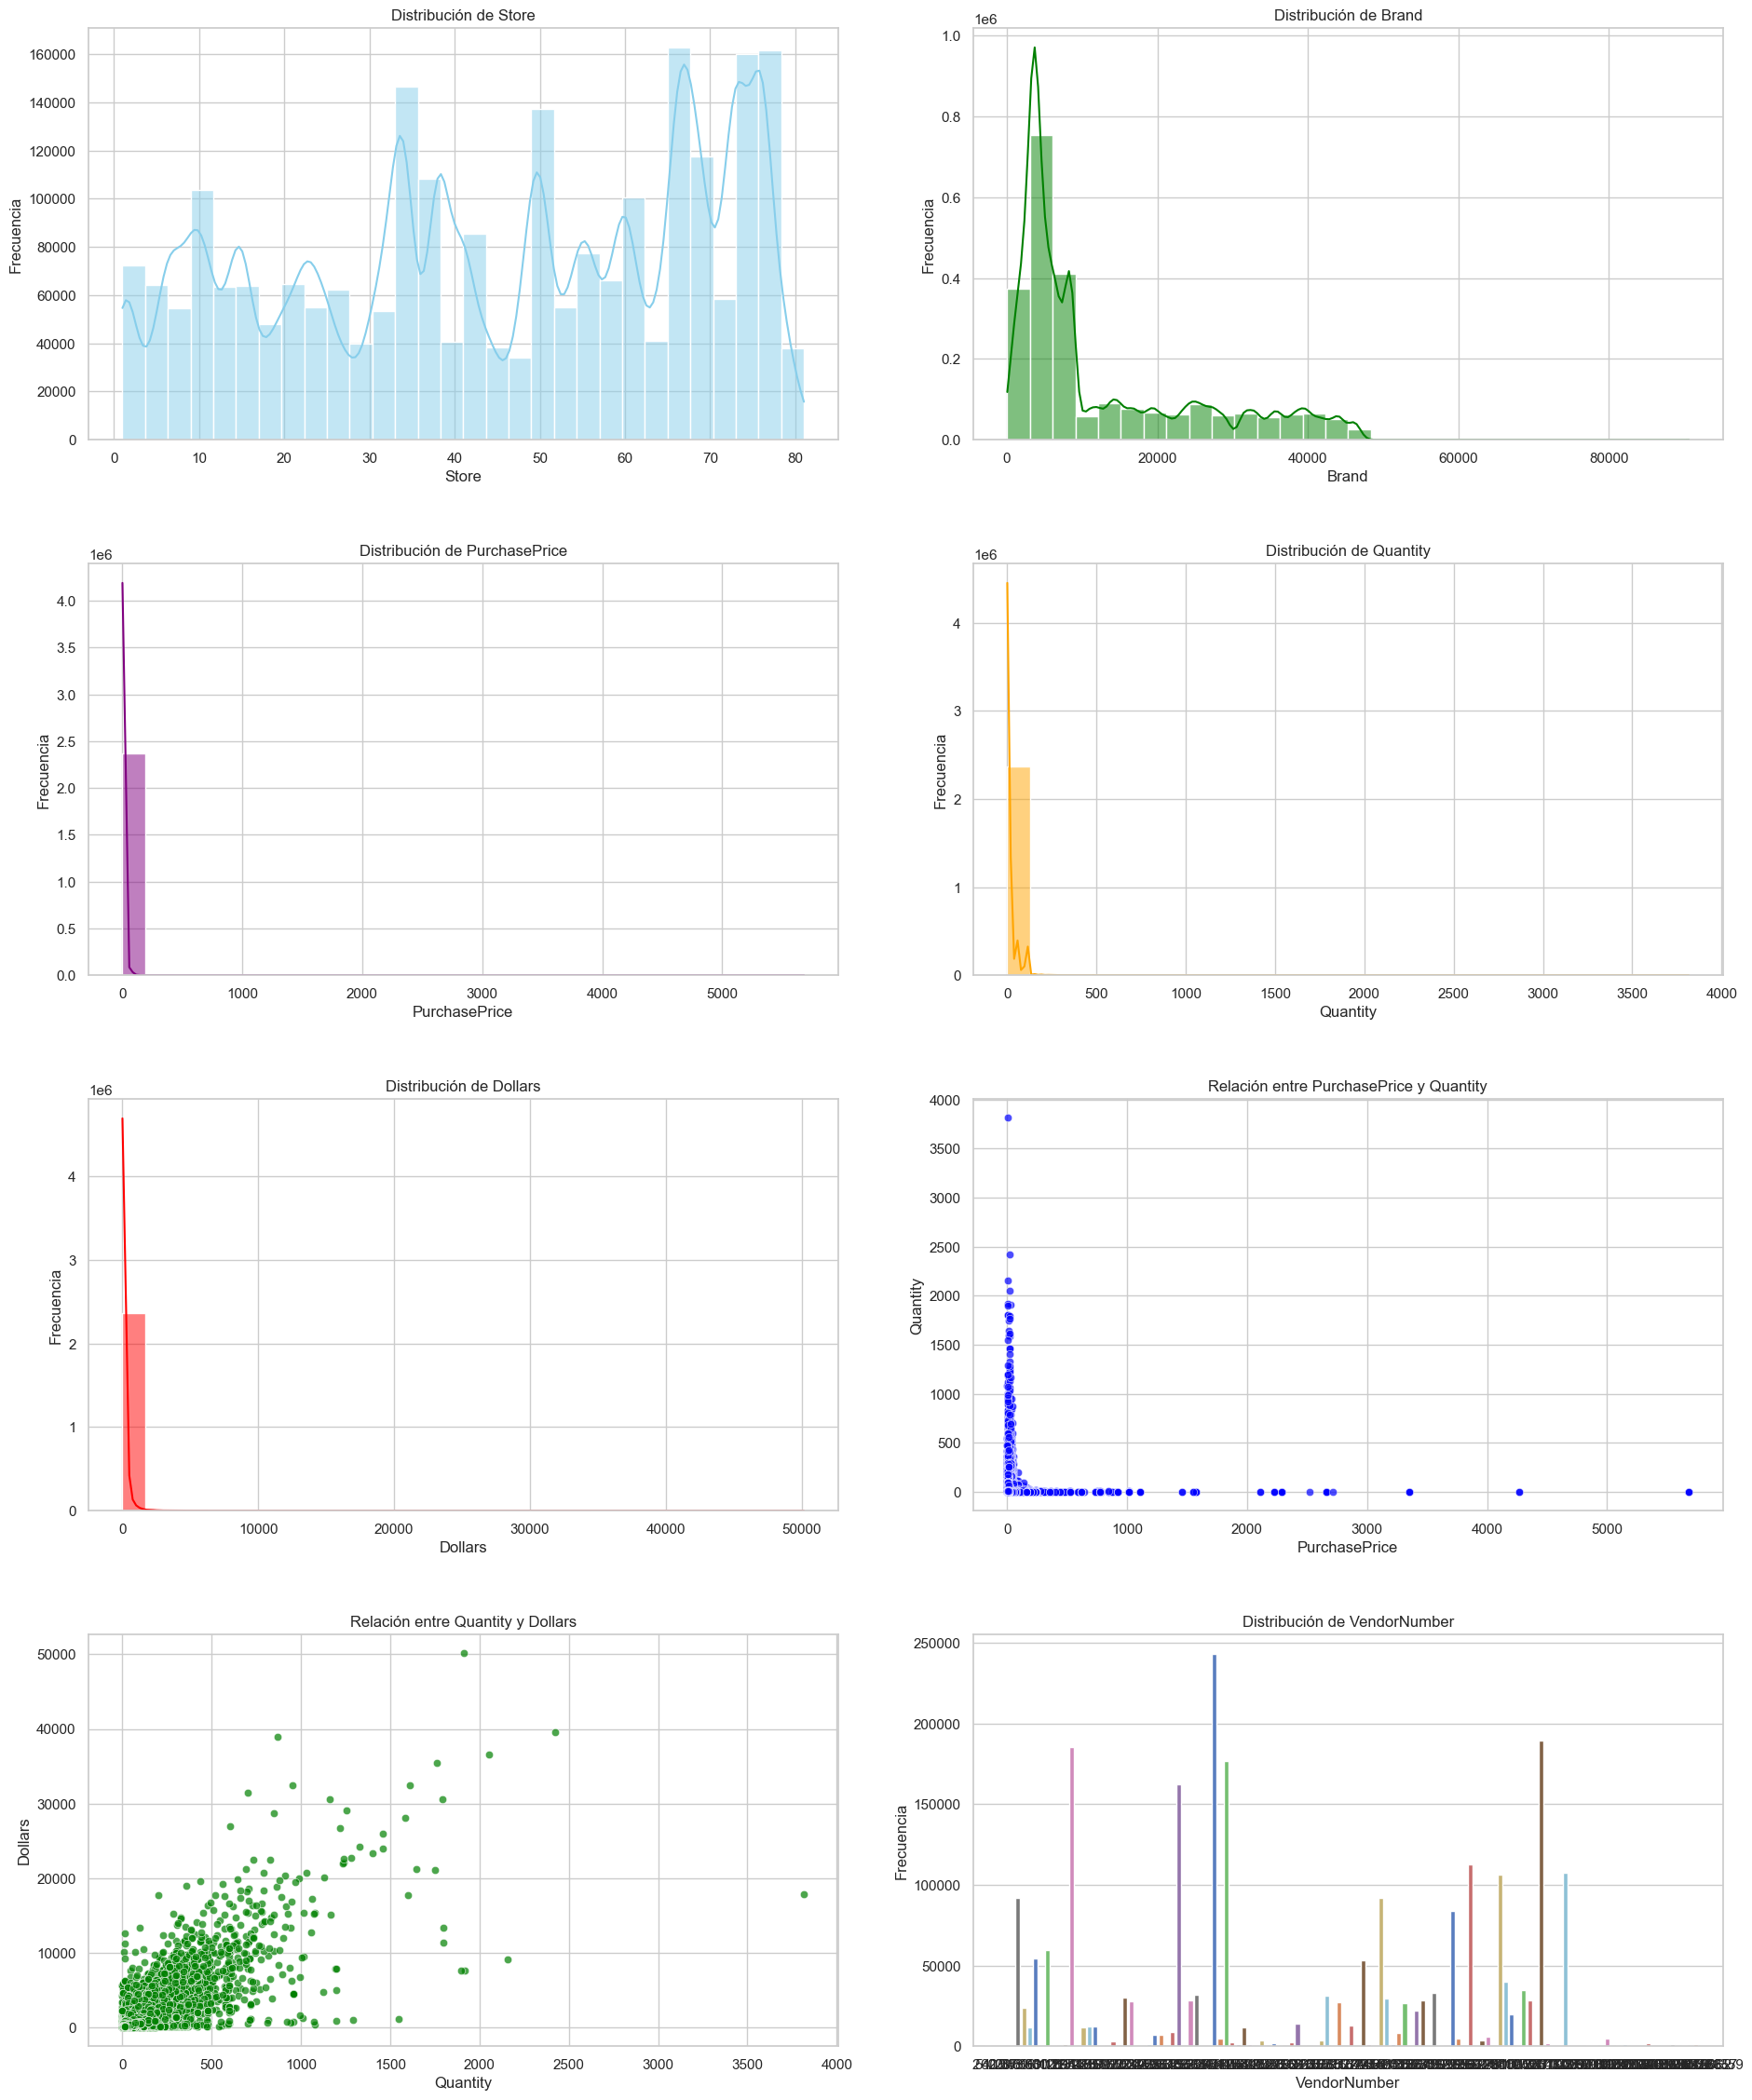

In [4]:
# Configuración de estilo para los gráficos
sns.set(style="whitegrid", palette="pastel")

# Crear un lienzo para múltiples gráficos
fig, axes = plt.subplots(4, 2, figsize=(20, 24))
fig.tight_layout(pad=6.0)

# 1. Distribución de Store
sns.histplot(data=purchases, x='Store', kde=True, bins=30, color='skyblue', ax=axes[0, 0])
axes[0, 0].set_title('Distribución de Store')
axes[0, 0].set_xlabel('Store')
axes[0, 0].set_ylabel('Frecuencia')

# 2. Distribución de Brand
sns.histplot(data=purchases, x='Brand', kde=True, bins=30, color='green', ax=axes[0, 1])
axes[0, 1].set_title('Distribución de Brand')
axes[0, 1].set_xlabel('Brand')
axes[0, 1].set_ylabel('Frecuencia')

# 3. Distribución de PurchasePrice
sns.histplot(data=purchases, x='PurchasePrice', kde=True, bins=30, color='purple', ax=axes[1, 0])
axes[1, 0].set_title('Distribución de PurchasePrice')
axes[1, 0].set_xlabel('PurchasePrice')
axes[1, 0].set_ylabel('Frecuencia')

# 4. Distribución de Quantity
sns.histplot(data=purchases, x='Quantity', kde=True, bins=30, color='orange', ax=axes[1, 1])
axes[1, 1].set_title('Distribución de Quantity')
axes[1, 1].set_xlabel('Quantity')
axes[1, 1].set_ylabel('Frecuencia')

# 5. Distribución de Dollars
sns.histplot(data=purchases, x='Dollars', kde=True, bins=30, color='red', ax=axes[2, 0])
axes[2, 0].set_title('Distribución de Dollars')
axes[2, 0].set_xlabel('Dollars')
axes[2, 0].set_ylabel('Frecuencia')

# 6. Relación entre PurchasePrice y Quantity
sns.scatterplot(data=purchases, x='PurchasePrice', y='Quantity', alpha=0.7, ax=axes[2, 1], color='blue')
axes[2, 1].set_title('Relación entre PurchasePrice y Quantity')
axes[2, 1].set_xlabel('PurchasePrice')
axes[2, 1].set_ylabel('Quantity')

# 7. Relación entre Dollars y Quantity
sns.scatterplot(data=purchases, x='Quantity', y='Dollars', alpha=0.7, ax=axes[3, 0], color='green')
axes[3, 0].set_title('Relación entre Quantity y Dollars')
axes[3, 0].set_xlabel('Quantity')
axes[3, 0].set_ylabel('Dollars')

# 8. Distribución de VendorNumber
sns.countplot(data=purchases, x='VendorNumber', palette='muted', ax=axes[3, 1])
axes[3, 1].set_title('Distribución de VendorNumber')
axes[3, 1].set_xlabel('VendorNumber')
axes[3, 1].set_ylabel('Frecuencia')

# Mostrar los gráficos
plt.show()


### Analisis de tabla sales

In [5]:
sales = pd.read_csv('Datos crudos\\SalesFINAL12312016.csv')
sales.head()

,InventoryId,Store,Brand,Description,Size,SalesQuantity,SalesDollars,SalesPrice,SalesDate,Volume,Classification,ExciseTax,VendorNo,VendorName
0,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,1,16.49,16.49,1/1/2016,750,1,0.79,12546,JIM BEAM BRANDS COMPANY
1,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,2,32.98,16.49,1/2/2016,750,1,1.57,12546,JIM BEAM BRANDS COMPANY
2,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,1,16.49,16.49,1/3/2016,750,1,0.79,12546,JIM BEAM BRANDS COMPANY
3,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,1,14.49,14.49,1/8/2016,750,1,0.79,12546,JIM BEAM BRANDS COMPANY
4,1_HARDERSFIELD_1005,1,1005,Maker's Mark Combo Pack,375mL 2 Pk,2,69.98,34.99,1/9/2016,375,1,0.79,12546,JIM BEAM BRANDS COMPANY


In [6]:

# Función para limpiar y normalizar cadenas de texto
def clean_string(value):
    if pd.isnull(value):  # Si el valor es nulo, lo retorna tal cual
        return value
    # Normalizar texto para eliminar acentos y caracteres especiales
    value = unicodedata.normalize('NFKD', value).encode('ascii', 'ignore').decode('utf-8')
    # Convertir a minúsculas, eliminar espacios extra y quitar espacios al inicio y final
    return ' '.join(value.strip().lower().split())

# Asegurar que InventoryId sea string
sales['InventoryId'] = sales['InventoryId'].astype('string')

# Aplicar limpieza a todas las columnas de tipo string
string_columns = sales.select_dtypes(include=['string']).columns
for col in string_columns:
    sales[col] = sales[col].apply(clean_string)

# Renombrar columnas según lo solicitado
sales.rename(columns={
    'VendorNo': 'VendorNumber',
    'Volume': 'size_ml',
    'SalesDate': 'SalesDate'
}, inplace=True)

# Convertir SalesDate a formato datetime
sales['SalesDate'] = pd.to_datetime(sales['SalesDate'], errors='coerce')

# Crear la columna índice SalesID
sales['SalesID'] = range(1, len(sales) + 1)

# Mover SalesID al inicio del DataFrame
sales = sales[['SalesID'] + [col for col in sales.columns if col != 'SalesID']]

# Verificar los cambios realizados
print("Tipos de datos después de las modificaciones:")
print(sales.dtypes)

print("Primeras filas del DataFrame modificado:")
print(sales.head())


Tipos de datos después de las modificaciones:
SalesID                    int64
InventoryId               object
Store                      int64
Brand                      int64
Description               object
Size                      object
SalesQuantity              int64
SalesDollars             float64
SalesPrice               float64
SalesDate         datetime64[ns]
size_ml                    int64
Classification             int64
ExciseTax                float64
VendorNumber               int64
VendorName                object
dtype: object
Primeras filas del DataFrame modificado:
   SalesID          InventoryId  Store  Brand                 Description  \
0        1  1_hardersfield_1004      1   1004  Jim Beam w/2 Rocks Glasses   
1        2  1_hardersfield_1004      1   1004  Jim Beam w/2 Rocks Glasses   
2        3  1_hardersfield_1004      1   1004  Jim Beam w/2 Rocks Glasses   
3        4  1_hardersfield_1004      1   1004  Jim Beam w/2 Rocks Glasses   
4        5  1_harde

In [7]:
# Verificar valores nulos en toda la tabla
print("Valores nulos por columna:")
print(sales.isnull().sum())


Valores nulos por columna:
SalesID           0
InventoryId       0
Store             0
Brand             0
Description       0
Size              0
SalesQuantity     0
SalesDollars      0
SalesPrice        0
SalesDate         0
size_ml           0
Classification    0
ExciseTax         0
VendorNumber      0
VendorName        0
dtype: int64


In [8]:
# Verificar si hay fechas futuras
future_dates = sales[sales['SalesDate'] > pd.Timestamp.today()]
print(f"Filas con fechas futuras: {len(future_dates)}")

Filas con fechas futuras: 0


In [9]:
# Resumen estadístico para detectar outliers
print(sales[['SalesQuantity', 'SalesDollars', 'SalesPrice', 'ExciseTax']].describe())

# Verificar valores negativos en columnas que no deberían tenerlos
negative_values = sales[(sales['SalesQuantity'] < 0) | (sales['SalesDollars'] < 0) | (sales['SalesPrice'] < 0)]
print(f"Filas con valores negativos: {len(negative_values)}")

       SalesQuantity  SalesDollars    SalesPrice     ExciseTax
count   1.048575e+06  1.048575e+06  1.048575e+06  1.048575e+06
mean    2.337619e+00  3.160420e+01  1.543162e+01  1.326847e+00
std     3.511492e+00  6.570249e+01  1.404967e+01  3.407898e+00
min     1.000000e+00  4.900000e-01  4.900000e-01  1.000000e-02
25%     1.000000e+00  1.099000e+01  8.990000e+00  1.600000e-01
50%     1.000000e+00  1.799000e+01  1.299000e+01  6.800000e-01
75%     2.000000e+00  3.199000e+01  1.899000e+01  1.570000e+00
max     4.320000e+02  1.327997e+04  4.999990e+03  3.785200e+02
Filas con valores negativos: 0


In [10]:
# Validar coherencia entre SalesDollars y SalesQuantity * SalesPrice
sales['CalculatedSalesDollars'] = sales['SalesQuantity'] * sales['SalesPrice']
inconsistencies = sales[sales['SalesDollars'] != sales['CalculatedSalesDollars']]
print(f"Filas con inconsistencias en SalesDollars: {len(inconsistencies)}")


Filas con inconsistencias en SalesDollars: 26018


In [11]:
# Ver las primeras filas con inconsistencias
print(sales[sales['SalesDollars'] != sales['CalculatedSalesDollars']].head(10))

# Estadísticas descriptivas de las inconsistencias
print(sales[sales['SalesDollars'] != sales['CalculatedSalesDollars']][['SalesDollars', 'CalculatedSalesDollars']].describe())


     SalesID           InventoryId  Store  Brand              Description  \
293      294  1_hardersfield_11213      1  11213            Meiomi Pnt Nr   
648      649   1_hardersfield_1232      1   1232  Jack Daniels No 7 Black   
651      652   1_hardersfield_1232      1   1232  Jack Daniels No 7 Black   
654      655   1_hardersfield_1232      1   1232  Jack Daniels No 7 Black   
661      662   1_hardersfield_1232      1   1232  Jack Daniels No 7 Black   
667      668   1_hardersfield_1233      1   1233  Jack Daniels No 7 Black   
671      672   1_hardersfield_1233      1   1233  Jack Daniels No 7 Black   
673      674   1_hardersfield_1233      1   1233  Jack Daniels No 7 Black   
676      677   1_hardersfield_1233      1   1233  Jack Daniels No 7 Black   
684      685   1_hardersfield_1233      1   1233  Jack Daniels No 7 Black   

      Size  SalesQuantity  SalesDollars  SalesPrice  SalesDate  size_ml  \
293  750mL              5        109.95       21.99 2016-01-27      750   
64

In [12]:
# Definir un umbral de tolerancia para las diferencias flotantes
epsilon = 1e-9

# Verificar si hay diferencias reales dentro del umbral
inconsistencies = sales[abs(sales['SalesDollars'] - sales['CalculatedSalesDollars']) > epsilon]

# Mostrar la cantidad de filas con diferencias reales
print(f"Filas con diferencias reales: {len(inconsistencies)}")
print(inconsistencies.head(10))

Filas con diferencias reales: 0
Empty DataFrame
Columns: [SalesID, InventoryId, Store, Brand, Description, Size, SalesQuantity, SalesDollars, SalesPrice, SalesDate, size_ml, Classification, ExciseTax, VendorNumber, VendorName, CalculatedSalesDollars]
Index: []


In [13]:
# Ajustar filas con diferencias menores al umbral
sales.loc[abs(sales['SalesDollars'] - sales['CalculatedSalesDollars']) <= epsilon, 'SalesDollars'] = sales['CalculatedSalesDollars']

# Verificar nuevamente las inconsistencias
remaining_inconsistencies = sales[sales['SalesDollars'] != sales['CalculatedSalesDollars']]
print(f"Inconsistencias restantes después del ajuste: {len(remaining_inconsistencies)}")


Inconsistencias restantes después del ajuste: 0


In [14]:
# Identificar duplicados
duplicates = sales.duplicated()
print(f"Filas duplicadas: {duplicates.sum()}")

# Eliminar duplicados si los hay
sales = sales.drop_duplicates()

Filas duplicadas: 0


In [20]:
data=sales
# Función para procesar la columna 'Size'
def parse_size(size):
    if pd.isnull(size):  # Verificar si el valor es nulo
        return {"size_ml": np.nan, "pack_count": np.nan}  # Retorna valores nulos si el campo es vacío
    
    size = size.strip().lower()  # Elimina espacios al principio/final y convierte a minúsculas

    #################################################################################################
    # Manejar paquetes, como "100mL 4 Pk"
    #################################################################################################
    match = re.match(r"(\d+(?:\.\d+)?)(ml|l) (\d+) pk", size)  # Buscar coincidencias con regex
    if match:
        unit_size = float(match.group(1))  # Tamaño individual
        if match.group(2) == 'l':  # Convertir litros a mililitros
            unit_size *= 1000
        pack_count = int(match.group(3))  # Número de botellas en el paquete
        return {"size_ml": unit_size, "pack_count": pack_count}

    #################################################################################################
    # Manejar tamaños con adicionales, como "750mL + 3/"
    #################################################################################################
    match = re.match(r"(\d+(?:\.\d+)?)(ml|l)(?: \+ (\d+)/)?", size)  # Buscar coincidencias con regex para valores con +
    if match:
        unit_size = float(match.group(1))  # Tamaño individual
        if match.group(2) == 'l':  # Convertir litros a mililitros
            unit_size *= 1000
        additional_count = int(match.group(3)) if match.group(3) else 0  # Ítems adicionales
        return {"size_ml": unit_size, "pack_count": 1 + additional_count}

    #################################################################################################
    # Manejar tamaños con número adicional separado por espacios, como "750mL  3"
    #################################################################################################
    match = re.match(r"(\d+(?:\.\d+)?)(ml|l)\s+(\d+)", size)  # Buscar coincidencias con espacios adicionales
    if match:
        unit_size = float(match.group(1))  # Tamaño individual
        if match.group(2) == 'l':  # Convertir litros a mililitros
            unit_size *= 1000
        pack_count = int(match.group(3))  # Número adicional
        return {"size_ml": unit_size, "pack_count": pack_count}

    #################################################################################################
    # Manejar tamaños individuales, como "750mL" o "162.5mL"
    #################################################################################################
    match = re.match(r"(\d+(?:\.\d+)?)(ml|l)", size)  # Busca tamaños individuales
    if match:
        unit_size = float(match.group(1))  # Tamaño individual
        if match.group(2) == 'l':  # Convertir litros a mililitros
            unit_size *= 1000
        return {"size_ml": unit_size, "pack_count": 1}

    #################################################################################################
    # Manejar casos problemáticos específicos
    #################################################################################################
    # Caso: "Liter" (1 litro)
    if size == 'liter':
        return {"size_ml": 1000, "pack_count": 1}

    # Caso: "3/100mL" (tres unidades de 100 mL)
    match = re.match(r"(\d+)/(\d+)(ml|l)", size)
    if match:
        pack_count = int(match.group(1))
        unit_size = float(match.group(2))
        if match.group(3) == 'l':  # Convertir litros a mililitros
            unit_size *= 1000
        return {"size_ml": unit_size, "pack_count": pack_count}

    # Caso: "5.0 Oz" o "22.0 Oz" (onzas líquidas convertidas a mililitros)
    match = re.match(r"(\d+(?:\.\d+)?) oz", size)
    if match:
        unit_size = float(match.group(1)) * 29.5735  # Convertir onzas líquidas a mililitros
        return {"size_ml": unit_size, "pack_count": 1}

    #################################################################################################
    # Retornar valores nulos si el tamaño no coincide con ningún patrón conocido
    #################################################################################################
    return {"size_ml": np.nan, "pack_count": np.nan}

# Aplicar la función parse_size a la columna 'Size'
size_data = data['Size'].apply(parse_size)

# Crear las nuevas columnas en el DataFrame
data['size_ml'] = size_data.apply(lambda x: x['size_ml'])
data['pack_count'] = size_data.apply(lambda x: x['pack_count'])

# Identificar valores problemáticos en la columna 'Size'
problematic_values = data[data['size_ml'].isnull()]['Size'].unique()

print("Valores problemáticos en la columna 'Size':")
print(problematic_values)

# Opciones para manejar valores nulos
# 1. Asignar valores predeterminados a los nulos
#data['size_ml'].fillna(data['size_ml'].median(), inplace=True)  # Imputar con la mediana
data['pack_count'].fillna(1, inplace=True)  # Suponer 1 como valor predeterminado

# Verificar valores nulos
print("\nValores nulos después de la imputación:")
print(data[['size_ml', 'pack_count']].isnull().sum())

# Verificar valores cero
print("\nValores iguales a cero:")
print((data[['size_ml', 'pack_count']] == 0).sum())



Valores problemáticos en la columna 'Size':
[]

Valores nulos después de la imputación:
size_ml       0
pack_count    0
dtype: int64

Valores iguales a cero:
size_ml       0
pack_count    0
dtype: int64


C:\Users\anagabrielagonzalezp\AppData\Local\Temp\ipykernel_6188\1493565672.py:95: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['pack_count'].fillna(1, inplace=True)  # Suponer 1 como valor predeterminado


In [21]:
data.drop(columns=['Size'], inplace=True)


Información general del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 13 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   SalesID        1048575 non-null  int64         
 1   InventoryId    1048575 non-null  object        
 2   Store          1048575 non-null  int64         
 3   Brand          1048575 non-null  int64         
 4   Description    1048575 non-null  object        
 5   SalesQuantity  1048575 non-null  int64         
 6   SalesDollars   1048575 non-null  float64       
 7   SalesPrice     1048575 non-null  float64       
 8   SalesDate      1048575 non-null  datetime64[ns]
 9   size_ml        1048575 non-null  float64       
 10  ExciseTax      1048575 non-null  float64       
 11  VendorNumber   1048575 non-null  int64         
 12  pack_count     1048575 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(6), object(2

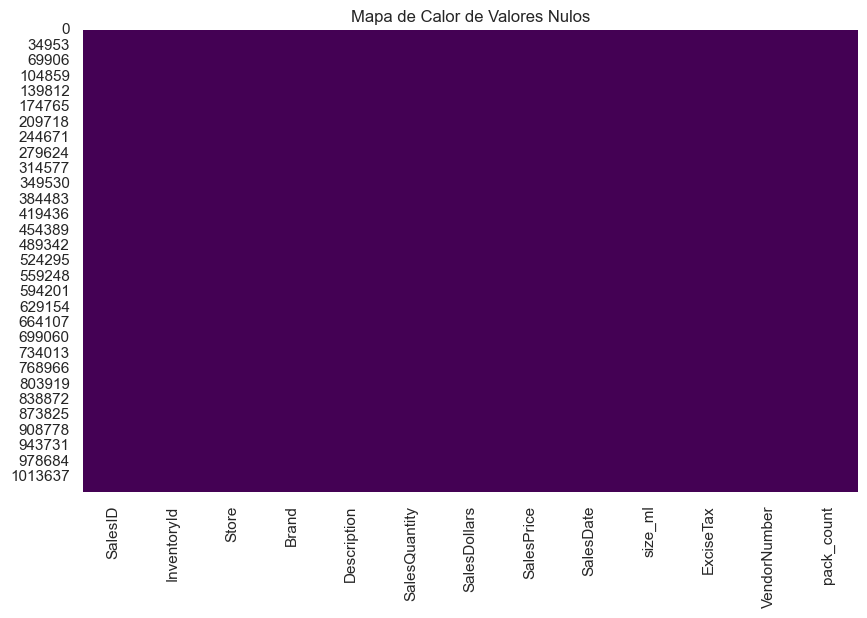

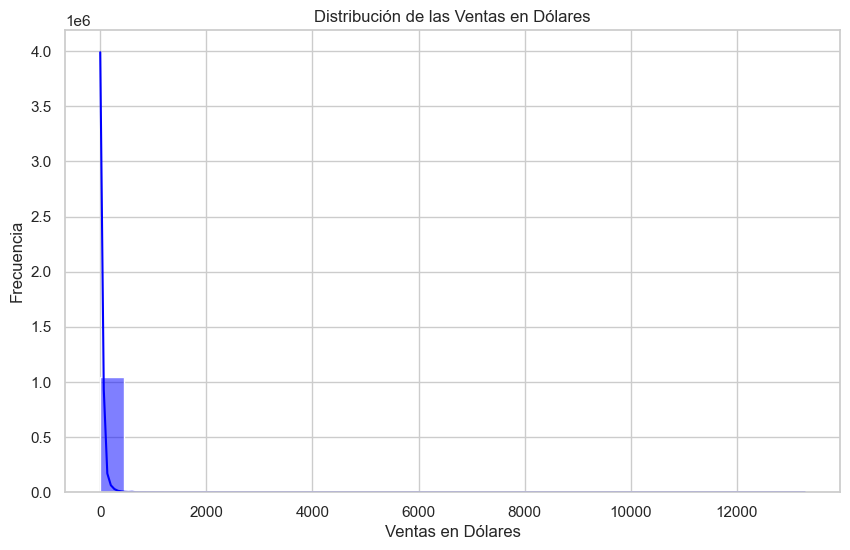

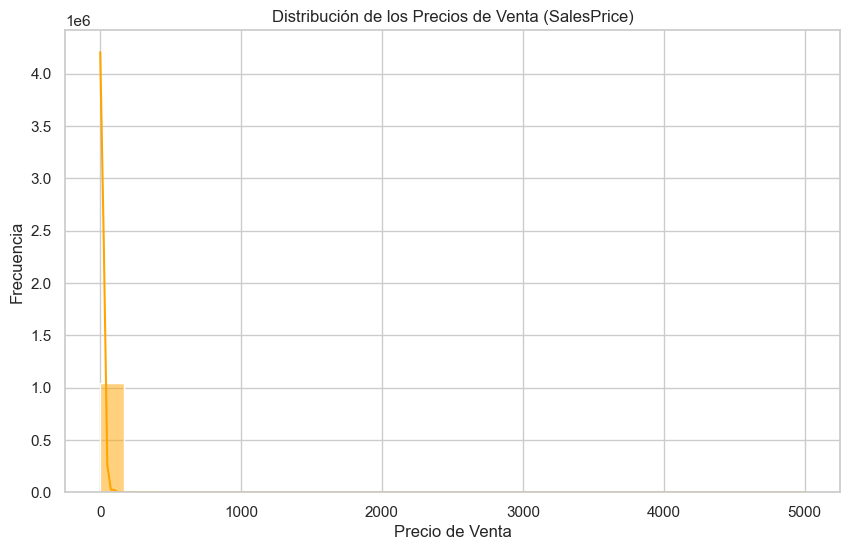

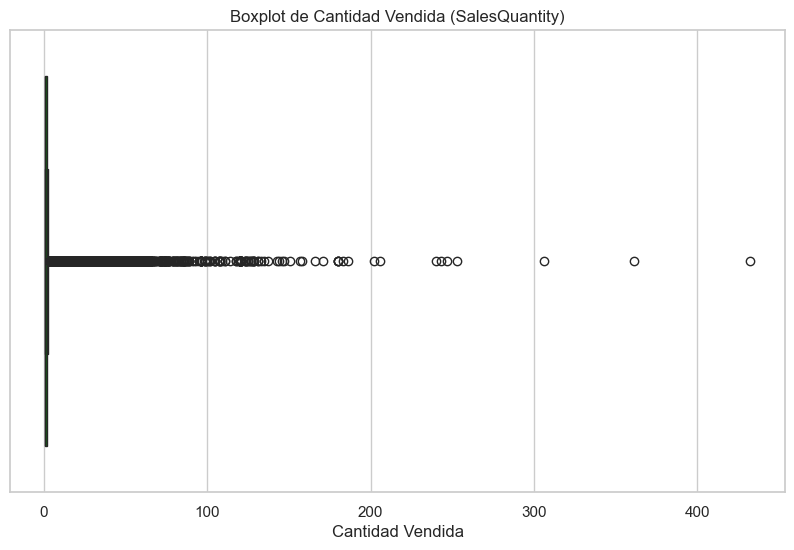

c:\BaseDeDatosFinal\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


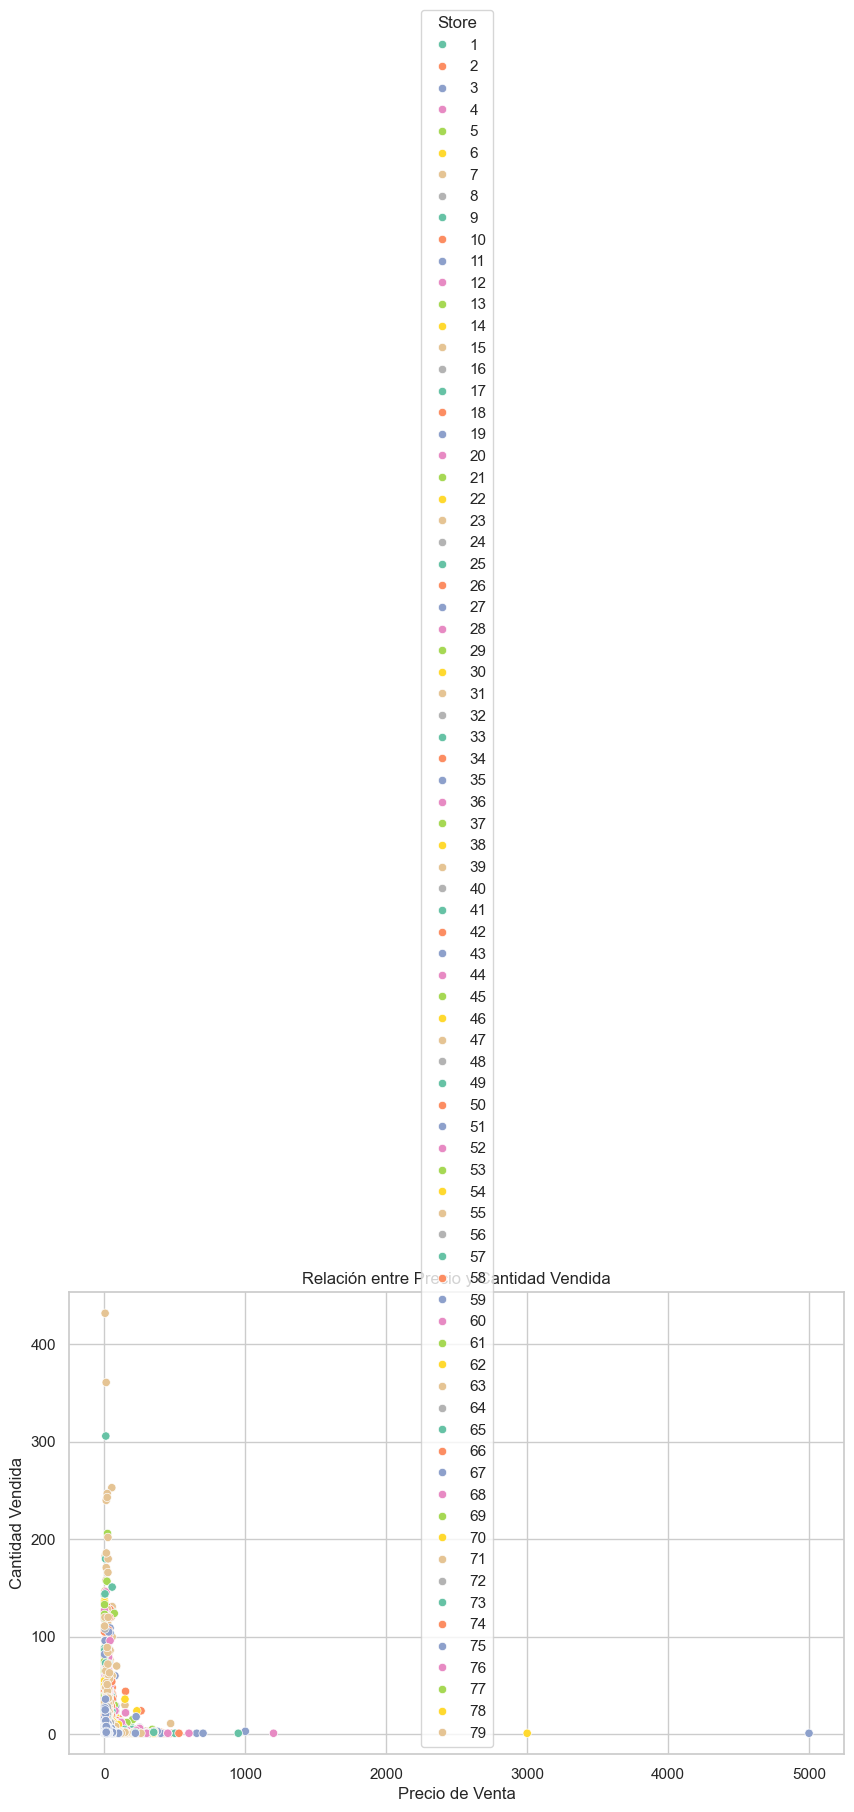

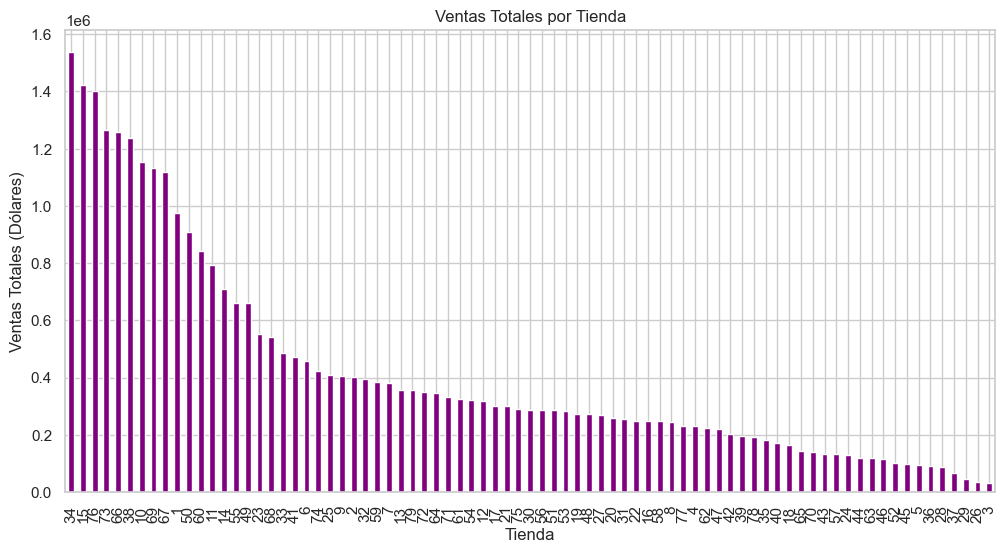

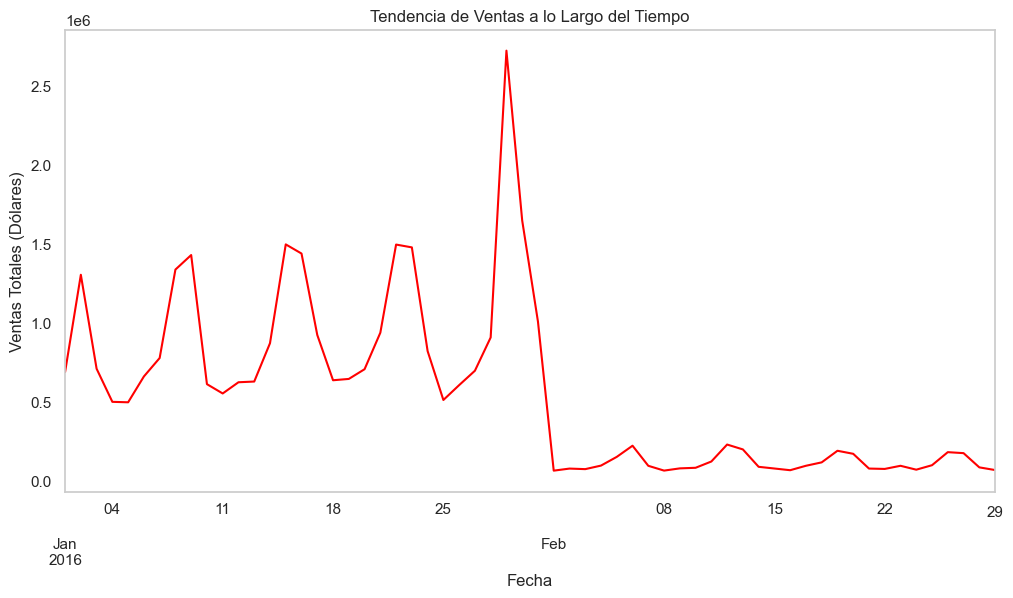

C:\Users\anagabrielagonzalezp\AppData\Local\Temp\ipykernel_6188\2731467917.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="size_ml", y="SalesDollars", data=data, palette="Blues")


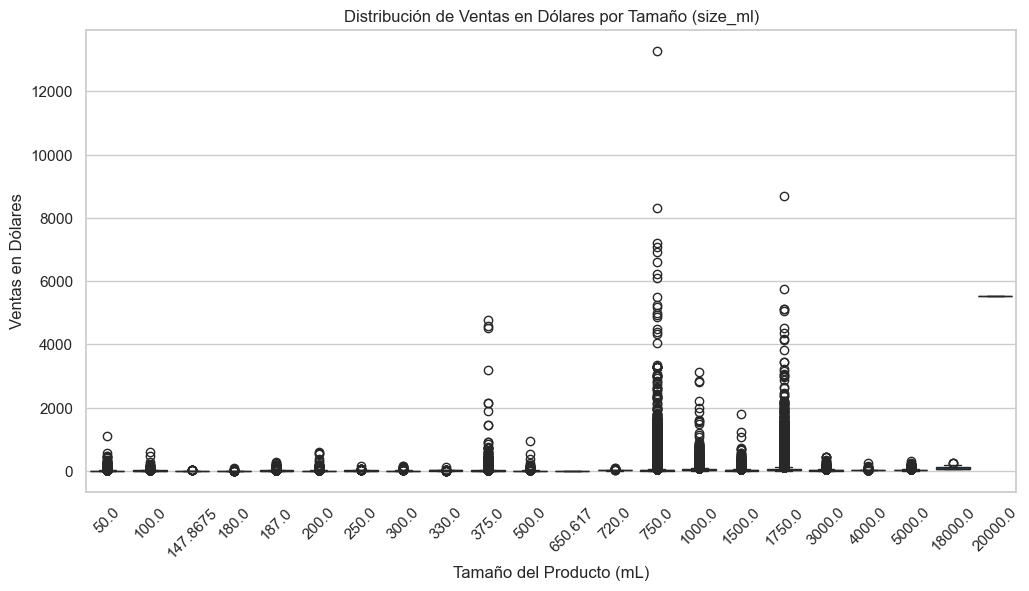

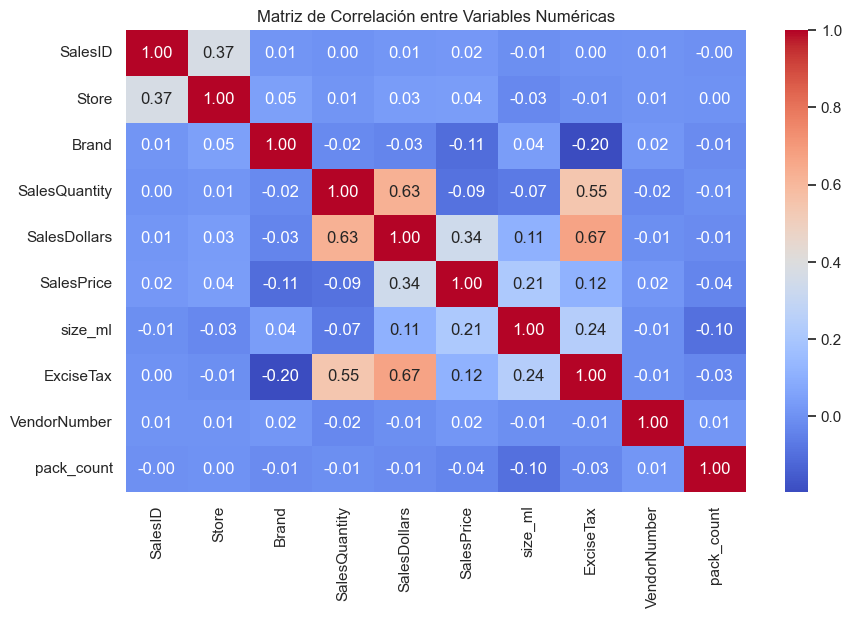

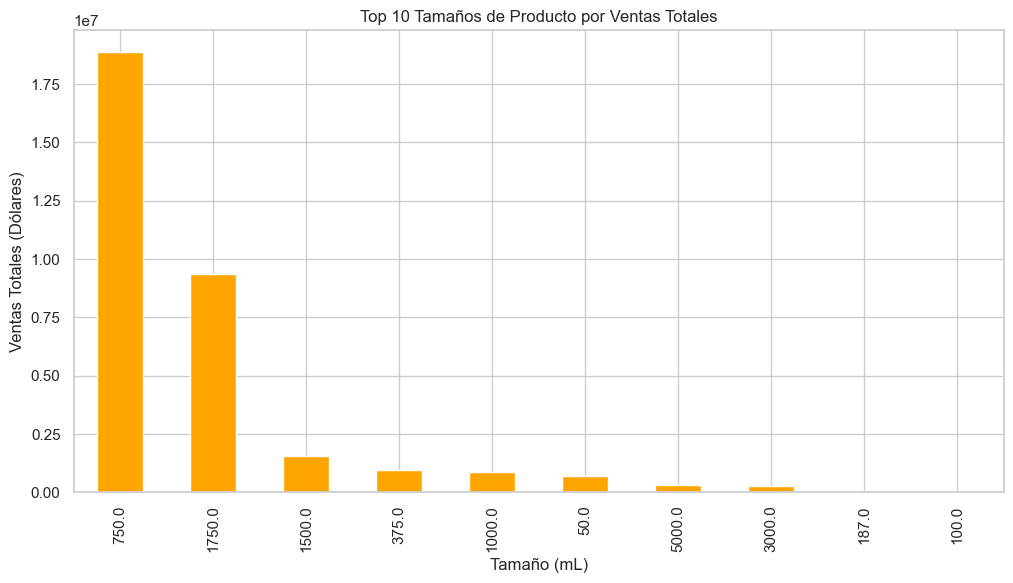

KeyboardInterrupt: 

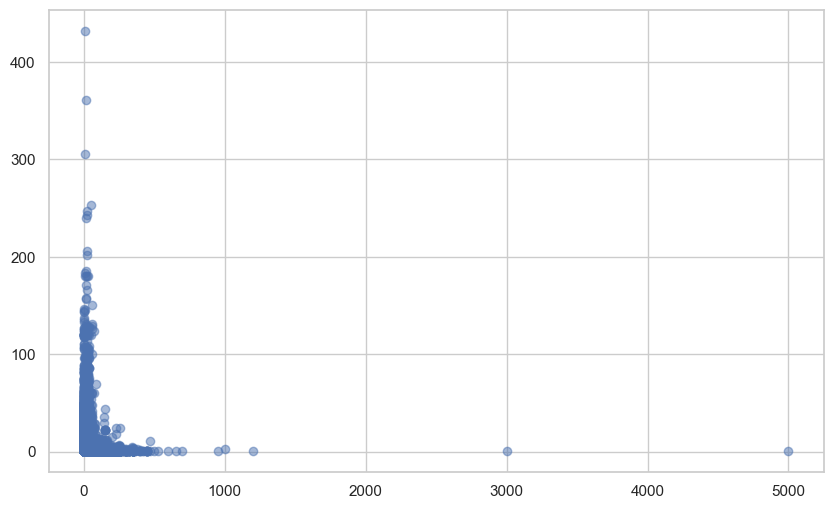

In [22]:
# Configuración para gráficos
sns.set(style="whitegrid")

# Información general del DataFrame
print("Información general del DataFrame:")
print(data.info())
print("\nEstadísticas descriptivas:")
print(data.describe())

# Valores nulos
print("\nValores nulos por columna:")
print(data.isnull().sum())

# Visualización de valores nulos
plt.figure(figsize=(10, 6))
sns.heatmap(data.isnull(), cbar=False, cmap="viridis")
plt.title("Mapa de Calor de Valores Nulos")
plt.show()

# Distribución de las ventas en dólares
plt.figure(figsize=(10, 6))
sns.histplot(data['SalesDollars'], kde=True, bins=30, color="blue")
plt.title("Distribución de las Ventas en Dólares")
plt.xlabel("Ventas en Dólares")
plt.ylabel("Frecuencia")
plt.show()

# Distribución de SalesPrice
plt.figure(figsize=(10, 6))
sns.histplot(data['SalesPrice'], kde=True, bins=30, color="orange")
plt.title("Distribución de los Precios de Venta (SalesPrice)")
plt.xlabel("Precio de Venta")
plt.ylabel("Frecuencia")
plt.show()

# Distribución de SalesQuantity
plt.figure(figsize=(10, 6))
sns.boxplot(x=data['SalesQuantity'], color="green")
plt.title("Boxplot de Cantidad Vendida (SalesQuantity)")
plt.xlabel("Cantidad Vendida")
plt.show()

# Relación entre SalesPrice y SalesQuantity
plt.figure(figsize=(10, 6))
sns.scatterplot(x='SalesPrice', y='SalesQuantity', hue='Store', data=data, palette="Set2")
plt.title("Relación entre Precio y Cantidad Vendida")
plt.xlabel("Precio de Venta")
plt.ylabel("Cantidad Vendida")
plt.show()

# Ventas totales por tienda
sales_by_store = data.groupby("Store")['SalesDollars'].sum().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sales_by_store.plot(kind="bar", color="purple")
plt.title("Ventas Totales por Tienda")
plt.xlabel("Tienda")
plt.ylabel("Ventas Totales (Dólares)")
plt.show()

# Tendencia de ventas a lo largo del tiempo
data['SalesDate'] = pd.to_datetime(data['SalesDate'])
sales_over_time = data.groupby("SalesDate")['SalesDollars'].sum()
plt.figure(figsize=(12, 6))
sales_over_time.plot(color="red")
plt.title("Tendencia de Ventas a lo Largo del Tiempo")
plt.xlabel("Fecha")
plt.ylabel("Ventas Totales (Dólares)")
plt.grid()
plt.show()

# Análisis de los tamaños de productos
plt.figure(figsize=(12, 6))
sns.boxplot(x="size_ml", y="SalesDollars", data=data, palette="Blues")
plt.title("Distribución de Ventas en Dólares por Tamaño (size_ml)")
plt.xlabel("Tamaño del Producto (mL)")
plt.ylabel("Ventas en Dólares")
plt.xticks(rotation=45)
plt.show()

# Correlación entre variables numéricas
# Filtrar solo las columnas numéricas
numeric_columns = data.select_dtypes(include=['number'])

# Calcular la matriz de correlación
correlation_matrix = numeric_columns.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación entre Variables Numéricas")
plt.show()

# Top 10 tamaños de producto por ventas
sales_by_size = data.groupby("size_ml")['SalesDollars'].sum().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sales_by_size.head(10).plot(kind="bar", color="orange")
plt.title("Top 10 Tamaños de Producto por Ventas Totales")
plt.xlabel("Tamaño (mL)")
plt.ylabel("Ventas Totales (Dólares)")
plt.show()

# Análisis de elasticidad: Precio vs Cantidad
plt.figure(figsize=(10, 6))
sns.regplot(x="SalesPrice", y="SalesQuantity", data=data, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title("Elasticidad del Precio")
plt.xlabel("Precio de Venta")
plt.ylabel("Cantidad Vendida")
plt.show()

# Análisis del impuesto especial
plt.figure(figsize=(10, 6))
sns.scatterplot(x="ExciseTax", y="SalesDollars", data=data, color="blue")
plt.title("Relación entre Impuesto Especial y Ventas")
plt.xlabel("Impuesto Especial (ExciseTax)")
plt.ylabel("Ventas Totales (Dólares)")
plt.show()

# Ventas por proveedor
sales_by_vendor = data.groupby("VendorNumber")['SalesDollars'].sum().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sales_by_vendor.head(10).plot(kind="bar", color="teal")
plt.title("Top 10 Proveedores por Ventas Totales")
plt.xlabel("Proveedor")
plt.ylabel("Ventas Totales (Dólares)")
plt.show()


In [23]:

# Encontrar la fila con el valor más alto en SalesDollars
max_sales_row = data[data['SalesDollars'] == data['SalesDollars'].max()]

# Mostrar el resultado
print("Fila con el valor más alto de SalesDollars:")
print(max_sales_row)


Fila con el valor más alto de SalesDollars:
         SalesID        InventoryId  Store  Brand  \
1021958  1021959  15_wanborne_42188     15  42188   

                          Description  SalesQuantity  SalesDollars  \
1021958  Moet & Chandon Nectar Imp Rs            253      13279.97   

         SalesPrice  SalesDate  size_ml  ExciseTax  VendorNumber  pack_count  
1021958       52.49 2016-02-06    750.0      28.46          8112           1  


In [24]:
# Obtener la marca de la fila con el valor más alto
brand_of_max_sales = max_sales_row['Brand'].iloc[0]

# Buscar otras filas con la misma marca
rows_with_same_brand = data[data['Brand'] == brand_of_max_sales]

# Mostrar el resultado
print("Fila con el valor más alto de SalesDollars:")
print(max_sales_row)

print("\nOtras filas con la misma marca:")
print(rows_with_same_brand)

Fila con el valor más alto de SalesDollars:
         SalesID        InventoryId  Store  Brand  \
1021958  1021959  15_wanborne_42188     15  42188   

                          Description  SalesQuantity  SalesDollars  \
1021958  Moet & Chandon Nectar Imp Rs            253      13279.97   

         SalesPrice  SalesDate  size_ml  ExciseTax  VendorNumber  pack_count  
1021958       52.49 2016-02-06    750.0      28.46          8112           1  

Otras filas con la misma marca:
         SalesID           InventoryId  Store  Brand  \
11293      11294  1_hardersfield_42188      1  42188   
28086      28087      10_hornsey_42188     10  42188   
28087      28088      10_hornsey_42188     10  42188   
28088      28089      10_hornsey_42188     10  42188   
28089      28090      10_hornsey_42188     10  42188   
...          ...                   ...    ...    ...   
1021958  1021959     15_wanborne_42188     15  42188   
1021959  1021960     15_wanborne_42188     15  42188   
1021960  1021

In [25]:
# Verificar si 'Brand' es la misma en todas las filas
is_same_brand = rows_with_same_brand['Brand'].nunique() == 1

# Verificar si 'SalesQuantity' es la misma en todas las filas
is_same_salesquantity = rows_with_same_brand['SalesQuantity'].nunique() == 1

# Verificar si 'size_ml' es la misma en todas las filas
is_same_size_ml = rows_with_same_brand['size_ml'].nunique() == 1

# Verificar si 'pack_count' es la misma en todas las filas
is_same_pack_count = rows_with_same_brand['pack_count'].nunique() == 1

# Mostrar los resultados
print("¿La marca (Brand) es la misma en todas las filas?", is_same_brand)
print("¿La cantidad de ventas (SalesQuantity) es la misma en todas las filas?", is_same_salesquantity)
print("¿El tamaño (size_ml) es el mismo en todas las filas?", is_same_size_ml)
print("¿El número de paquetes (pack_count) es el mismo en todas las filas?", is_same_pack_count)


¿La marca (Brand) es la misma en todas las filas? True
¿La cantidad de ventas (SalesQuantity) es la misma en todas las filas? False
¿El tamaño (size_ml) es el mismo en todas las filas? True
¿El número de paquetes (pack_count) es el mismo en todas las filas? True


In [26]:
# Filtrar las filas con la misma marca
brand_rows = rows_with_same_brand

# Encontrar la fila con el precio más alto
row_with_max_price = brand_rows.loc[brand_rows['SalesDollars'].idxmax()]

# Obtener el valor de 'SalesQuantity' en la fila con el precio más alto
max_price_sales_quantity = row_with_max_price['SalesQuantity']

# Calcular la diferencia en 'SalesQuantity' respecto a esa fila
brand_rows['SalesQuantity_Difference'] = brand_rows['SalesQuantity'] - max_price_sales_quantity

# Mostrar el resultado
print("Fila con sales más alto:")
print(row_with_max_price)
print("\nDiferencia de SalesQuantity en comparación con el precio más alto:")
print(brand_rows[['SalesQuantity', 'SalesQuantity_Difference', 'SalesDollars']])


Fila con sales más alto:
SalesID                               1021959
InventoryId                 15_wanborne_42188
Store                                      15
Brand                                   42188
Description      Moet & Chandon Nectar Imp Rs
SalesQuantity                             253
SalesDollars                         13279.97
SalesPrice                              52.49
SalesDate                 2016-02-06 00:00:00
size_ml                                 750.0
ExciseTax                               28.46
VendorNumber                             8112
pack_count                                  1
Name: 1021958, dtype: object

Diferencia de SalesQuantity en comparación con el precio más alto:
         SalesQuantity  SalesQuantity_Difference  SalesDollars
11293                2                      -251        109.98
28086                2                      -251         99.98
28087                4                      -249        199.96
28088                3      

C:\Users\anagabrielagonzalezp\AppData\Local\Temp\ipykernel_6188\80135267.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brand_rows['SalesQuantity_Difference'] = brand_rows['SalesQuantity'] - max_price_sales_quantity


EL DATO ESTA OK, SALES QUANTITY ES UN MONTON 253!

In [ ]:
# Guardar con configuración estándar para SQL
output_path = 'cleaned_sales.csv'
data.to_csv(output_path, index=False, encoding='utf-8', lineterminator='\n')

### Analisis de EndInventory

In [31]:
end_inventory = pd.read_csv('Datos crudos\\EndInvFINAL12312016.csv')
end_inventory.head()

,InventoryId,Store,City,Brand,Description,Size,onHand,Price,endDate
0,1_HARDERSFIELD_58,1,HARDERSFIELD,58,Gekkeikan Black & Gold Sake,750mL,11,12.99,2016-12-31
1,1_HARDERSFIELD_62,1,HARDERSFIELD,62,Herradura Silver Tequila,750mL,7,36.99,2016-12-31
2,1_HARDERSFIELD_63,1,HARDERSFIELD,63,Herradura Reposado Tequila,750mL,7,38.99,2016-12-31
3,1_HARDERSFIELD_72,1,HARDERSFIELD,72,No. 3 London Dry Gin,750mL,4,34.99,2016-12-31
4,1_HARDERSFIELD_75,1,HARDERSFIELD,75,Three Olives Tomato Vodka,750mL,7,14.99,2016-12-31


In [32]:
endInv = pd.read_csv('Datos crudos\\EndInvFINAL12312016.csv')


In [33]:
# Convertir a minúsculas y eliminar espacios en columnas de texto
columns_to_clean = ['InventoryId', 'City', 'Description', 'Size']
for col in columns_to_clean:
    end_inventory[col] = end_inventory[col].str.strip().str.lower()

# Convertir endDate al tipo datetime
end_inventory['endDate'] = pd.to_datetime(end_inventory['endDate'], errors='coerce')

# Verificar y manejar valores nulos
end_inventory['Size'] = end_inventory['Size'].fillna('unknown')
end_inventory['City'] = end_inventory['City'].fillna('unknown')
end_inventory['Price'] = end_inventory['Price'].replace(0, np.nan)

# Eliminar filas con valores nulos críticos (Price, endDate)
end_inventory = end_inventory.dropna(subset=['Price', 'endDate'])

# Revisar valores numéricos sospechosos en Price y onHand
end_inventory = end_inventory[end_inventory['Price'] > 0]
end_inventory = end_inventory[end_inventory['onHand'] >= 0]

# Eliminar duplicados
end_inventory = end_inventory.drop_duplicates()


In [34]:

# Definir la función para procesar la columna 'Size'
def parse_size(size):
    if pd.isnull(size):  # Verificar si el valor es nulo
        return {"size_ml": np.nan, "pack_count": np.nan}  # Retorna valores nulos si el campo es vacío
    
    size = size.strip().lower()  # Elimina espacios al principio/final y convierte a minúsculas

    #################################################################################################
    # Manejar paquetes, como "100mL 4 Pk"
    #################################################################################################
    match = re.match(r"(\d+(?:\.\d+)?)(ml|l) (\d+) pk", size)  # Buscar coincidencias con regex
    if match:
        unit_size = float(match.group(1))  # Tamaño individual
        if match.group(2) == 'l':  # Convertir litros a mililitros
            unit_size *= 1000
        pack_count = int(match.group(3))  # Número de botellas en el paquete
        return {"size_ml": unit_size, "pack_count": pack_count}

    #################################################################################################
    # Manejar tamaños con adicionales, como "750mL + 3/"
    #################################################################################################
    match = re.match(r"(\d+(?:\.\d+)?)(ml|l)(?: \+ (\d+)/)?", size)  # Buscar coincidencias con regex para valores con +
    if match:
        unit_size = float(match.group(1))  # Tamaño individual
        if match.group(2) == 'l':  # Convertir litros a mililitros
            unit_size *= 1000
        additional_count = int(match.group(3)) if match.group(3) else 0  # Ítems adicionales
        return {"size_ml": unit_size, "pack_count": 1 + additional_count}

    #################################################################################################
    # Manejar tamaños con número adicional separado por espacios, como "750mL  3"
    #################################################################################################
    match = re.match(r"(\d+(?:\.\d+)?)(ml|l)\s+(\d+)", size)  # Buscar coincidencias con espacios adicionales
    if match:
        unit_size = float(match.group(1))  # Tamaño individual
        if match.group(2) == 'l':  # Convertir litros a mililitros
            unit_size *= 1000
        pack_count = int(match.group(3))  # Número adicional
        return {"size_ml": unit_size, "pack_count": pack_count}

    #################################################################################################
    # Manejar tamaños individuales, como "750mL" o "162.5mL"
    #################################################################################################
    match = re.match(r"(\d+(?:\.\d+)?)(ml|l)", size)  # Busca tamaños individuales
    if match:
        unit_size = float(match.group(1))  # Tamaño individual
        if match.group(2) == 'l':  # Convertir litros a mililitros
            unit_size *= 1000
        return {"size_ml": unit_size, "pack_count": 1}

    #################################################################################################
    # Retornar valores nulos si el tamaño no coincide con ningún patrón conocido
    #################################################################################################
    return {"size_ml": np.nan, "pack_count": np.nan}

# Aplicar la función parse_size a la columna 'Size' en end_inventory
size_data = end_inventory['Size'].apply(parse_size)

# Crear nuevas columnas en el DataFrame
end_inventory['size_ml'] = size_data.apply(lambda x: x['size_ml'])
end_inventory['pack_count'] = size_data.apply(lambda x: x['pack_count'])

# Verificar las primeras filas para confirmar resultados
print("Primeras filas del DataFrame después de procesar la columna 'Size':")
print(end_inventory[['Size', 'size_ml', 'pack_count']].head(10))

# Contar valores nulos para evaluar el éxito del procesamiento
print("Valores nulos en las columnas derivadas:")
print(end_inventory[['size_ml', 'pack_count']].isnull().sum())

# Identificar valores problemáticos
problematic_rows = end_inventory[end_inventory['size_ml'].isnull()]
print("Valores problemáticos en la columna 'Size':")
print(problematic_rows['Size'].unique())


Primeras filas del DataFrame después de procesar la columna 'Size':
         Size  size_ml  pack_count
0       750ml    750.0         1.0
1       750ml    750.0         1.0
2       750ml    750.0         1.0
3       750ml    750.0         1.0
4       750ml    750.0         1.0
5       750ml    750.0         1.0
6       750ml    750.0         1.0
7       liter      NaN         NaN
8       liter      NaN         NaN
9  750ml + 2/    750.0         3.0
Valores nulos en las columnas derivadas:
size_ml       3867
pack_count    3867
dtype: int64
Valores problemáticos en la columna 'Size':
['liter' '3/100ml' '5.0 oz' '5/2 oz' '25.0' '128.0 gal']


In [35]:
# Función para manejar valores problemáticos
def handle_problematic_size(size):
    if size == 'liter':
        return {"size_ml": 1000, "pack_count": 1}
    elif size == '3/100ml':
        return {"size_ml": 100, "pack_count": 3}
    elif size == '5.0 oz':
        return {"size_ml": 5.0 * 29.5735, "pack_count": 1}
    elif size == '5/2 oz':
        return {"size_ml": 2 * 29.5735, "pack_count": 5}
    elif size == '25.0':
        return {"size_ml": np.nan, "pack_count": np.nan}  # Sin contexto, se deja como NaN
    elif size == '128.0 gal':
        return {"size_ml": 128.0 * 3785.41, "pack_count": 1}
    else:
        return {"size_ml": np.nan, "pack_count": np.nan}  # Valores no reconocidos

# Aplicar la función a los valores problemáticos
problematic_indices = end_inventory[end_inventory['Size'].isin(['liter', '3/100ml', '5.0 oz', '5/2 oz', '25.0', '128.0 gal'])].index
corrected_sizes = end_inventory.loc[problematic_indices, 'Size'].apply(handle_problematic_size)

# Actualizar las columnas size_ml y pack_count para estos valores
end_inventory.loc[problematic_indices, 'size_ml'] = corrected_sizes.apply(lambda x: x['size_ml'])
end_inventory.loc[problematic_indices, 'pack_count'] = corrected_sizes.apply(lambda x: x['pack_count'])

# Verificar los cambios
print("Valores actualizados para los casos problemáticos:")
print(end_inventory.loc[problematic_indices, ['Size', 'size_ml', 'pack_count']])


Valores actualizados para los casos problemáticos:
         Size  size_ml  pack_count
7       liter   1000.0         1.0
8       liter   1000.0         1.0
17      liter   1000.0         1.0
18      liter   1000.0         1.0
24      liter   1000.0         1.0
...       ...      ...         ...
222159  liter   1000.0         1.0
222371  liter   1000.0         1.0
222373  liter   1000.0         1.0
223507  liter   1000.0         1.0
223776  liter   1000.0         1.0

[3867 rows x 3 columns]


In [36]:
end_inventory.dtypes

InventoryId            object
Store                   int64
City                   object
Brand                   int64
Description            object
Size                   object
onHand                  int64
Price                 float64
endDate        datetime64[ns]
size_ml               float64
pack_count            float64
dtype: object

Estadísticas descriptivas básicas:
               Store          Brand         onHand          Price  \
count  224489.000000  224489.000000  224489.000000  224489.000000   
mean       43.505740   14356.370513      21.763988      23.585583   
min         1.000000      58.000000       0.000000       0.490000   
25%        23.000000    3798.000000       7.000000       9.990000   
50%        44.000000    8259.000000      12.000000      14.990000   
75%        66.000000   23965.000000      22.000000      23.490000   
max        81.000000   90631.000000    3676.000000   13999.900000   
std        23.326415   13118.467851      37.233576      79.202775   

                   endDate        size_ml     pack_count  
count               224489  224488.000000  224488.000000  
mean   2016-12-31 00:00:00     908.012388       1.022429  
min    2016-12-31 00:00:00      50.000000       1.000000  
25%    2016-12-31 00:00:00     750.000000       1.000000  
50%    2016-12-31 00:00:00     750.000000       

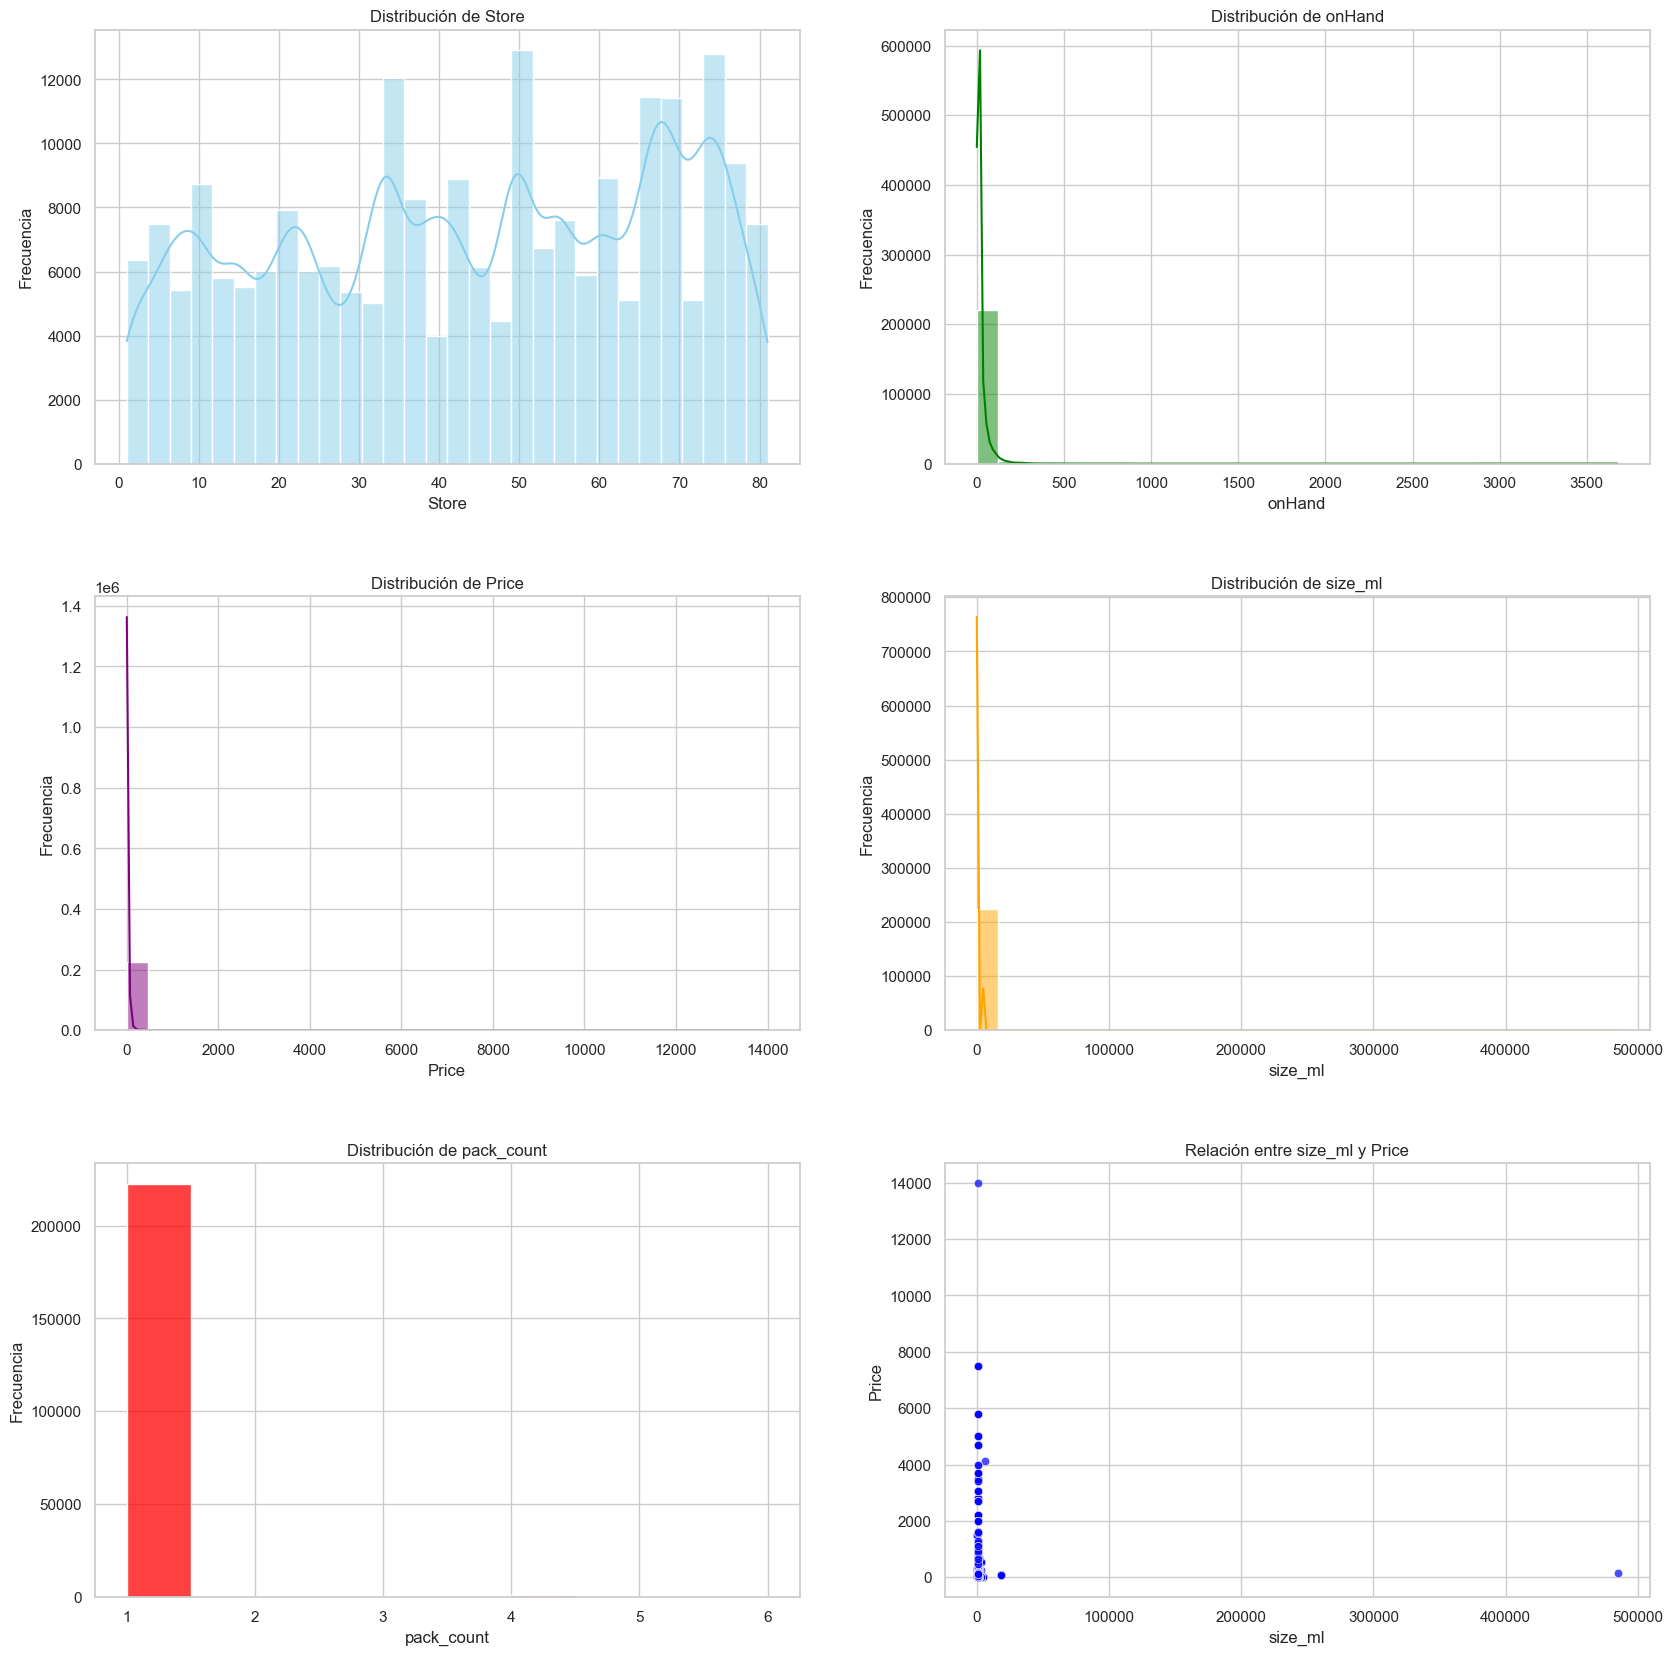

In [38]:
# Configuración de estilo para gráficos
sns.set(style="whitegrid", palette="pastel")

# Estadísticas descriptivas básicas
print("Estadísticas descriptivas básicas:")
print(end_inventory.describe())

# Crear un lienzo para múltiples gráficos
fig, axes = plt.subplots(3, 2, figsize=(18, 18))
fig.tight_layout(pad=6.0)

# 1. Distribución de Store
sns.histplot(data=end_inventory, x='Store', kde=True, bins=30, color='skyblue', ax=axes[0, 0])
axes[0, 0].set_title('Distribución de Store')
axes[0, 0].set_xlabel('Store')
axes[0, 0].set_ylabel('Frecuencia')

# 2. Distribución de onHand
sns.histplot(data=end_inventory, x='onHand', kde=True, bins=30, color='green', ax=axes[0, 1])
axes[0, 1].set_title('Distribución de onHand')
axes[0, 1].set_xlabel('onHand')
axes[0, 1].set_ylabel('Frecuencia')

# 3. Distribución de Price
sns.histplot(data=end_inventory, x='Price', kde=True, bins=30, color='purple', ax=axes[1, 0])
axes[1, 0].set_title('Distribución de Price')
axes[1, 0].set_xlabel('Price')
axes[1, 0].set_ylabel('Frecuencia')

# 4. Distribución de size_ml
sns.histplot(data=end_inventory, x='size_ml', kde=True, bins=30, color='orange', ax=axes[1, 1])
axes[1, 1].set_title('Distribución de size_ml')
axes[1, 1].set_xlabel('size_ml')
axes[1, 1].set_ylabel('Frecuencia')

# 5. Distribución de pack_count
sns.histplot(data=end_inventory, x='pack_count', kde=False, bins=10, color='red', ax=axes[2, 0])
axes[2, 0].set_title('Distribución de pack_count')
axes[2, 0].set_xlabel('pack_count')
axes[2, 0].set_ylabel('Frecuencia')

# 6. Relación entre Price y size_ml
sns.scatterplot(data=end_inventory, x='size_ml', y='Price', alpha=0.7, ax=axes[2, 1], color='blue')
axes[2, 1].set_title('Relación entre size_ml y Price')
axes[2, 1].set_xlabel('size_ml')
axes[2, 1].set_ylabel('Price')

# Mostrar gráficos
plt.show()


In [39]:
# Eliminar la columna 'Size'
end_inventory = end_inventory.drop(columns=['Size'])
print("Columna 'Size' eliminada exitosamente.")


Columna 'Size' eliminada exitosamente.


In [40]:
print("Verificando valores en 'size_ml' y 'pack_count'...")

invalid_size_ml = end_inventory[~end_inventory['size_ml'].apply(lambda x: isinstance(x, (int, float)) or pd.isnull(x))]
invalid_pack_count = end_inventory[~end_inventory['pack_count'].apply(lambda x: isinstance(x, (int, float)) or pd.isnull(x))]

print(f"Valores no válidos en 'size_ml':\n{invalid_size_ml}")
print(f"Valores no válidos en 'pack_count':\n{invalid_pack_count}")


Verificando valores en 'size_ml' y 'pack_count'...
Valores no válidos en 'size_ml':
Empty DataFrame
Columns: [InventoryId, Store, City, Brand, Description, onHand, Price, endDate, size_ml, pack_count]
Index: []
Valores no válidos en 'pack_count':
Empty DataFrame
Columns: [InventoryId, Store, City, Brand, Description, onHand, Price, endDate, size_ml, pack_count]
Index: []


In [ ]:
data.to_csv('cleaned_endInventory.csv', index=False)
